In [38]:
study = 'Sleep Lab'

### DB and S3 ###

In [39]:
from aws_manager import S3Manager, DBManagerSystem
import yaml
import pandas as pd

def fetch_motion_results(db_manager, session_id):
    query = f"SELECT * FROM MotionResult WHERE SessionID = {session_id}"
    return pd.read_sql(query, db_manager.engine)

def fetch_study_sessions(db_manager, study):
    query = f"""
    SELECT Patient.PatientStudyName, Patient.EnrollmentTime,
    Session.* FROM Session 
    JOIN Patient ON Session.PatientID = Patient.ID 
    JOIN Study ON Patient.StudyID = Study.ID 
    WHERE Study.Name = '{study}'
    """
    return pd.read_sql(query, db_manager.engine)


def load_config():
    with open('params/parameters.yaml', 'r') as file:
        config = yaml.safe_load(file)
    return config

S3_CONFIG = load_config()['Cloud']['s3']
DB_CONFIG = load_config()['Cloud']['DB_system']

s3_manager = S3Manager(
    access_key_id=S3_CONFIG['access_key_id'],
    secret_access_key=S3_CONFIG['secret_access_key'],
    region=S3_CONFIG['region'],
    bucket_name=S3_CONFIG['bucket_name']
)

db_manager = DBManagerSystem(
    host=DB_CONFIG['host'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    database=DB_CONFIG['database']
)

In [40]:
import numpy as np
session_df = fetch_study_sessions(db_manager, study)
session_df.head()

session_ids = session_df['ID'].tolist()
print(session_ids)
session_ids = [id for id in session_ids if id not in [375, 299]]
print(f"Sessions after removing 375: {session_ids}")


[299, 375, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 391, 392, 408, 428, 429, 430, 432, 433, 434, 435, 436, 437]
Sessions after removing 375: [379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 391, 392, 408, 428, 429, 430, 432, 433, 434, 435, 436, 437]


# Delay between signals #

In [14]:
import os
import os
import pandas as pd
import numpy as np
from mne.io import read_raw_edf

import sys
class SuppressPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class SleepLabProcessor:
    def __init__(self, db_manager, s3_manager, edf_channel = 'Resp chest', static_detection = True, motion_label = 2, corr_th=0.8):
        self.db_manager = db_manager
        self.s3_manager = s3_manager
        self.local_path = 'data'
        self.static_detection = static_detection
        self.edf_channel = edf_channel
        self.fps = 200
        self.motion_label = motion_label # 1: mild, 2: strong, 3: sitting/standing
        self.window_minute = 2 # window size for chest signal
        self.correlation_threshold = corr_th
        if not os.path.exists(self.local_path):
            os.makedirs(self.local_path)

    def create_paths(self):
        self.session_local_path = f'{self.local_path}/{self.patient_name}_{self.session_date}'
        if not os.path.exists(self.session_local_path):
            os.makedirs(self.session_local_path)
        self.analysis_path = f'{self.session_local_path}/{self.edf_channel}'
        if not os.path.exists(self.analysis_path):
            os.makedirs(self.analysis_path)
            
    def process(self, session_id, num_samples):
        self.session_id = session_id
        self.fetch_patient_info()
        self.create_paths()

        print(f"\nPatient Name: {self.patient_name}, Session date: {self.session_date}, Session id: {self.session_id}, edf channel: {self.edf_channel}")
        
        print('Downloading EDF and labeling file...')
        edf_file_path = self.download_edf_file()
        #labeling_path = self.download_labeling_file()
        
        print('Fetching chest channel...')
        chest_df = self.extract_chest_signal(edf_file_path)
        
        print('Fetching holosis motion results...')
        self.motion_results = self.fetch_motion_results()
        if self.motion_results.empty:
            print("No motion results found for this session")
            return None, None, None, None, None
        
        print('Choosing samples and downloading signals...')
        chosen_signals_df, signals = self.choose_samples_and_download_signals(self.motion_results, num_samples)

        print('Evaluating time delay...')
        signals, high_corr_chest_signals, chosen_signals_df, delays, correlations = self.compute_delays(signals, chosen_signals_df, chest_df)
        
        # Plot delays vs time for high correlation signals
        self.plot_delays(chosen_signals_df, correlations)
        
        valid_delays = [delay for delay, corr in zip(delays, correlations) if corr >= self.correlation_threshold]
        
        return chosen_signals_df, signals, high_corr_chest_signals, delays, valid_delays

    def plot_delays(self, chosen_signals_df, correlations):
        import matplotlib.pyplot as plt
        
        # Filter for signals with correlation above threshold
        high_corr_mask = correlations >= self.correlation_threshold
        filtered_df = chosen_signals_df[high_corr_mask].copy()
        
        if not filtered_df.empty:
            plt.figure(figsize=(10, 6))
            plt.scatter(filtered_df['sample_time'], filtered_df['delay_seconds'])
            plt.xlabel('Time')
            plt.ylabel('Delay (seconds)')
            plt.title(f'Delay vs Time (Correlation > {self.correlation_threshold})\n{self.patient_name} {self.session_date}')
            plt.grid(True)
            plt.xticks(rotation=45)
            # Set x-axis limits to session start and end times
            plt.xlim(self.session_start, self.session_end)
            # Set y-axis limits
            min_delay = min(-2, filtered_df['delay_seconds'].min())
            max_delay = max(2, filtered_df['delay_seconds'].max())
            plt.ylim(min_delay, max_delay)
            plt.tight_layout()
            plt.savefig(f'{self.analysis_path}/delays_vs_time.png')
            plt.close()
        else:
            print(f"No signals found with correlation above {self.correlation_threshold}")

    def plot_signals(self, signals, chosen_signals_df, high_corr_chest_signals):
        import matplotlib.pyplot as plt
        for index, row in chosen_signals_df.iterrows():
            radar_signal_id = row['session_signal_id']
            signal = signals[radar_signal_id]
            chest_signal = high_corr_chest_signals[radar_signal_id]
            delay_seconds = row['delay_seconds']
            timestamp = row['sample_time']
            # Create a new figure and axis
            fig, ax1 = plt.subplots()

            # Create time array in seconds
            time = np.arange(len(signal)) / self.fps

            # Plot the main signal
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Holosis signal', color='tab:blue')
            ax1.plot(time, signal, color='tab:blue', label='Signal')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            # Create a second y-axis for the chest signal
            ax2 = ax1.twinx()
            ax2.set_ylabel('Chest Signal', color='tab:red')
            ax2.plot(time, chest_signal, color='tab:red', label='Chest Signal')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            # Add a title and save the plot
            plt.title(f'{self.patient_name} {self.session_date}\n'
                     f'holosis signal time = {timestamp}, delay = {round(delay_seconds,1)} seconds')
            fig.tight_layout()
            plt.savefig(f'{self.analysis_path}/signal_{radar_signal_id}.png')
            plt.close()


    def plot_analysis(self, radar_signal_id, signal, chest_df, best_chest_signal, corr_df, timestamp, delay_seconds):
        import matplotlib.pyplot as plt
        # Create time arrays
        time_signal = np.arange(len(signal)) / self.fps
        time_correlation = corr_df['time']
        correlation = corr_df['correlation']
        timestamp = pd.Timestamp(timestamp)
        time_diff_seconds = (time_correlation - timestamp).dt.total_seconds()
        
        max_correlation = correlation.max()
        title_color = 'red' if max_correlation < self.correlation_threshold else 'green'
                
        # Plotting
        fig, axs = plt.subplots(3, 1, figsize=(10, 12))
        
        # 1. Correlation vs Time
        axs[0].plot(time_diff_seconds, correlation)
        # Add vertical line at chosen delay point
        axs[0].axvline(x=-delay_seconds, color='g', linestyle='--', label='Chosen signal')
        title = f'Correlation vs Time delay, holosis signal time = {timestamp}'
        axs[0].set_title(title, color=title_color)
        axs[0].set_xlabel('Time delay(s)')
        axs[0].set_ylabel('Correlation')
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        
        # 2. Same Time Signal vs Our Signal
        start_index = np.argmin(np.abs(chest_df['Timestamp'] - timestamp))
        end_index = start_index + len(signal)
        if end_index > len(chest_df):
            end_index = len(chest_df)
            print(f"Warning: Signal {radar_signal_id} is longer than chest signal. Truncating signal.")
            
        chest_signal = chest_df[self.edf_channel].values[start_index:end_index]
        chest_time = np.arange(len(chest_signal)) / self.fps

        # Create twin axis for chest signal
        ax1 = axs[1]
        ax2 = ax1.twinx()
        # Plot signals on separate y-axes
        ax1.plot(time_signal, signal, color='tab:blue', label='Our Signal')
        ax1.set_ylabel('Our Signal', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(chest_time, chest_signal, color='tab:red', label='Chest Signal') 
        ax2.set_ylabel('Chest Signal', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        title = 'Same Time Chest Signal vs Our Signal'
        ax1.set_title(title, color=title_color)
        ax1.set_xlabel('Time (s)')
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)
        
        # 3. Best Signal According to Correlation vs Our Signal
        ax1 = axs[2]
        ax2 = ax1.twinx()
        ax1.plot(time_signal, signal, color='tab:blue', label='Our Signal')
        ax1.set_ylabel('Our Signal', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(time_signal, best_chest_signal, color='tab:red', label='Best Chest Signal')
        ax2.set_ylabel('Chest Signal', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        title = f'Best Signal According to Correlation vs Our Signal\nTime delay = {-round(delay_seconds,1)} seconds'
        ax1.set_title(title, color=title_color)
        ax1.set_xlabel('Time (s)')
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)
        # Adjust layout and save
        plt.tight_layout()
        plots_folder = f'{self.analysis_path}/correlation_plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plt.savefig(f'{plots_folder}/signal_{radar_signal_id}.png')
        plt.close()
    
    def compute_delays(self, signals, chosen_signals_df, chest_df):
        # Convert timestamps to datetime
        chest_df['Timestamp'] = pd.to_datetime(chest_df['Timestamp'])
        chest_resampled = chest_df.copy()
        high_corr_chest_signals = {}
        delays = []
        correlations = []
        
        # Iterate over each signal
        for index, row in chosen_signals_df.iterrows():
            radar_signal_id = row['session_signal_id']
            signal = signals[radar_signal_id]
            timestamp = row['sample_time']
            
            # Extract window
            window_start = timestamp - pd.Timedelta(minutes=self.window_minute) 
            window_end = timestamp + pd.Timedelta(minutes=self.window_minute) + pd.Timedelta(seconds= len(signal)/self.fps)
            chest_window = chest_resampled[(chest_resampled['Timestamp'] >= window_start) & 
                                           (chest_resampled['Timestamp'] <= window_end)]
            
            # Compute cross-correlation
            if not chest_window.empty:
                delay_seconds, best_chest_signal, corr_df, max_corr = self.eval_cross_corr(signal, chest_window, timestamp)
                max_correlation = corr_df['correlation'].max()
                correlations.append(max_correlation)
                self.plot_analysis(radar_signal_id, signal, chest_df, best_chest_signal, corr_df, timestamp, delay_seconds)
                delays.append(delay_seconds)
                high_corr_chest_signals[radar_signal_id] = best_chest_signal
                chosen_signals_df.loc[index, 'delay_seconds'] = delay_seconds
                chosen_signals_df.loc[index, 'max_corr'] = max_corr
            else:
                signals.pop(radar_signal_id)
                chosen_signals_df = chosen_signals_df[chosen_signals_df['session_signal_id'] != radar_signal_id]
                print(f"No chest data found for signal {radar_signal_id}")
            
        chosen_signals_df.to_csv(f'{self.analysis_path}/delay.csv', index=False)
        return signals, high_corr_chest_signals, chosen_signals_df, delays, np.array(correlations)

    def eval_cross_corr(self, signal, chest_window, signal_time):
        from scipy.signal import correlate
        chest_signal = chest_window[self.edf_channel].values
        chest_signal = chest_signal - np.mean(chest_signal)
        signal = signal - np.mean(signal)
        
        # Correlation
        correlation = correlate(signal, chest_signal, mode='valid')
        
        # Pearson correlation
        signal_std = np.std(signal)
        chest_signal_std = np.std(chest_signal)
        correlation = correlation / (len(signal) * signal_std * chest_signal_std)
        correlation = (correlation + 1) / 2
        
        corr_chest_time = chest_window['Timestamp'].values[len(chest_signal) - np.arange(len(correlation)) - len(signal)]
        corr_df = pd.DataFrame({'correlation': correlation, 'time': corr_chest_time})
        
        # Find the time point closest to zero delay
        zero_delay_idx = len(correlation) // 2
        
        # Define the interval of ±5 seconds around zero delay (10 seconds total)
        interval_samples = int(5 * self.fps)  # 5 seconds * samples per second
        start_idx = max(0, zero_delay_idx - interval_samples)
        end_idx = min(len(correlation), zero_delay_idx + interval_samples)
        
        # Find the maximum correlation within this interval
        interval_correlation = correlation[start_idx:end_idx]
        max_corr_idx = start_idx + np.argmax(interval_correlation)
        max_corr = interval_correlation.max()
        # Calculate the corresponding index in the chest signal
        max_ind = len(chest_signal) - max_corr_idx - len(signal)
        
        chest_time = chest_window['Timestamp'].iloc[max_ind]
        delay_seconds = (signal_time - chest_time).total_seconds()
        chest_corr_signal = chest_signal[max_ind:max_ind+len(signal)]
        
        return delay_seconds, chest_corr_signal, corr_df, max_corr

    def fetch_patient_info(self):
        query = f"""
        SELECT Patient.ID, Patient.PatientStudyName, Session.StartTime, Session.EndTime FROM Session 
        JOIN Patient ON Session.PatientID = Patient.ID
        WHERE Session.ID = {self.session_id}
        """
        result = pd.read_sql(query, self.db_manager.engine)
        if not result.empty:
            self.patient_id = result.iloc[0]['ID']
            self.patient_name = result.iloc[0]['PatientStudyName']
            self.session_date = pd.to_datetime(result.iloc[0]['StartTime']).date().strftime('%Y%m%d')
            self.session_start = pd.to_datetime(result.iloc[0]['StartTime'])
            self.session_end = pd.to_datetime(result.iloc[0]['EndTime'])
        else:
            raise ValueError("Session ID not found")

    def download_edf_file(self):
        self.patient_number = self.patient_name.replace('SL', '')
        edf_sesison_name = f"{self.session_date}-{self.patient_number}"
        self.edf_local = f"{self.session_local_path}/{edf_sesison_name}.edf"
        self.edf_s3 = f"{self.s3_manager.bucket}/edf_files/{edf_sesison_name}/{edf_sesison_name}.edf"
        # print(f"edf s3 path: {self.edf_s3}")
        # print(f"edf local path: {self.edf_local}")
        self.s3_manager.download_from_s3(self.edf_s3, self.edf_local)
        return self.edf_local
    
    def download_labeling_file(self):
        self.patient_number = self.patient_name.replace('SL', '')
        sesison_name = f"{self.session_date}-{self.patient_number}"
        self.labeling_local = f"{self.session_local_path}/{sesison_name}"
        self.labeling_s3 = f"{self.s3_manager.bucket}/edf_files/{sesison_name}/{sesison_name}"
        self.s3_manager.download_from_s3(self.labeling_s3, self.labeling_local)
        return self.labeling_local
    
    def extract_chest_signal(self, file_path):
        from datetime import timedelta
        with SuppressPrints():
            raw = read_raw_edf(file_path, preload=True)        # print("Channels:", raw.ch_names)
        if self.edf_channel in raw.ch_names:
            chest_data = raw.get_data(picks=self.edf_channel)
            relative_times = raw.times
            
            # Get measurement start time from the EDF file
            meas_date = raw.info['meas_date']
            if meas_date is not None:
                # Convert relative times to absolute timestamps
                absolute_times = [meas_date + timedelta(seconds=t) for t in relative_times]
                timestamps = [t.strftime('%Y-%m-%d %H:%M:%S.%f') for t in absolute_times]
            else:
                print("Warning: No measurement date found in EDF file")
                timestamps = relative_times
            
            # Save chest signal with timestamps
            chest_df = pd.DataFrame({'Timestamp': timestamps, self.edf_channel: chest_data[0]})
            chest_df.to_csv(f'{self.analysis_path}/chest_data.csv', index=False)
        else:
            print("Chest channel not found.")
        return chest_df

    def fetch_motion_results(self):
        query = f"""
        SELECT MotionResults.*, 
               RadarSignal.SignalS3Path,
               RadarSignal.StartTime,
               RadarSignal.EndTime
        FROM MotionResults 
        JOIN RadarSignal ON MotionResults.SessionSignalID = RadarSignal.SessionSignalID
        AND RadarSignal.SessionID = MotionResults.SessionID
        WHERE MotionResults.SessionID = {self.session_id}
        """
        return pd.read_sql(query, self.db_manager.engine)
    
    def fetch_resp_signals(self):
        query = f"""
        SELECT RadarSignal.* FROM RadarSignal
        WHERE RadarSignal.SessionID = {self.session_id}
        AND RadarSignal.RadarModeID = 3
        """
        return pd.read_sql(query, self.db_manager.engine)
    
    def choose_samples_and_download_signals(self, motion_results, num_samples):
        import warnings
        warnings.filterwarnings("ignore", category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated")
        chosen_signals_df = pd.DataFrame(columns=['sample_time', 'session_signal_id', 'signal_s3_path', 'signal_local_path'])
        
        session_start = motion_results['StartTime'].min()
        session_end = motion_results['EndTime'].max()
        session_duration = (session_end - session_start).total_seconds()
        
        sample_times = [session_start + pd.Timedelta(seconds=x) for x in np.linspace(0, session_duration, num_samples)]
        
        # Create empty lists to store signal information
        chosen_signals = {
            'sample_time': [],
            'session_signal_id': [],
            'signal_s3_path': [],
            'signal_local_path': []
        }
        
        # First collect all signal information
        for time in sample_times:
            if self.static_detection:
                # get all signals that are fully static
                df_signals = self.fetch_resp_signals()
                relevant_results = df_signals[~df_signals['SessionSignalID'].isin(motion_results['SessionSignalID'])]
            else:
                # get all the signal that has the chosen motion label and take first record for each SessionSignalID
                relevant_results = motion_results[motion_results['MotionClassifierLabelID'] == self.motion_label].drop_duplicates('SessionSignalID', keep='first')
                
            closest_signal = relevant_results.iloc[(relevant_results['StartTime'] - time).abs().argsort()[:1]]
            
            radar_signal_id = closest_signal['SessionSignalID'].iloc[0].item()
            if radar_signal_id in chosen_signals_df['session_signal_id'].to_list():
                continue
            signal_time = closest_signal['StartTime'].iloc[0]
            radar_signal_s3_path = closest_signal['SignalS3Path'].iloc[0]
            radar_signal_local_path = f'{self.session_local_path}/Signals/{radar_signal_s3_path.split("/")[-1]}'
            
            # Store signal information
            chosen_signals['sample_time'].append(signal_time)
            chosen_signals['session_signal_id'].append(radar_signal_id)
            chosen_signals['signal_s3_path'].append(radar_signal_s3_path)
            chosen_signals['signal_local_path'].append(radar_signal_local_path)
            chosen_signals_df = pd.DataFrame(chosen_signals)
    
        # Download signals in parallel using threads
        from concurrent.futures import ThreadPoolExecutor
        
        def download_signal(s3_path, local_path):
            self.s3_manager.download_from_s3(s3_path, local_path)
            
        with ThreadPoolExecutor(max_workers=min(10, len(sample_times))) as executor:
            futures = []
            for s3_path, local_path in zip(chosen_signals['signal_s3_path'], chosen_signals['signal_local_path']):
                futures.append(executor.submit(download_signal, s3_path, local_path))
            
            # Wait for all downloads to complete
            for future in futures:
                future.result()
            
        # Create DataFrame with signal information
        chosen_signals_df = pd.DataFrame(chosen_signals)
        signals = {}
        for _, row in chosen_signals_df.iterrows():
            signal = np.load(row['signal_local_path'])
            sig_pp = signal - np.mean(signal, axis=0)
            max_ind = np.argmax(np.std(sig_pp, axis=0))
            resp_signal = sig_pp[:, max_ind]
            signals[row['session_signal_id']] = resp_signal
            
        return chosen_signals_df, signals

In [ ]:
num_samples = 100
summary_data = []
edf_channels = ['Resp chest', 'Resp abdomen']

for session_id in session_ids:
    if session_id<390:
        continue
    session_summary = {'Patient': None, 'Session date': None, 'SessionID': session_id}
    for edf_channel in edf_channels:
        processor = SleepLabProcessor(db_manager=db_manager, s3_manager=s3_manager, edf_channel=edf_channel, corr_th = 0.85)
        chosen_signals_df, signals, high_corr_chest_signals, delays, valid_delays = processor.process(session_id, num_samples)
        if chosen_signals_df is not None:
            session_summary[f'{edf_channel}_abs_median_delay'] = np.median(np.abs(valid_delays))
            
            # Update patient info after first processor run
            if session_summary['Patient'] is None:
                session_summary['Patient'] = processor.patient_name
                session_summary['Session date'] = processor.session_date
            
    summary_data.append(session_summary)



In [152]:
# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Round the values to 2 decimal places
summary_df = summary_df.round(2)

summary_df.to_csv('data/results_summary.csv', index=False)


In [95]:
import os
import glob

# Path to the data folder
data_folder = 'data'

# Find all .png files in the data folder and its subdirectories
png_files = glob.glob(os.path.join(data_folder, '**', '*.png'), recursive=True)

# Delete each file
for file in png_files:
    os.remove(file)
    # print(f"Deleted: {file}")

# RR and HR detetction rates #


### Evaluate results of new RR and HR detection ###

### Evaluate results of new RR and HR detection ###

In [4]:
from holosissystem.processing import RespirationProcessing, HeartRateProcessingNew
from holosissystem.analysis import RespirationAnalysis, HeartRateAnalysisNew, HeartRateAnalysisOptimized
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
import threading
import warnings
import os

# Suppress specific numpy warnings
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in scalar divide')

def respiration_hr_processing(signal, session_signal_id, processors):
    # Process respiration signal
    resp_mscan_processed = processors['resp_processor'].preprocess_full_signal(signal)
    resp_detected, inhale_time, exhale_time, stop_time, resp_rate, _, _ = processors['resp_analyzer'].analyze_respiration_signal(resp_mscan_processed)

    if resp_detected:
        # Process heart rate signal
        hr_scan_processed = processors['hr_processor'].preprocess_signal(signal)
        # hr_scan_processed = hr_scan_processed[:-1,:]
        hr_estimate, hr_detected, _ = processors['hr_analyzer'].analyze_signal(hr_scan_processed, resp_rate)
    else:
        hr_estimate = None
        hr_detected = False

    resp_rate = round(resp_rate, 3) if resp_rate else None
    hr_estimate = round(hr_estimate, 3) if hr_estimate else None
    results = {
        'SessionSignalID': session_signal_id, 
        'RespDetected_new': bool(resp_detected), 
        'InhaleTime_new': inhale_time, 
        'ExhaleTime_new': exhale_time,
        'StopTime_new': stop_time, 
        'RespirationRate_new': resp_rate,
        'HrDetected_new': hr_detected, 
        'HeartRate_new': hr_estimate, 
        'MotionDetected_new': False,
        'MotionStartIndex_new': None, 
        'MotionEndIndex_new': None
    }
    return pd.DataFrame([results])

def fetch_resp_results(db_manager, session_id):
    query = f"""
    SELECT RespirationHrResults.*, Session.StartTime, Patient.PatientStudyName, RadarSignal.SignalS3Path
    FROM RespirationHrResults 
    JOIN RadarSignal ON RespirationHrResults.SessionSignalID = RadarSignal.SessionSignalID
    AND RespirationHrResults.SessionID = RadarSignal.SessionID
    JOIN Session ON RespirationHrResults.SessionID = Session.ID
    JOIN Patient ON Session.PatientID = Patient.ID
    WHERE RespirationHrResults.SessionID = {session_id}
    """
    return pd.read_sql(query, db_manager.engine)

def download_signal(s3_path, local_path):
    s3_manager.download_from_s3(s3_path, local_path)
            
def download_signals(df_resp):
    session_date = df_resp['StartTime'].min().date().strftime('%Y%m%d')
    patient_name = df_resp['PatientStudyName'].iloc[0]
    local_path = f"data/{patient_name}_{session_date}/signals"
    df_resp['LocalPath'] = df_resp['SignalS3Path'].apply(lambda x: f"{local_path}/{x.split('/')[-1]}")
    
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for s3_path, local_path in zip(df_resp['SignalS3Path'], df_resp['LocalPath']):
            futures.append(executor.submit(download_signal, s3_path, local_path))
        
        # Wait for all downloads to complete
        for future in futures:
            future.result()
    return df_resp

def process_signal(row, results_file_path, lock, processors):
    try:
        session_signal_id = row['SessionSignalID']
        signal_local_path = row['LocalPath']
        signal = np.load(signal_local_path)
        new_results = respiration_hr_processing(signal, session_signal_id, processors)
        df_results_session = pd.merge(pd.DataFrame([row]), new_results, on='SessionSignalID', how='outer')
        
        with lock:
            # If file doesn't exist, write with header
            if not os.path.exists(results_file_path):
                df_results_session.to_csv(results_file_path, index=False)
            else:
                # Append without header
                df_results_session.to_csv(results_file_path, mode='a', header=False, index=False)
        
        return df_results_session
    except Exception as e:
        print(f"Error processing signal {session_signal_id}: {e}")
        return None

if __name__ == '__main__':
    df_results_all = pd.DataFrame()
    results_file_path = "data/new_resp_results.csv"
    lock = threading.Lock()
    
    for session_id in tqdm(session_ids, desc="Processing sessions"):
        print(f'Analyzing session {session_id}')
        # Initialize processors for this session
        processors = {
            'resp_processor': RespirationProcessing(),
            'resp_analyzer': RespirationAnalysis(),
            'hr_processor': HeartRateProcessingNew(),
            'hr_analyzer': HeartRateAnalysisOptimized()
        }
        
        df_resp = fetch_resp_results(db_manager, session_id)
        df_resp = download_signals(df_resp)
        with ThreadPoolExecutor(max_workers=15) as executor:
            futures = []
            for index, row in df_resp.iterrows():
                futures.append(executor.submit(process_signal, row, results_file_path, lock, processors))
            
            for future in tqdm(futures, desc=f"Processing signals for session {session_id}", total=len(df_resp)):
                future.result()


base path: /Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages


Processing sessions:   0%|          | 0/22 [00:00<?, ?it/s]

Analyzing session 379


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 380


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 381


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 382


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 384


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 385


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 386


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
Processing sessions:  32%|███▏      | 7/22 [3:09:38<6:08:39, 1474.63s/it]

Analyzing session 387


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 388


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/utils/models.py:61: RuntimeWarning: overflow encountered in exp
  new_params = np.exp(params)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/utils/models.py:119: RuntimeWarning: overflow encountered in scalar multiply
  self.ssm['obs_cov',0,0] = params[2] * params[2]
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/utils/models.py:61: RuntimeWarning: overflow encountered in exp
  new_params = np.exp(params)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/utils/models.py:100: RuntimeWarning: invalid value encountered in scalar multiply
  self.ssm['state_cov'][1, 1] = lam2 * var
/Users/yaelalon/Library/Caches/pypoetry/

Analyzing session 389


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 390


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Error processing signal 432: array must not contain infs or NaNs


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 391


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2


Processing sessions:  55%|█████▍    | 12/22 [5:14:50<3:53:21, 1400.17s/it]

Analyzing session 392


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 408


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 428


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 429


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 430


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 432


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 433


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])


Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/utils/models.py:92: RuntimeWarning: overflow encountered in scalar multiply
  var = params[1] * params[1]
/Users/y

Analyzing session 434


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Jade failed for 2
Jade failed for 2
Jade failed for 2
Jade failed for 2


Processing sessions:  91%|█████████ | 20/22 [10:24:18<1:41:52, 3056.07s/it]

Analyzing session 435


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

Analyzing session 436


/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*option[0])
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/holosissystem/analysis.py:1963: RuntimeWarning: divide by zero encountered in log2
  cost.append(np.log2(num_windows) + 0.12*opt

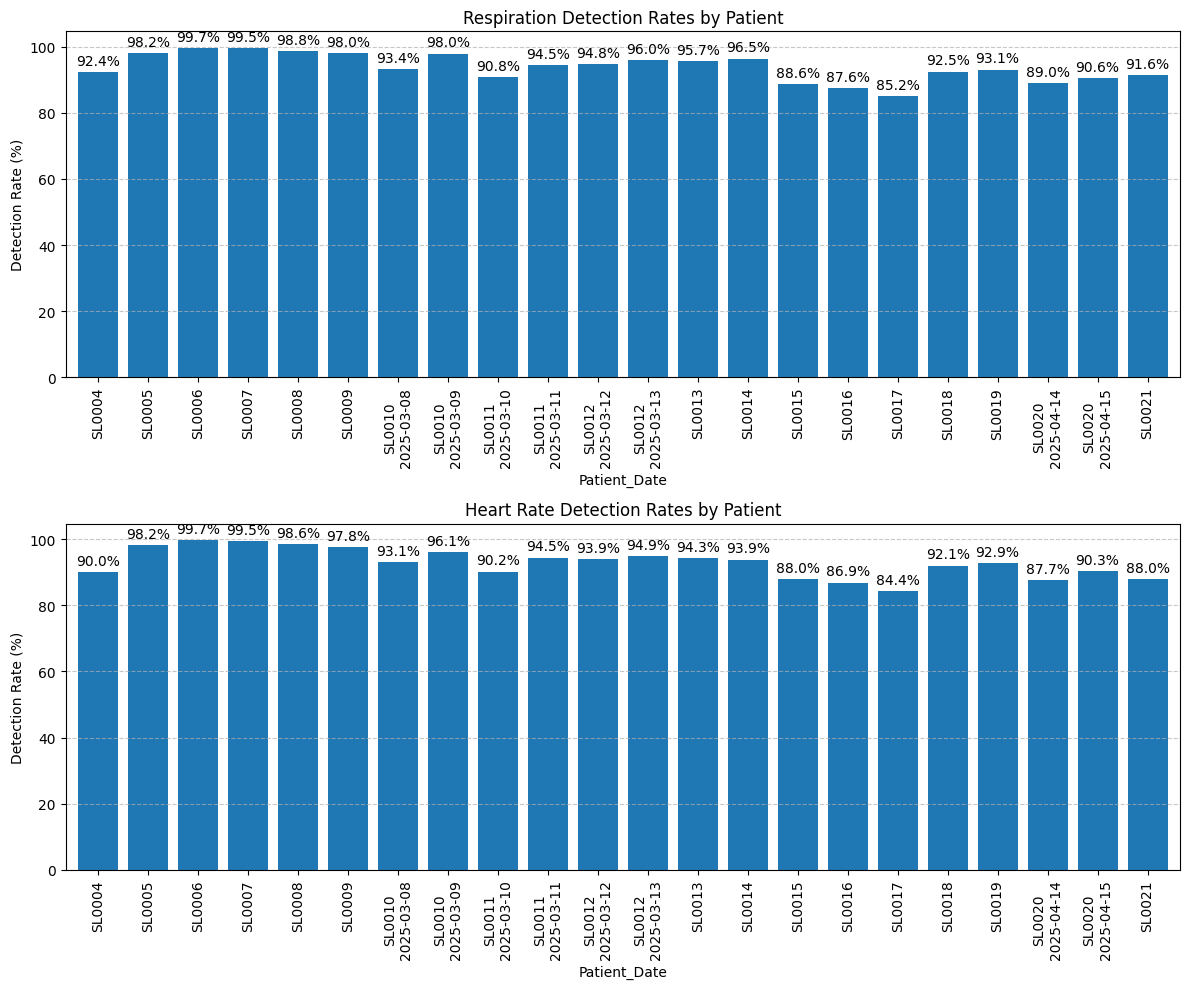

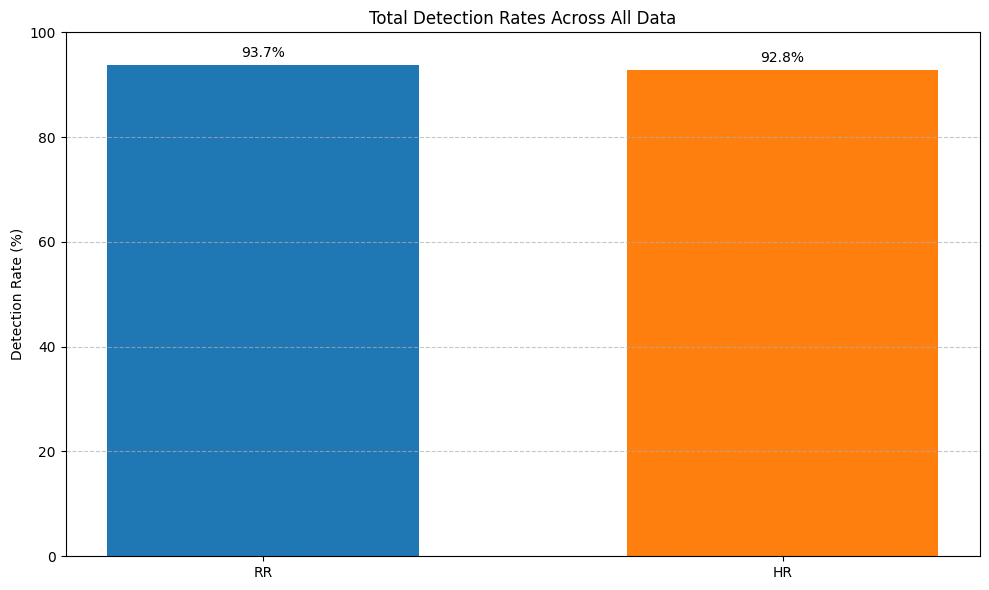

In [31]:
import matplotlib.pyplot as plt

df_resp_new = pd.read_csv('data/new_resp_results.csv')
# Group by patient and session date, calculate detection rates
detection_rates = []
for (patient, start_time), group in df_resp_new.groupby(['PatientStudyName', pd.to_datetime(df_resp_new['StartTime']).dt.date]):
    rates = {
        'Patient': patient,
        'Session Date': start_time,
        'Patient_Date': f"{patient}\n{start_time}" if len(df_resp_new[df_resp_new['PatientStudyName'] == patient]['StartTime'].unique()) > 1 else patient,
        'RR_System v0.1.1': (group['RespDetected'] == 1).mean() * 100,
        'RR_System v0.1.5': (group['RespDetected_new'] == 1).mean() * 100,
        'HR_System v0.1.1': (group['HrDetected'] == 1).mean() * 100,
        'HR_System v0.1.5': (group['HrDetected_new'] == 1).mean() * 100
    }
    detection_rates.append(rates)

df_rates = pd.DataFrame(detection_rates)

def plot_detection_rates(df_rates, plot_old_version=True, exclude_patients=None):
    # Filter out excluded patients if specified
    if exclude_patients is not None:
        df_rates = df_rates[~df_rates['Patient'].isin(exclude_patients)].copy()
        
    # Create figure with subplots for RR and HR
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Determine which columns to plot
    RR_versions_to_plot = ['RR_System v0.1.1', 'RR_System v0.1.5'] if plot_old_version else ['RR_System v0.1.5']
    HR_versions_to_plot = ['HR_System v0.1.1', 'HR_System v0.1.5'] if plot_old_version else ['HR_System v0.1.5']
    
    # Plot Respiration Detection Rates
    df_rates.plot(x='Patient_Date', y=RR_versions_to_plot, 
                  kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Respiration Detection Rates by Patient')
    ax1.set_ylabel('Detection Rate (%)')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xticklabels(df_rates['Patient_Date'], rotation=90)
    if plot_old_version:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax1.get_legend().remove()
    for i in ax1.containers:
        ax1.bar_label(i, fmt='%.1f%%', padding=3)

    # Plot Heart Rate Detection Rates  
    df_rates.plot(x='Patient_Date', y=HR_versions_to_plot,
                  kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Heart Rate Detection Rates by Patient')
    ax2.set_ylabel('Detection Rate (%)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xticklabels(df_rates['Patient_Date'], rotation=90)
    if plot_old_version:
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax2.get_legend().remove()
    for i in ax2.containers:
        ax2.bar_label(i, fmt='%.1f%%', padding=3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate figure for total detection rates
    fig, ax3 = plt.subplots(figsize=(10, 6))
    
    # Calculate overall detection rates
    total_rates = {
        'RR': (df_resp_new['RespDetected_new'] == 1).mean() * 100,
        'HR': (df_resp_new['HrDetected_new'] == 1).mean() * 100
    }
    
    categories = ['RR', 'HR']
    values = [total_rates['RR'], total_rates['HR']]
    colors = ['#1f77b4', '#ff7f0e']    
    bars = ax3.bar(categories, values, width=0.6, color=colors)
    
    ax3.set_title('Total Detection Rates Across All Data')
    ax3.set_ylabel('Detection Rate (%)')
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')
    ax3.set_ylim([0, 100])
    plt.tight_layout()
    plt.show()

# Plot only new version excluding specified patients
patients_to_exclude = []  # Replace with actual patient IDs to exclude
plot_detection_rates(df_rates, plot_old_version=False, exclude_patients=patients_to_exclude)


# RR and HR accuracy #


In [ ]:
edf_file = 'data/SL0004_20250226/20250226-0004.edf'
raw = read_raw_edf(edf_file, preload=True)


### Plot reference signals and save them ###

Processing folders:   0%|          | 0/28 [00:00<?, ?it/s]

Processing folder: data/SL0012_20250312
Extracting EDF parameters from /Users/yaelalon/SleepLabProcessing/data/SL0012_20250312/20250312-0012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5522799  =      0.000 ... 27613.995 secs...


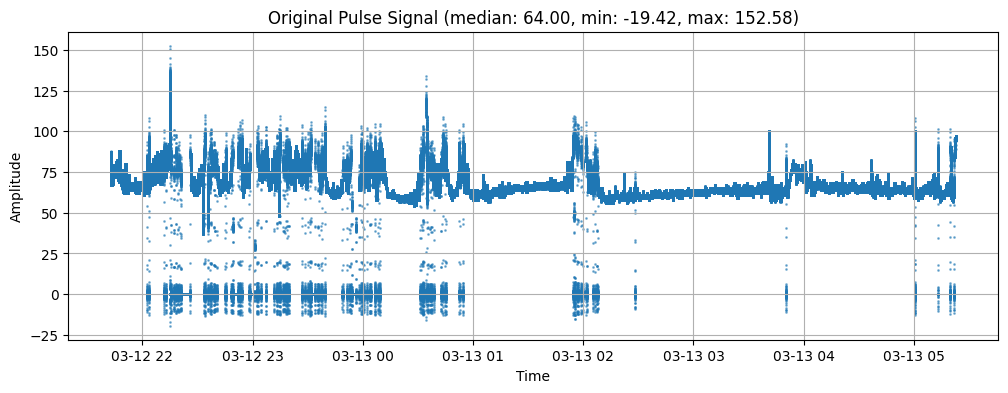

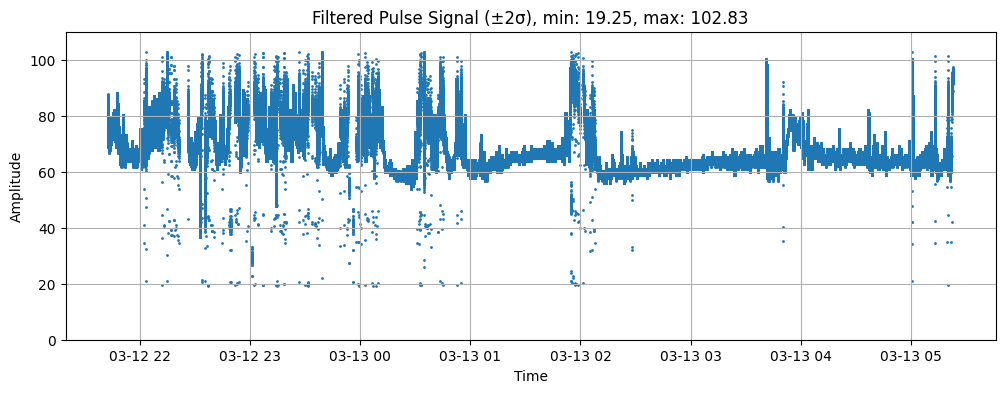

Data saved to: data/SL0012_20250312/pulse_data.csv
Removed 514271 points as outliers (9.31%)


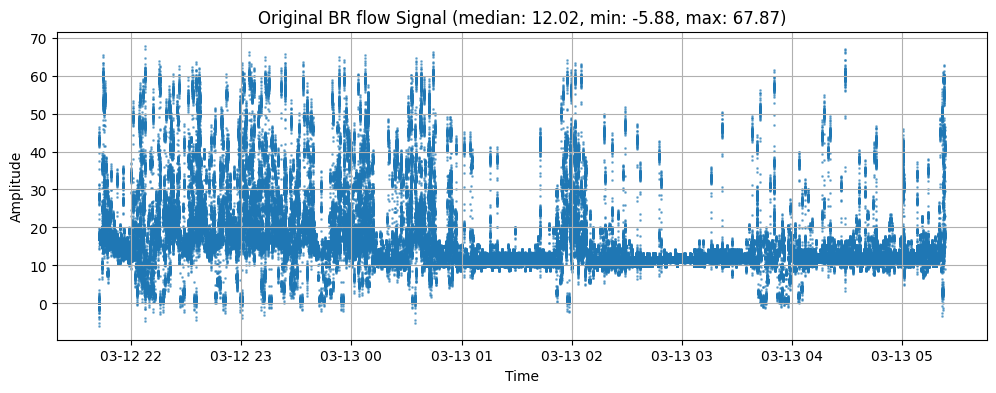

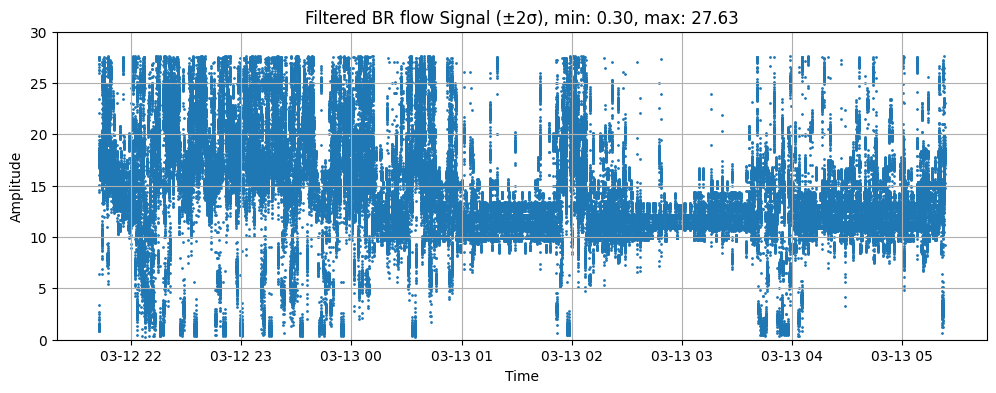

Processing folders: 100%|██████████| 28/28 [02:06<00:00,  4.51s/it]

Data saved to: data/SL0012_20250312/br_flow_data.csv
Removed 225638 points as outliers (4.09%)


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mne.io import read_raw_edf
from tqdm import tqdm
from datetime import datetime, timedelta
import glob

def process_signal(edf_raw, channel_name, folder_path, std_th=2, y_min=None, y_max=None):
    # Get the data for specified channel
    signal_data = edf_raw.get_data(channel_name)[0]

    # Create dataframe with original data and exact timestamps
    start_time = edf_raw.info['meas_date']
    df = pd.DataFrame({
        'time': [start_time + timedelta(seconds=t) for t in edf_raw.times],
        'original_signal': signal_data
    })

    # Calculate mean and standard deviation
    median = np.median(df['original_signal'])
    mean = np.mean(df['original_signal'])
    std = np.std(df['original_signal'])
    
    # Filter out values exceeding std_th standard deviations from median
    df['filtered_signal'] = df['original_signal'].where(
        abs(df['original_signal'] - mean) <= std_th * std, np.nan)

    # Plot original signal with dots instead of lines
    plt.figure(figsize=(12, 4))
    plt.scatter(df['time'], df['original_signal'], alpha=0.5, s=1)
    plt.title(f'Original {channel_name} Signal (median: {median:.2f}, min: {df["original_signal"].min():.2f}, max: {df["original_signal"].max():.2f})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Plot filtered signal with dots instead of lines
    plt.figure(figsize=(12, 4))
    plt.scatter(df['time'], df['filtered_signal'], s=1)
    plt.title(f'Filtered {channel_name} Signal (±{std_th}σ), min: {df["filtered_signal"].min():.2f}, max: {df["filtered_signal"].max():.2f}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

    # Save original and filtered data to CSV
    df.to_csv(f'{folder_path}/{channel_name.lower().replace(" ","_")}_data.csv', index=False)

    print(f"Data saved to: {folder_path}/{channel_name.lower().replace(' ','_')}_data.csv")
    total_points = len(df['filtered_signal'])
    removed_points = df['filtered_signal'].isna().sum()
    percentage_removed = (removed_points / total_points) * 100
    print(f"Removed {removed_points} points as outliers ({percentage_removed:.2f}%)")

# Iterate over all folders in the data directory
data_dir = 'data'
for folder in tqdm(os.listdir(data_dir), desc="Processing folders"):
    if folder != 'SL0012_20250312':
        continue
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):        
        print('Processing folder:', folder_path)
        edf_file = glob.glob(os.path.join(folder_path, '*.edf'))
        #edf_file = edf_file[0]
        if len(edf_file) == 0:
            print(f"No edf file found in {folder_path}")
            continue
        
        edf_file = edf_file[0]
        patient = edf_file.split('/')[-2]
        if os.path.exists(edf_file):
            edf_raw = read_raw_edf(edf_file, preload=True)
            process_signal(edf_raw, 'Pulse', folder_path, std_th=2, y_min=0, y_max=110)
            process_signal(edf_raw, 'BR flow', folder_path, std_th=2, y_min=0, y_max=30)


### Evaluate ref value per holosis signal ###

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_signal_time(db_manager, study):
    query = f"""
    SELECT RadarSignal.SessionID, RadarSignal.SessionSignalID, RadarSignal.StartTime as RadarStartTime from RadarSignal
    JOIN Session ON RadarSignal.SessionID = Session.ID
    JOIN Patient ON Session.PatientID = Patient.ID
    JOIN Study ON Patient.StudyID = Study.ID
    WHERE Study.Name = '{study}'
    """
    return pd.read_sql(query, db_manager.engine)

# Load new device results
study = 'Sleep Lab'
holosis_results = pd.read_csv('data/new_resp_results.csv')
radar_signal_time = fetch_signal_time(db_manager, study)
holosis_results = pd.merge(holosis_results, radar_signal_time, on=['SessionSignalID', 'SessionID'], how='left')
results_with_ref = holosis_results.copy()

def compute_ref_per_signal(data, signal_time):
    data['time'] = pd.to_datetime(data['time'], format='mixed').dt.tz_localize(None)
    start_time = signal_time
    end_time = signal_time + pd.Timedelta(seconds=60)
    interval_data = data[(data['time'] >= start_time) & (data['time'] < end_time)]
    ref_value = interval_data['filtered_signal'].median() if len(interval_data) > 0 else None
    return ref_value

def process_signal_id(session_signal_id, group, session_id, hr_data, rr_data):
    index = results_with_ref[(results_with_ref['SessionSignalID'] == session_signal_id) & \
        (results_with_ref['SessionID'] == session_id)].index[0]
    row = group[group['SessionSignalID'] == session_signal_id]
    signal_time = pd.to_datetime(row['RadarStartTime'].iloc[0]).tz_localize(None)  # Remove timezone info
    
    hr_ref = compute_ref_per_signal(hr_data, signal_time)
    rr_ref = compute_ref_per_signal(rr_data, signal_time)
    
    # Use lock when updating the shared dataframe
    with results_lock:
        results_with_ref.loc[index, 'ReferenceHR'] = hr_ref/60 if hr_ref is not None else None
        results_with_ref.loc[index, 'ReferenceRR'] = rr_ref/60 if rr_ref is not None else None

# Iterate over patient+date combinations
for (patient, date, session_id), group in holosis_results.groupby(['PatientStudyName', holosis_results['StartTime'], 'SessionID']):
    session_date = pd.to_datetime(date).strftime('%Y%m%d')
    session_folder = f'{patient}_{session_date}'
    local_path = f'data/{session_folder}'
    rr_data = pd.read_csv(f'{local_path}/br_flow_data.csv')
    hr_data = pd.read_csv(f'{local_path}/pulse_data.csv')
    import threading
    from concurrent.futures import ThreadPoolExecutor
    from threading import Lock
    
    # Create a lock for thread-safe updates to results_with_ref
    results_lock = Lock()
    
    # Use ThreadPoolExecutor to process signals in parallel
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for session_signal_id in group['SessionSignalID']:
            futures.append(executor.submit(
                process_signal_id, 
                session_signal_id, 
                group, 
                session_id, 
                hr_data, 
                rr_data
            ))
        
        # Wait for all tasks to complete
        for future in futures:
            future.result()
            
    # Save results after all processing is complete
    results_with_ref.to_csv('data/results_with_ref.csv', index=False)

/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaela

## Accuracy ##

### Plot trajectories - ours again the reference

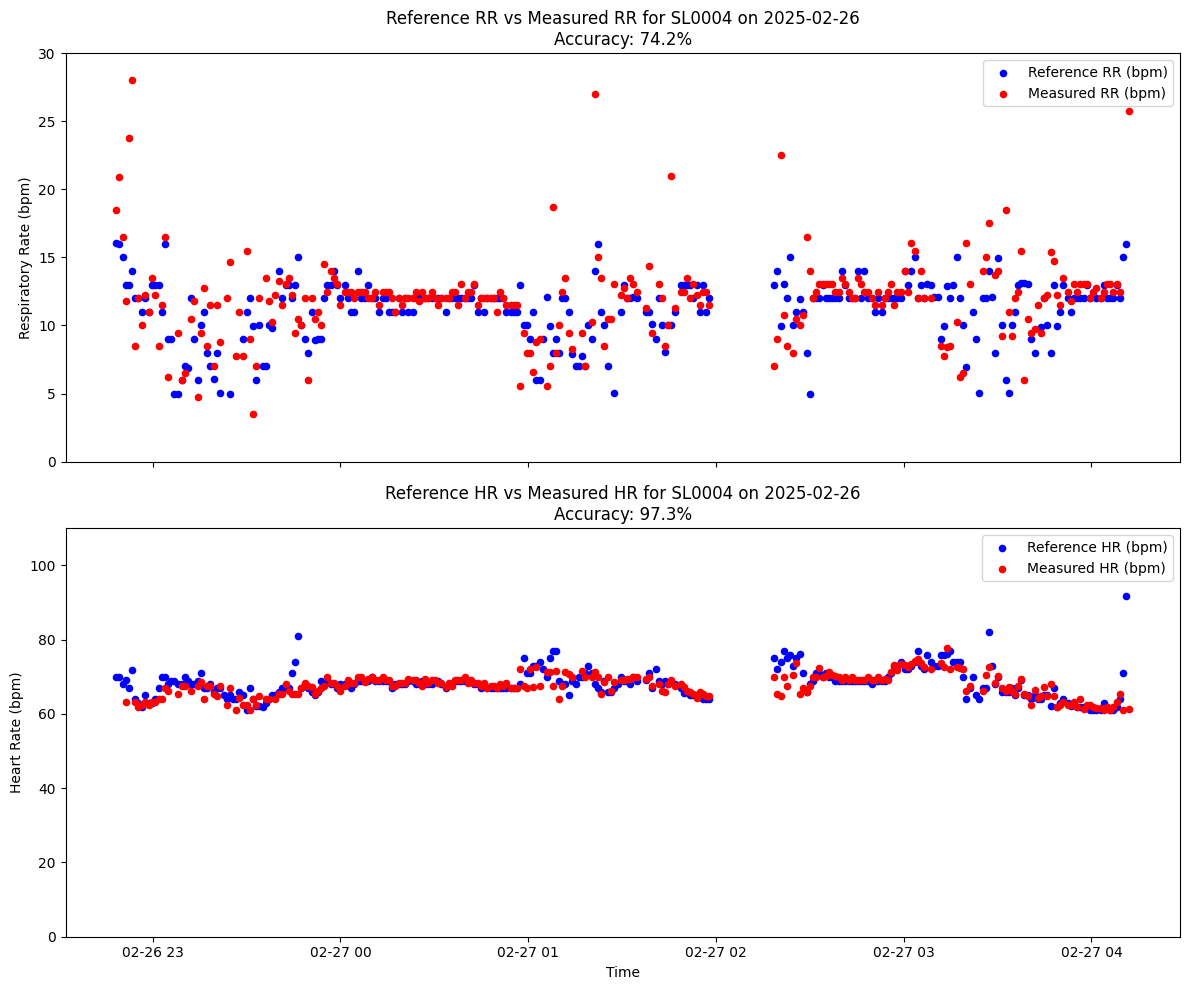

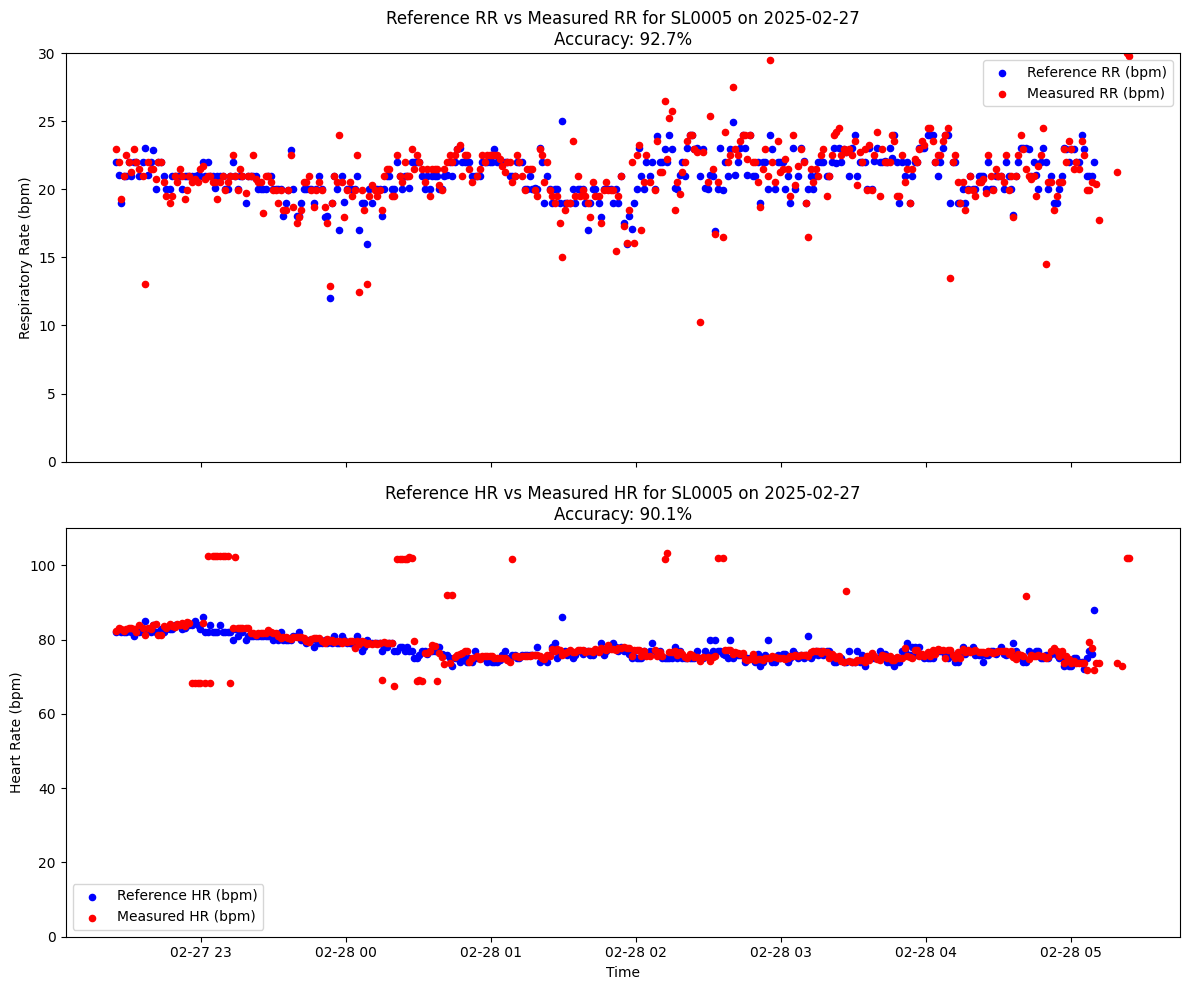

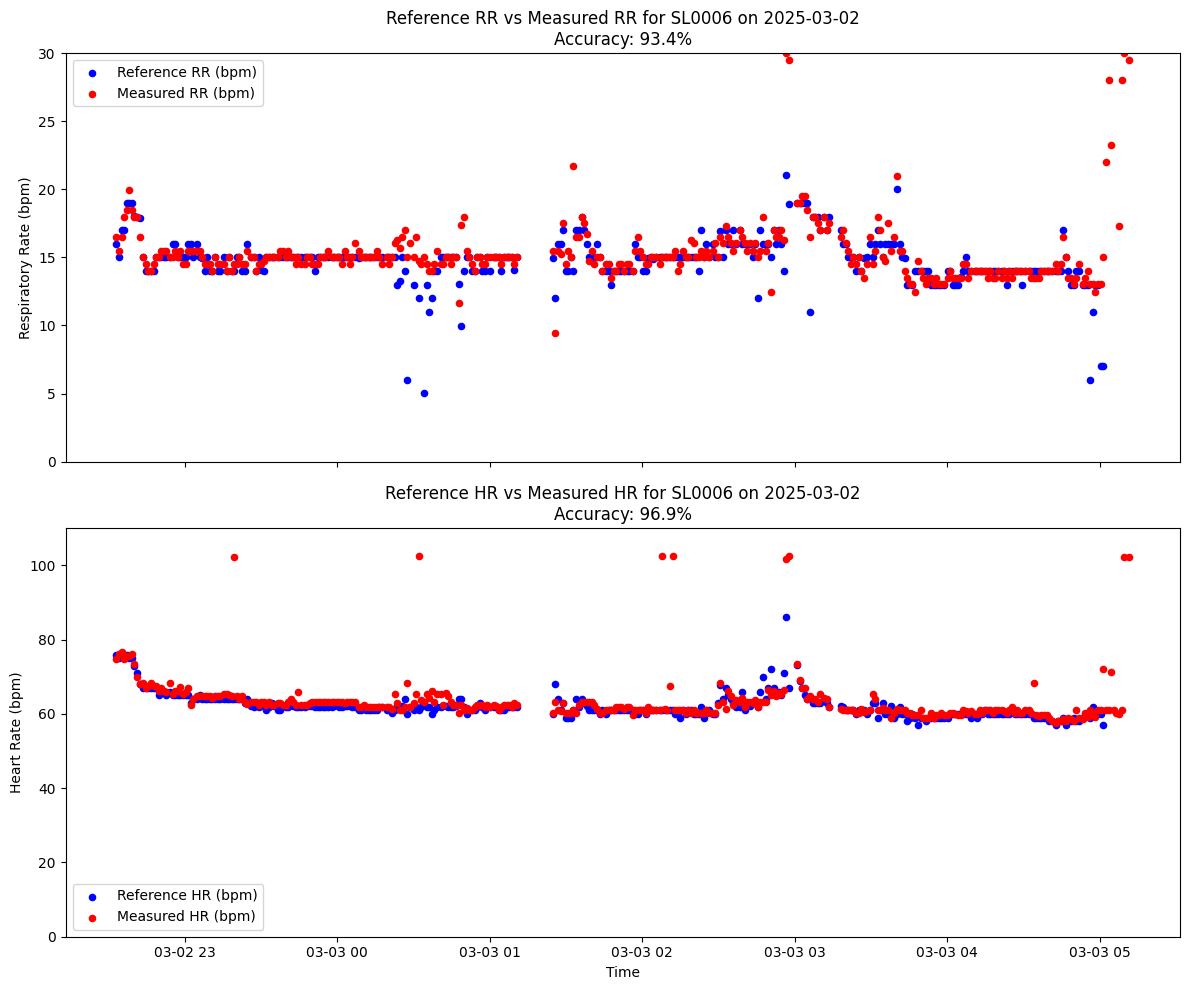

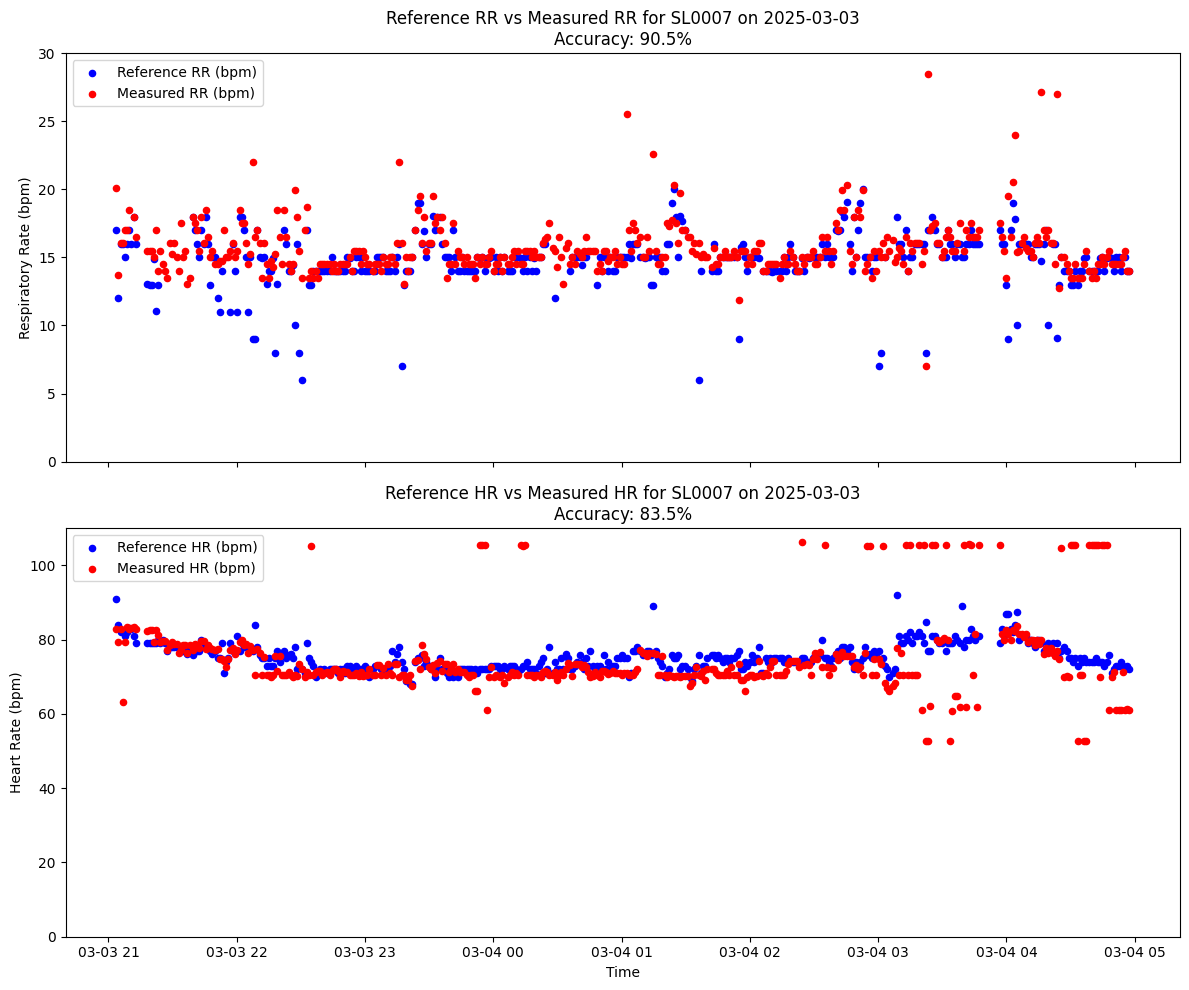

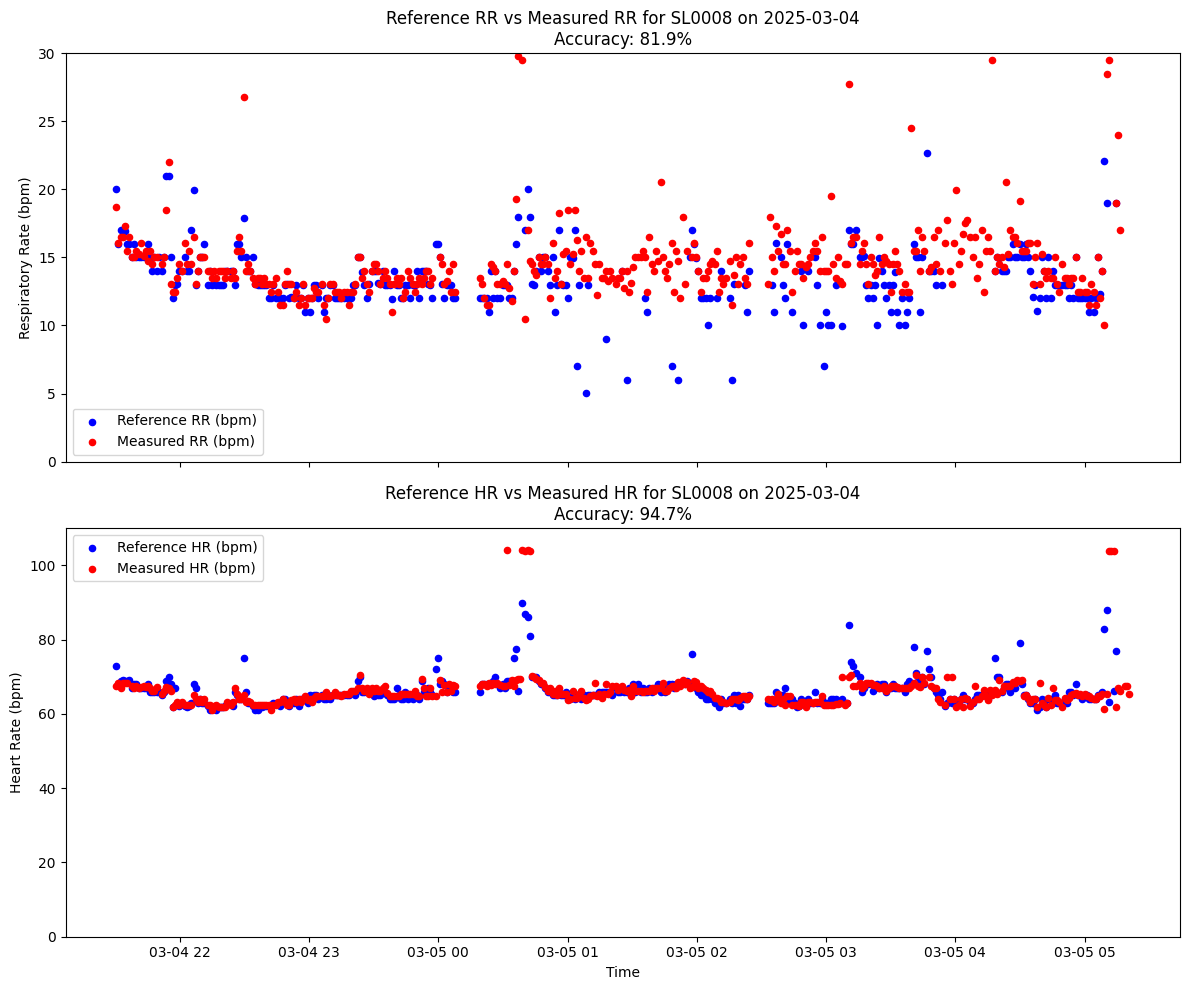

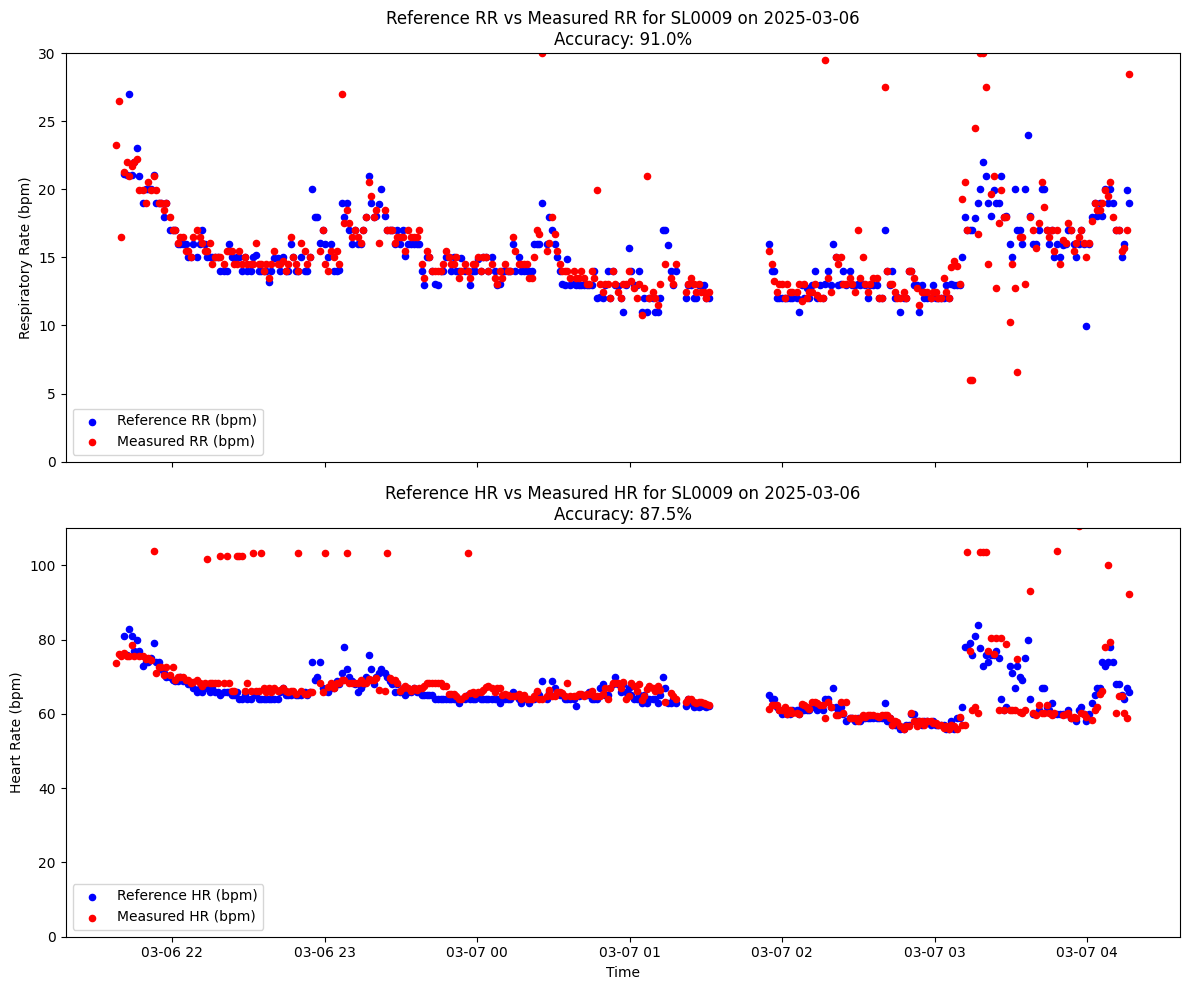

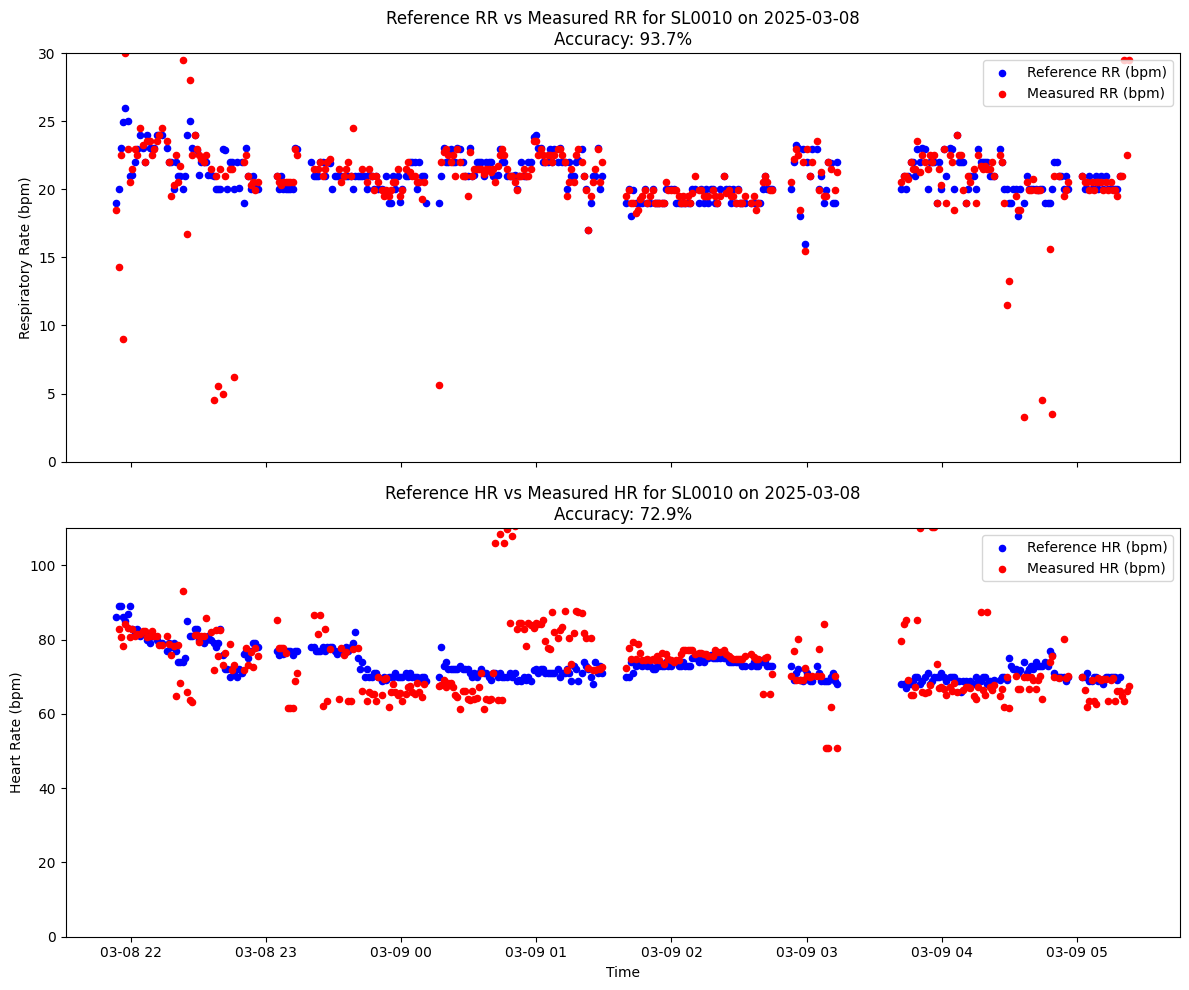

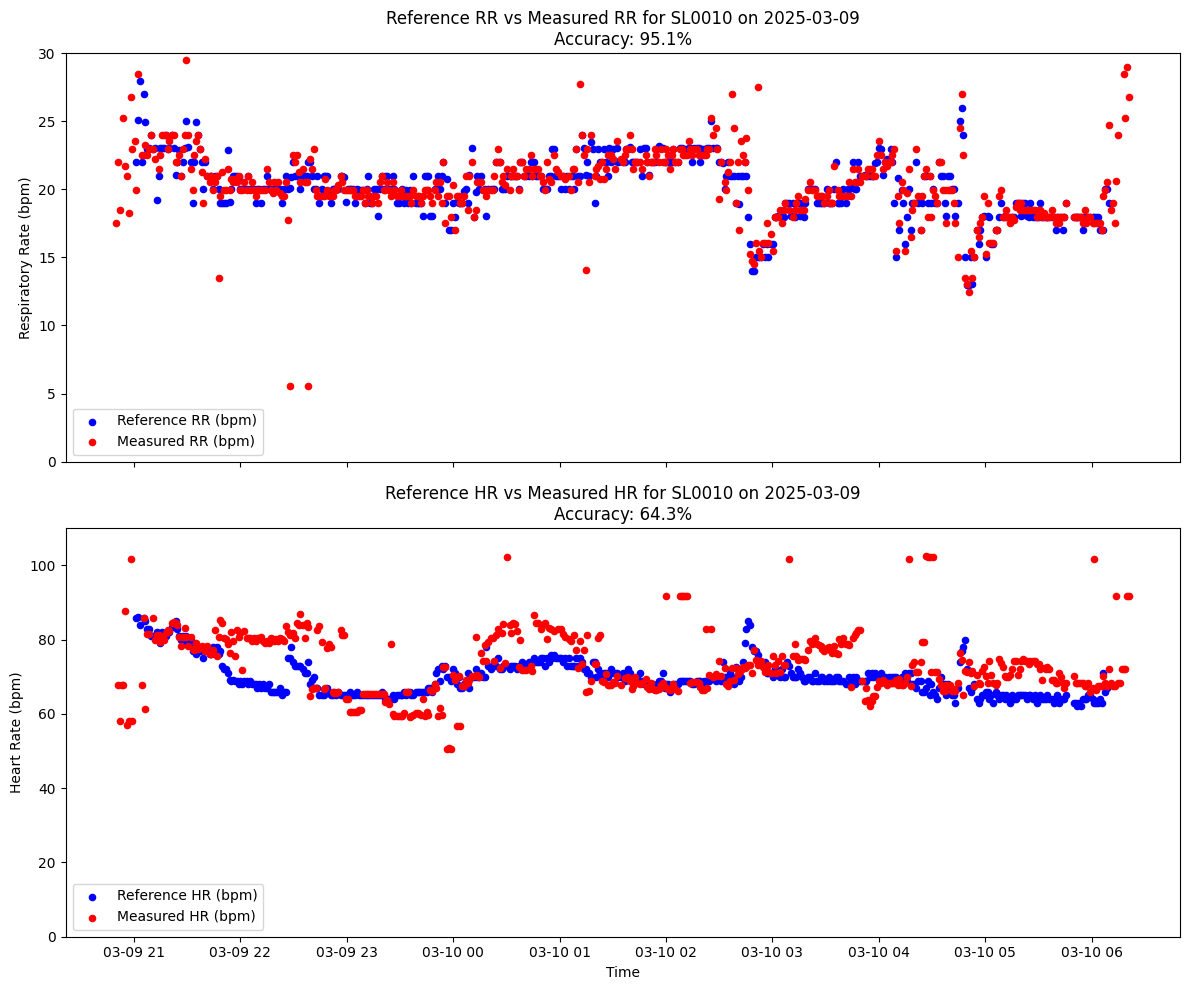

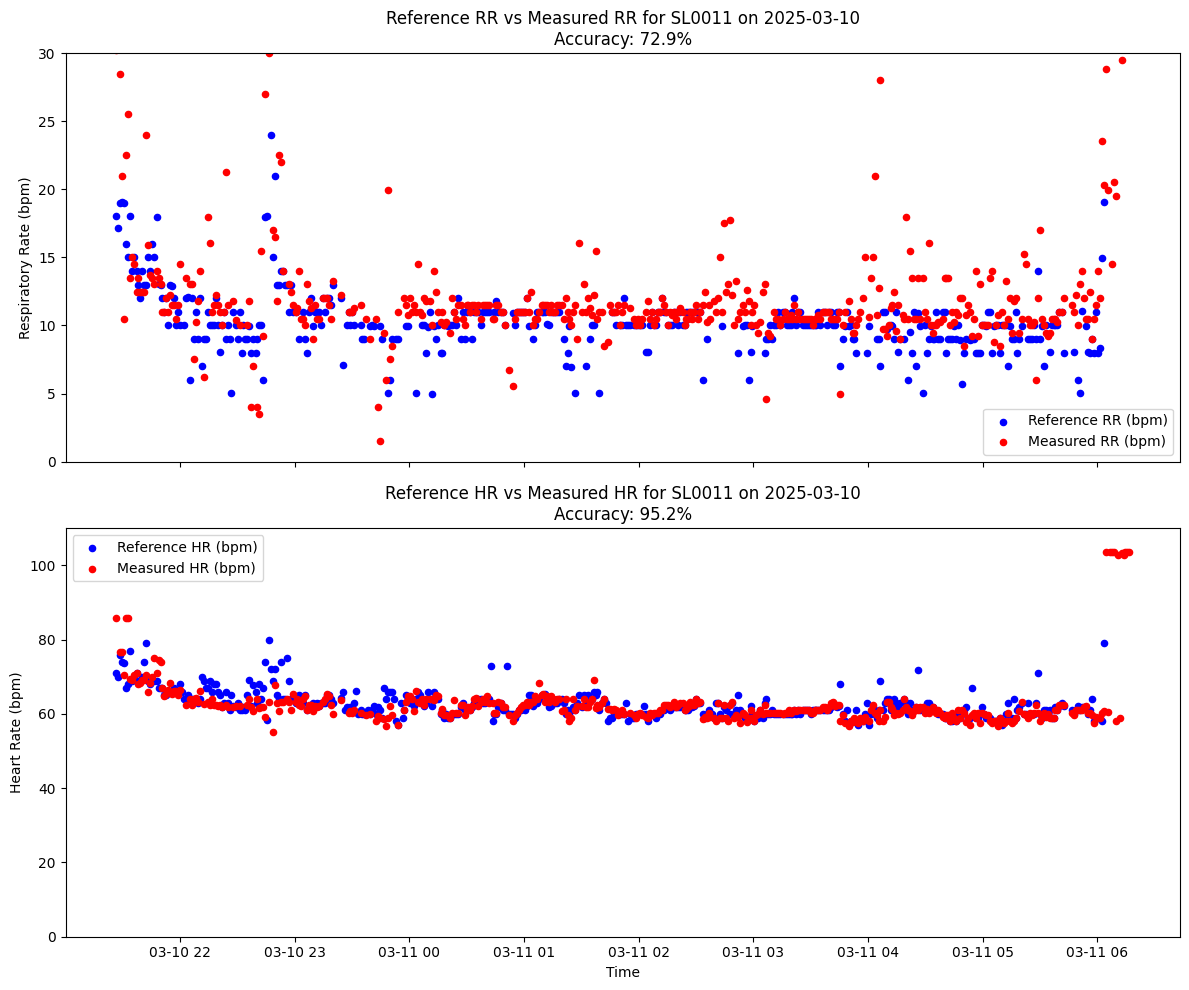

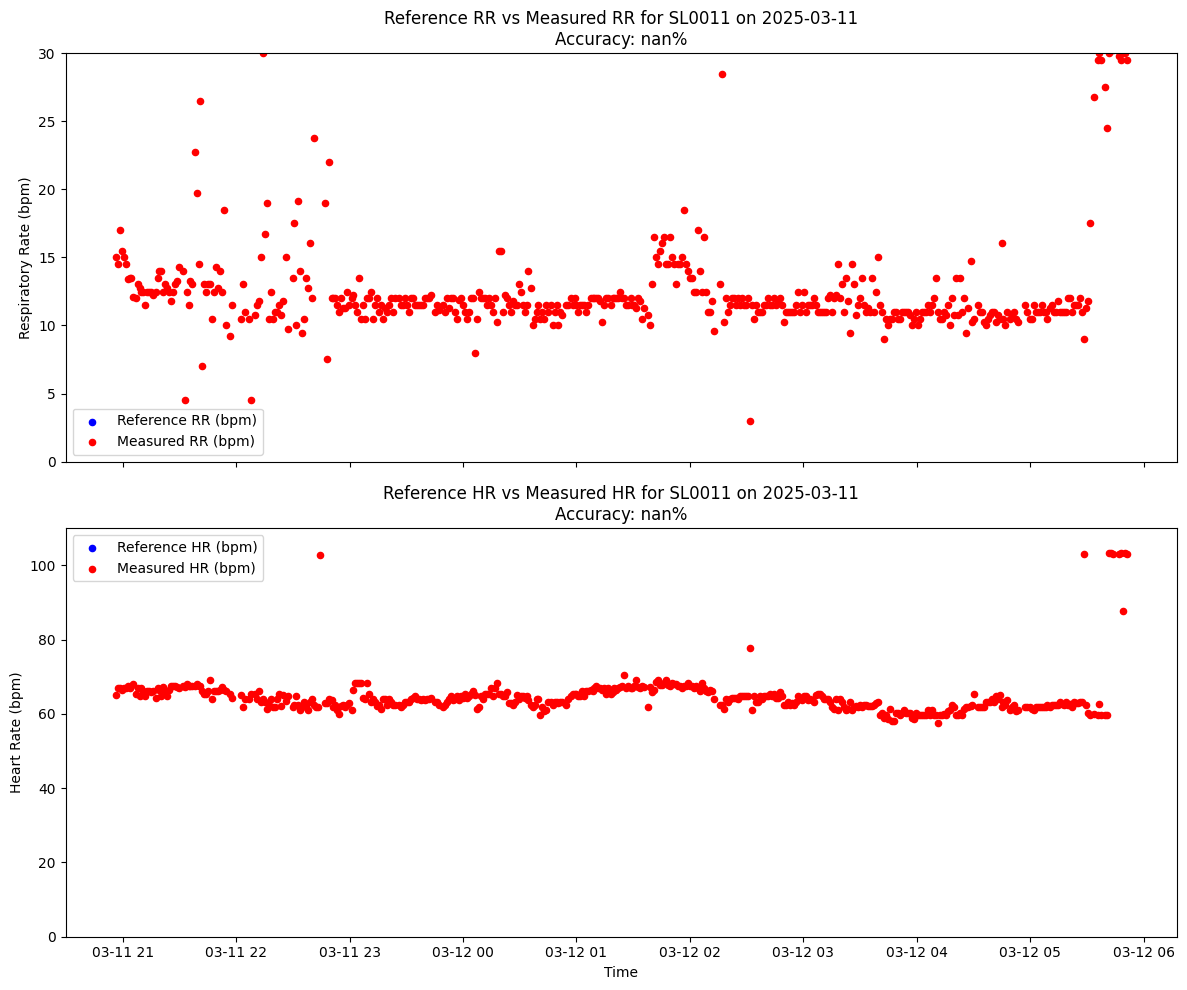

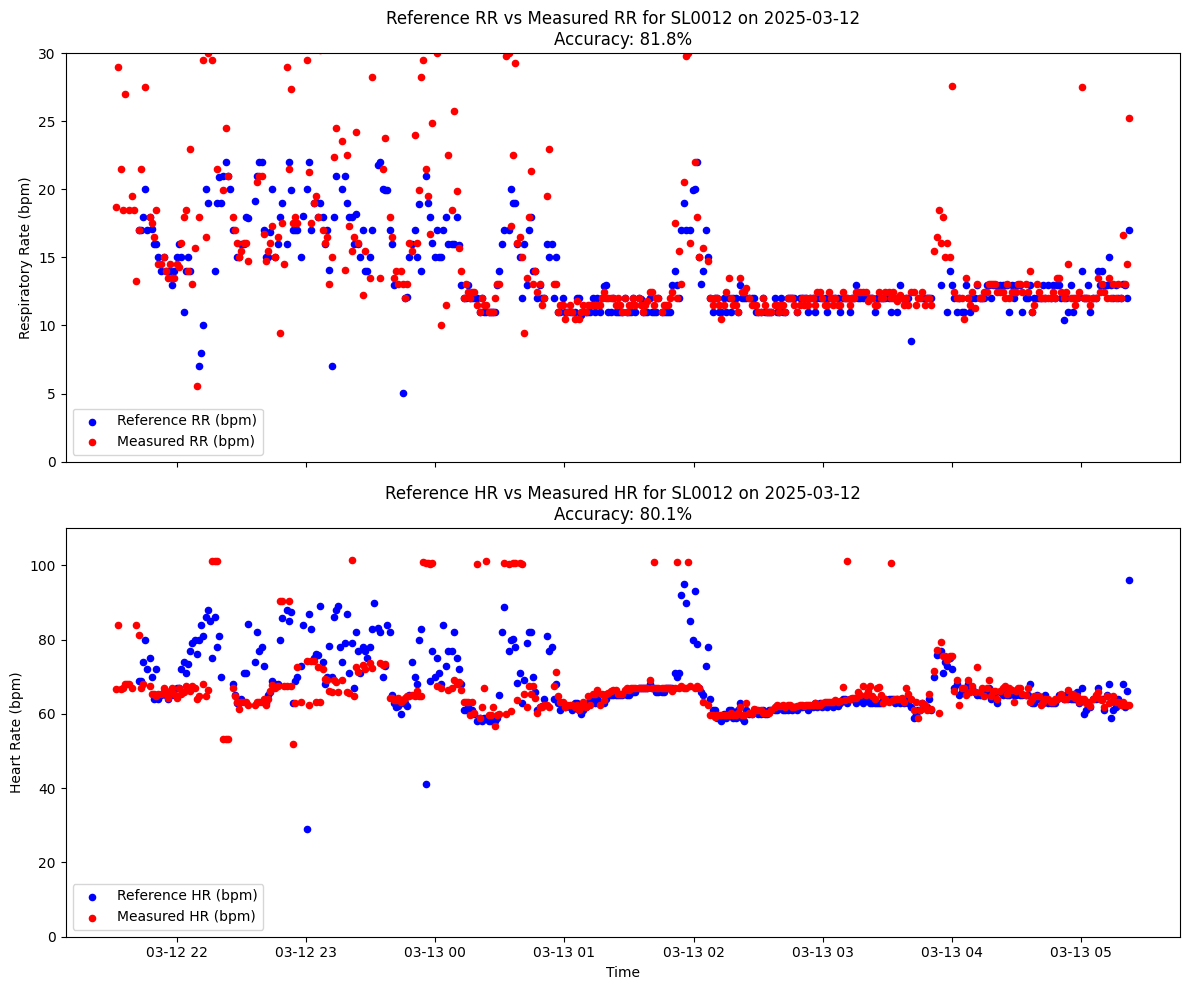

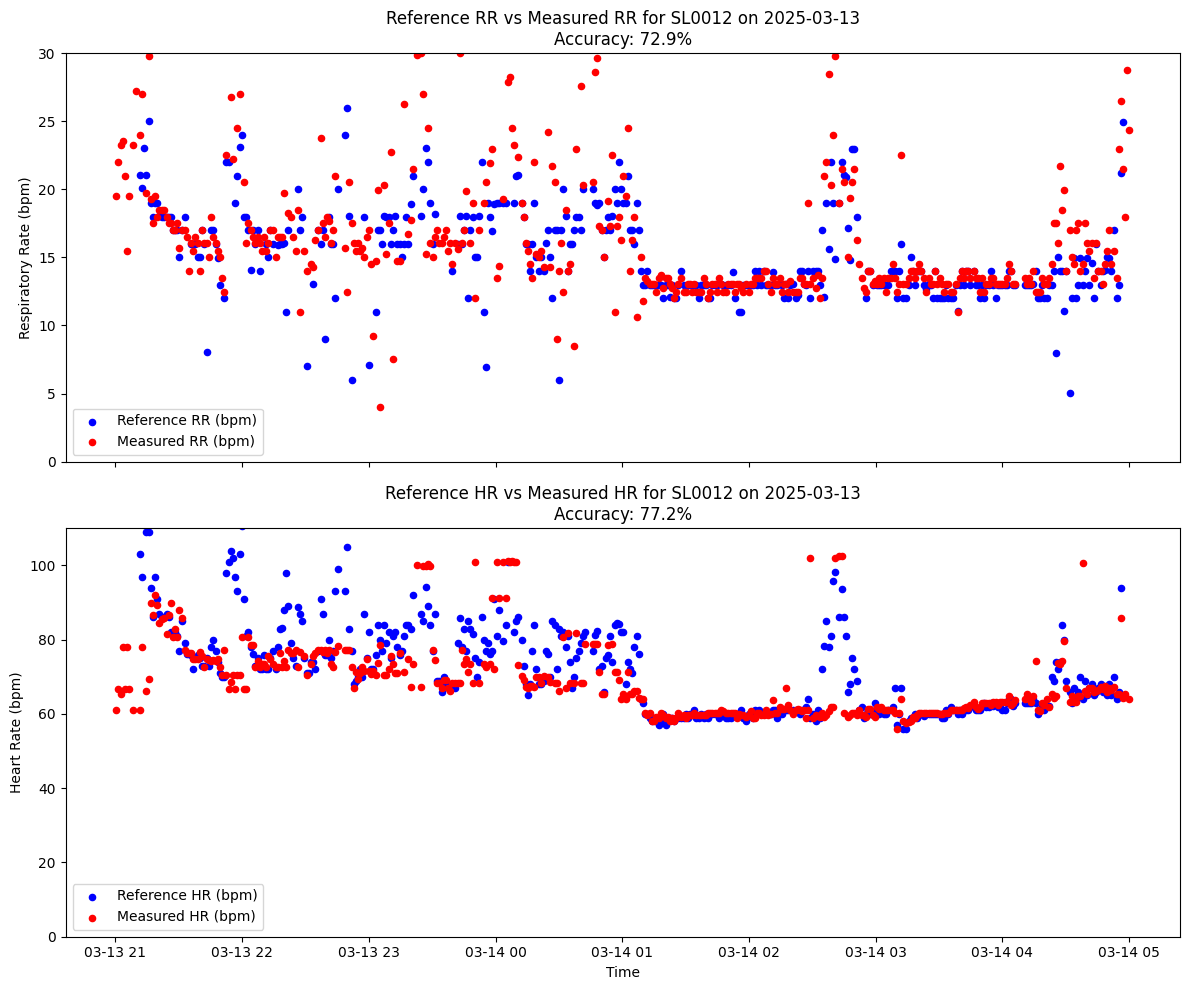

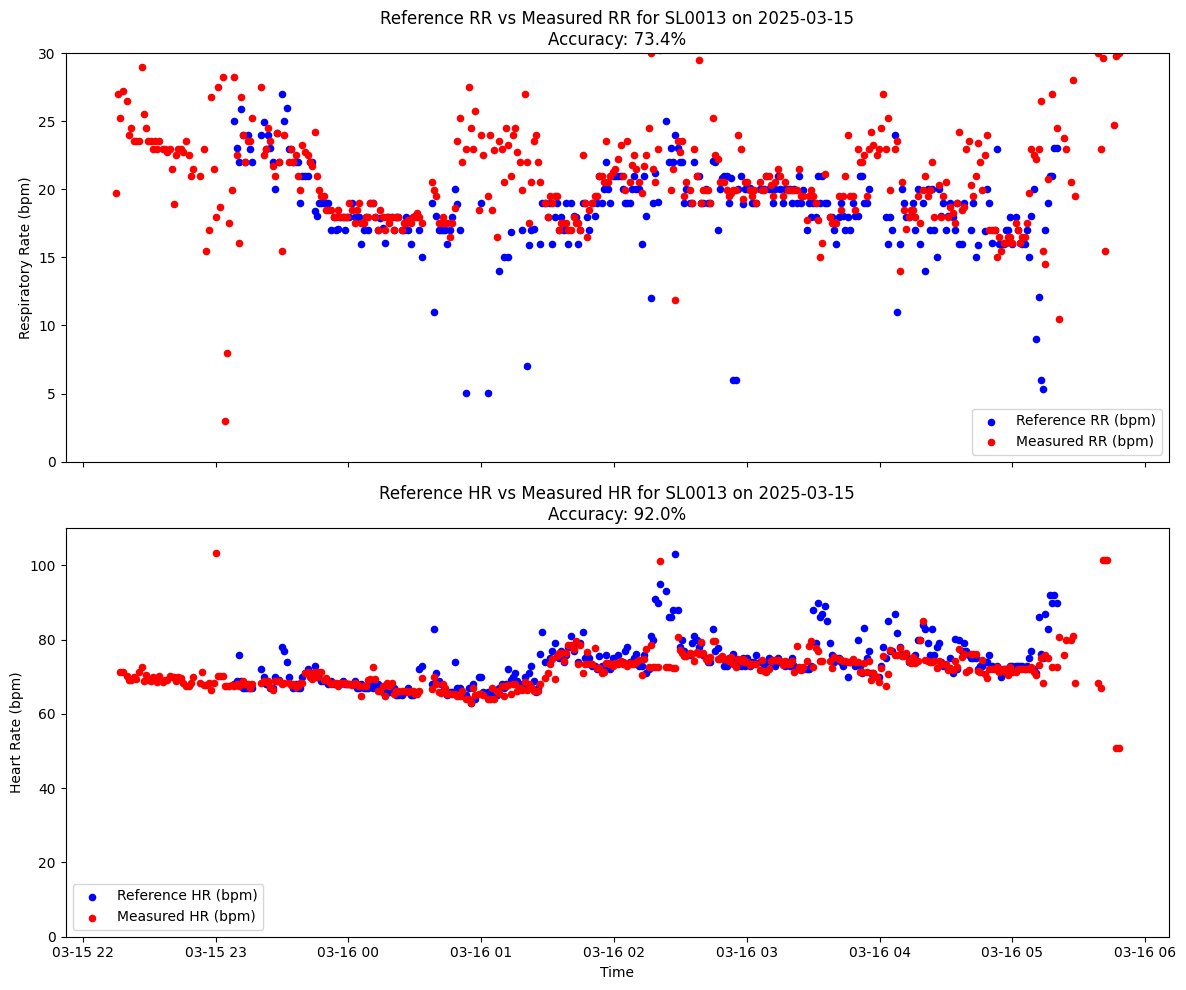

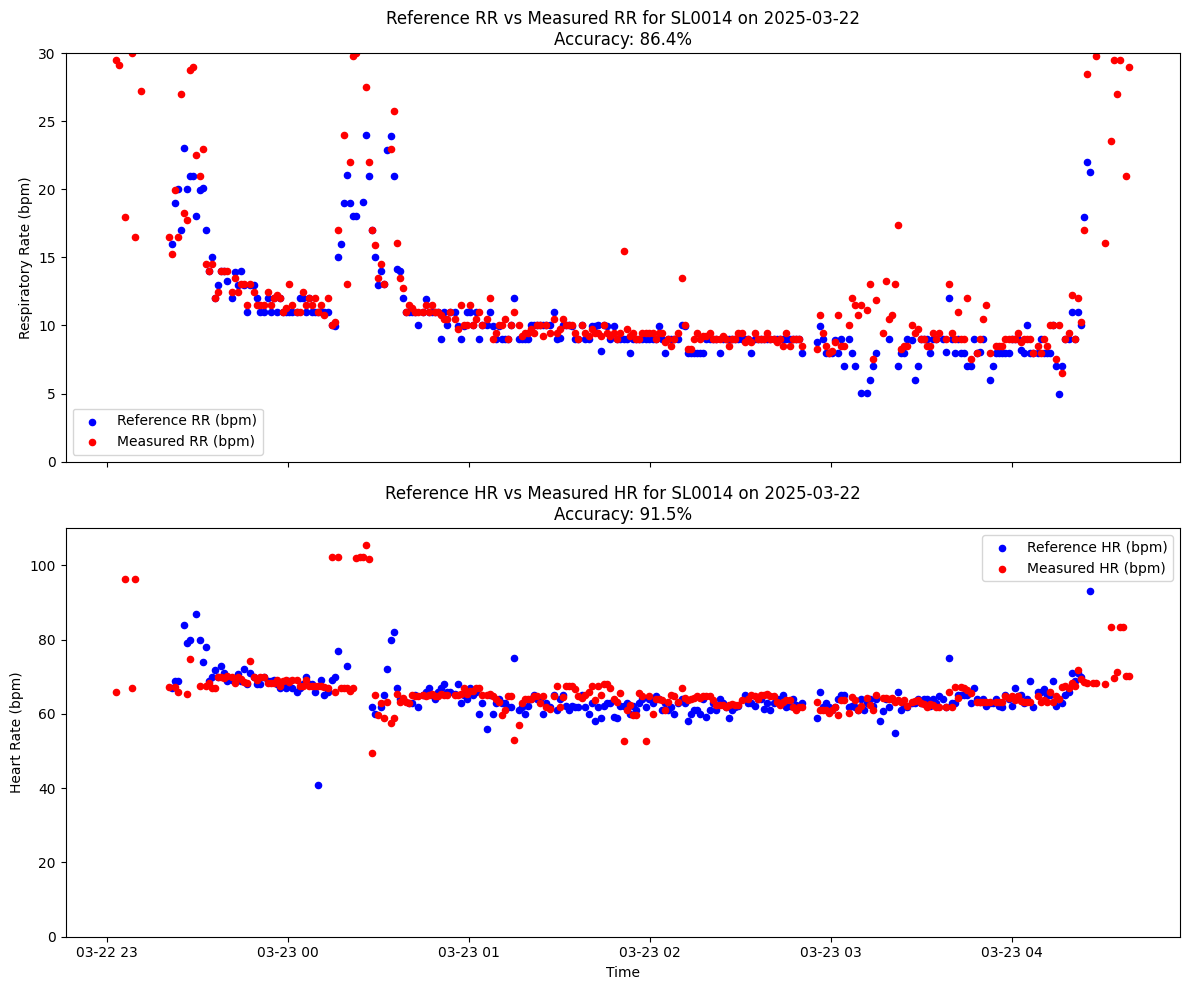

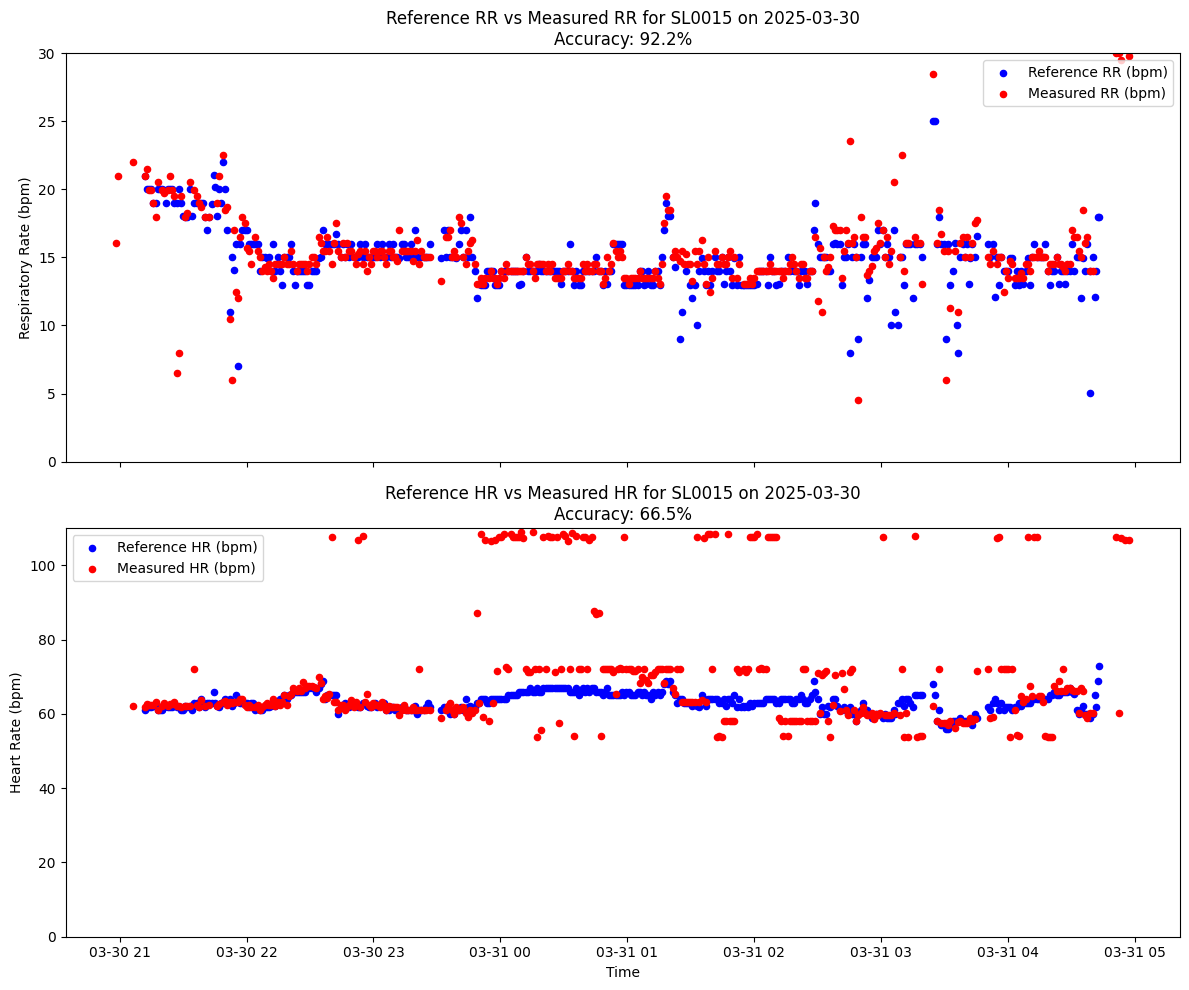

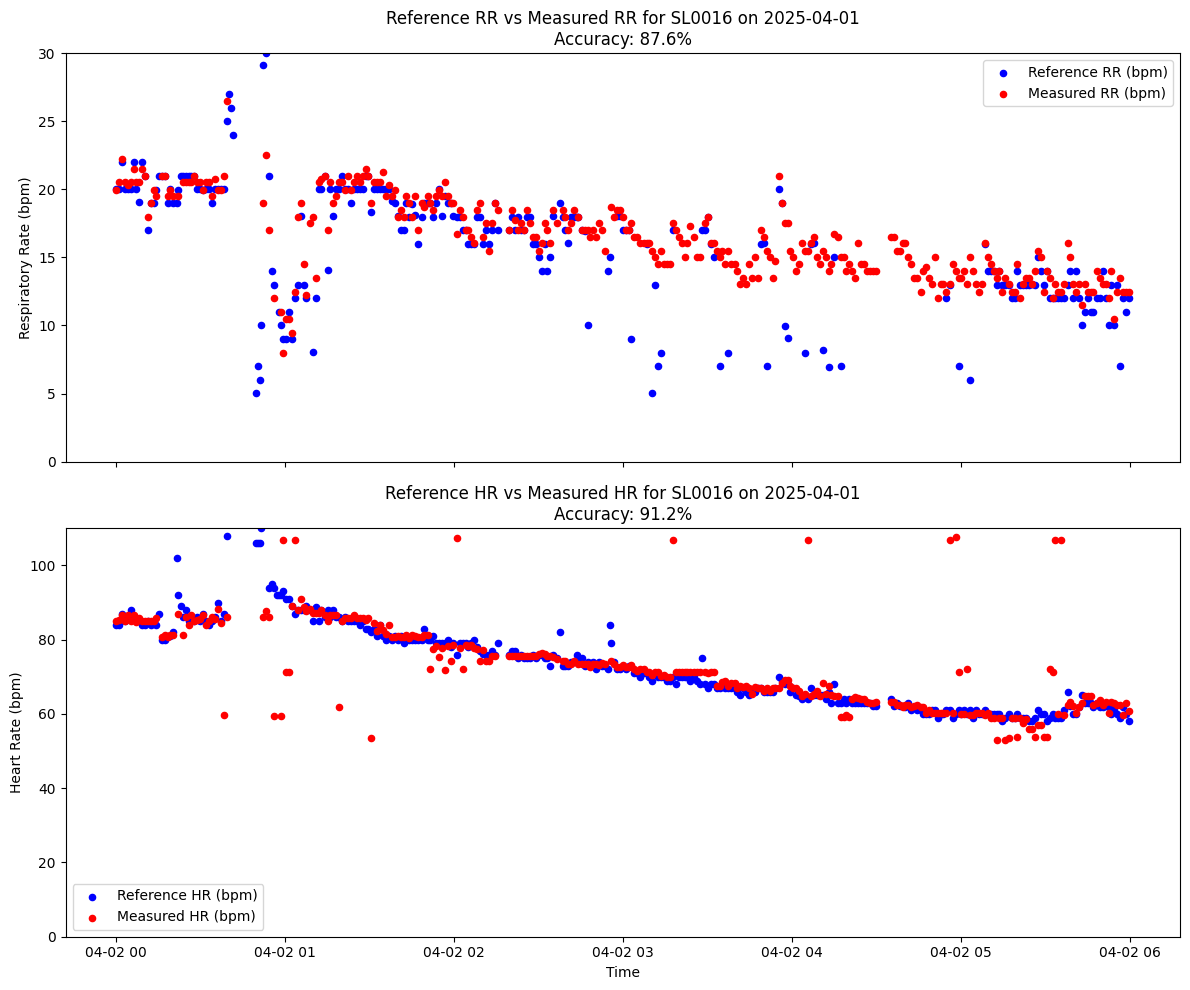

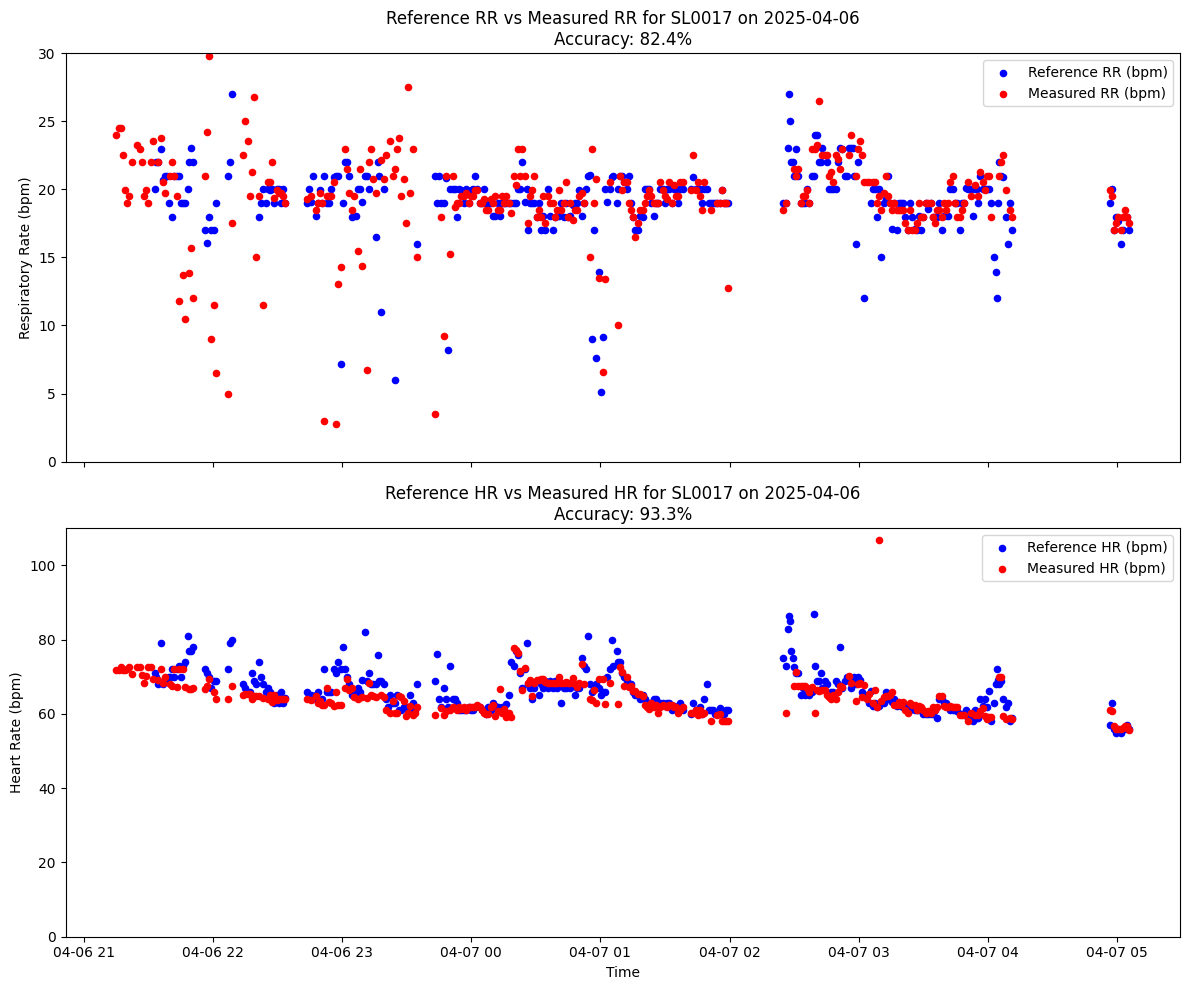

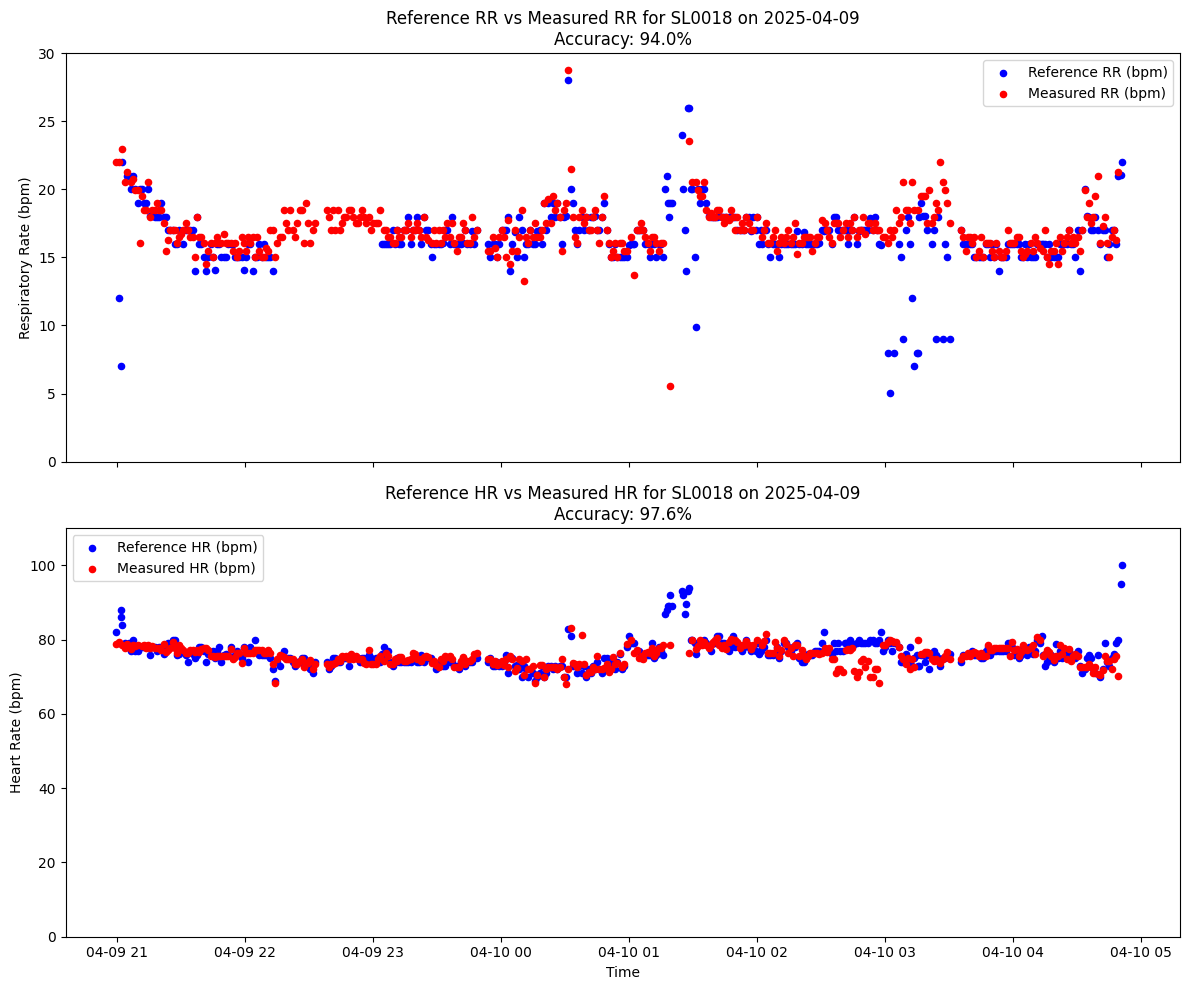

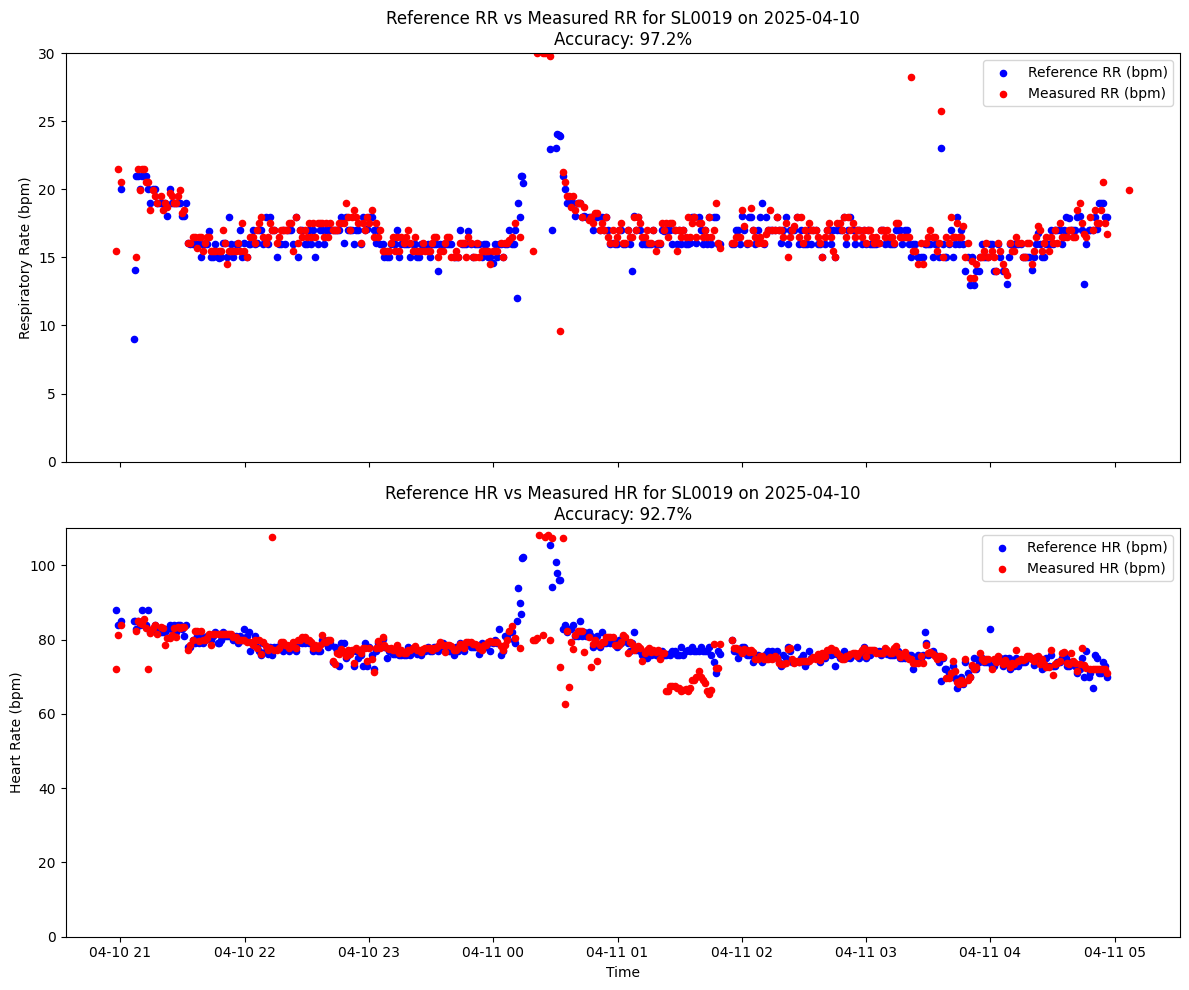

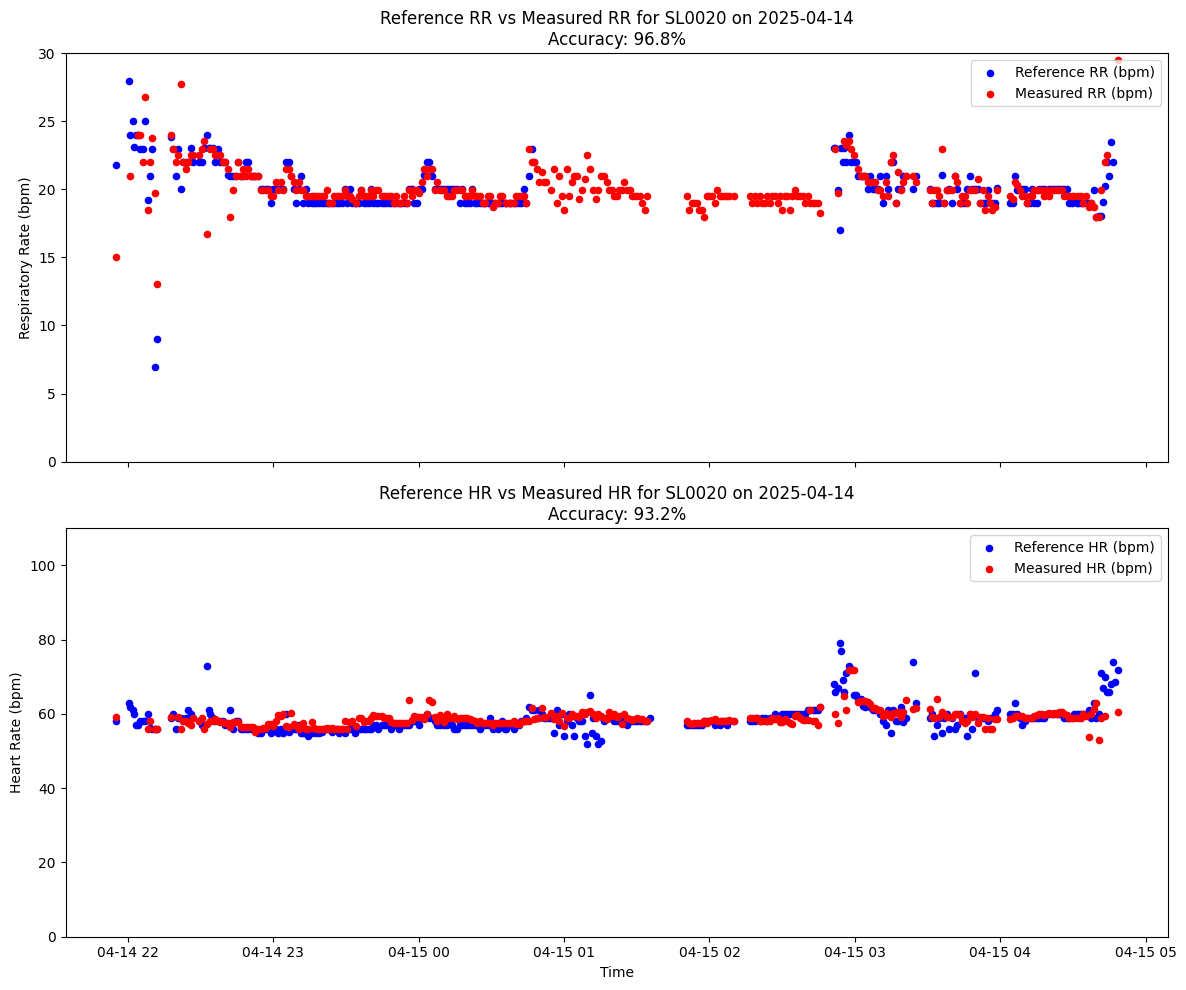

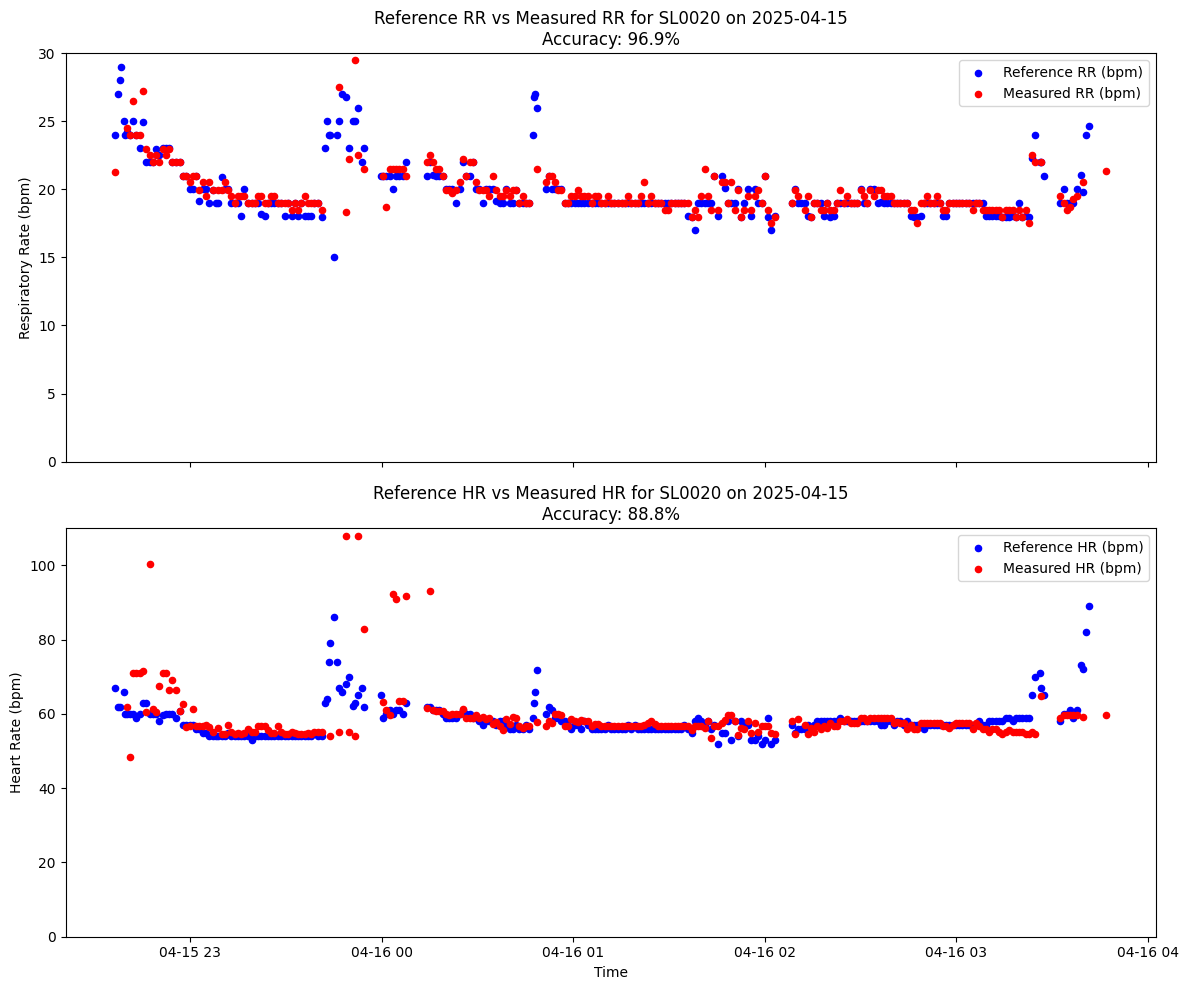

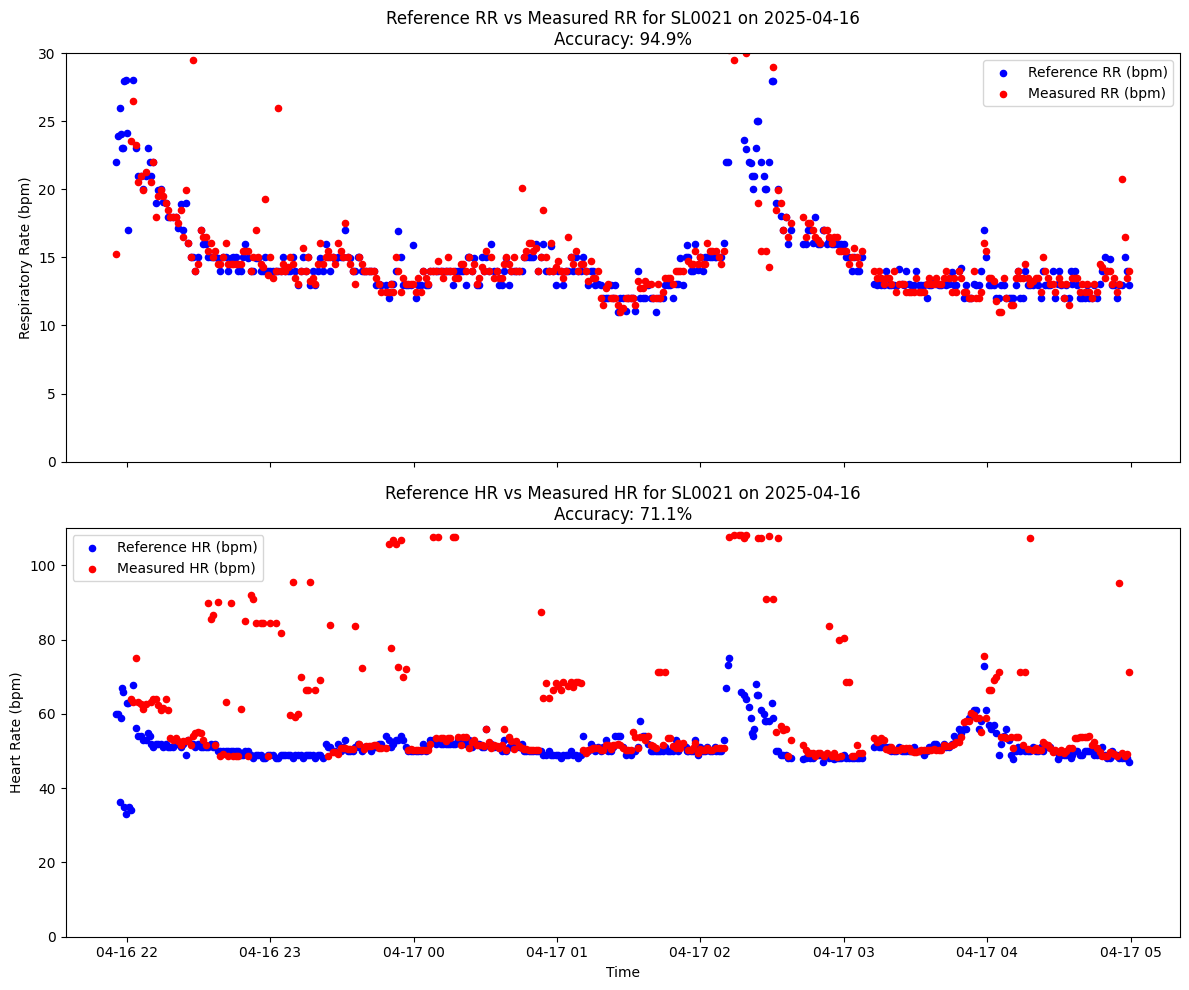

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Define criteria for rr and hr using bpm values, ignoring NaN values
def is_rr_accurate(measured_rr_bpm, reference_rr_bpm):
    if pd.isna(measured_rr_bpm) or pd.isna(reference_rr_bpm):
        return None
    return abs(measured_rr_bpm - reference_rr_bpm) < 2 or abs((measured_rr_bpm - reference_rr_bpm) / reference_rr_bpm) < 0.1

def is_hr_accurate(measured_hr_bpm, reference_hr_bpm):
    if pd.isna(measured_hr_bpm) or pd.isna(reference_hr_bpm):
        return None
    return abs(measured_hr_bpm - reference_hr_bpm) < 5 or abs((measured_hr_bpm - reference_hr_bpm) / reference_hr_bpm) < 0.1


# Load the data
results_with_ref = pd.read_csv('data/results_with_ref.csv')

# Filter out data points for SL0016 after 6 AM
results_with_ref['RadarStartTime'] = pd.to_datetime(results_with_ref['RadarStartTime'])
mask = ~((results_with_ref['PatientStudyName'] == 'SL0016') & 
         (results_with_ref['RadarStartTime'].dt.hour >= 6))
results_with_ref = results_with_ref[mask]

# Multiply the results by 60 to get bpm
results_with_ref['ReferenceRR_bpm'] = results_with_ref.apply(lambda x: x['ReferenceRR'] * 60 if x['ReferenceRR'] * 60 > 5 else None, axis=1)
results_with_ref['MeasuredRR_bpm'] = results_with_ref['RespirationRate_new'] * 60
results_with_ref['ReferenceHR_bpm'] = results_with_ref.apply(lambda x: x['ReferenceHR'] * 60 if x['ReferenceHR'] * 60 > 10 else None, axis=1)
results_with_ref['MeasuredHR_bpm'] = results_with_ref['HeartRate_new'] * 60

# Add accuracy columns
results_with_ref['RR_Accurate'] = results_with_ref.apply(
    lambda x: is_rr_accurate(x['MeasuredRR_bpm'], x['ReferenceRR_bpm']), axis=1)
results_with_ref['HR_Accurate'] = results_with_ref.apply(
    lambda x: is_hr_accurate(x['MeasuredHR_bpm'], x['ReferenceHR_bpm']), axis=1)

# Convert 'StartTime' to datetime for plotting
results_with_ref['RadarStartTime'] = pd.to_datetime(results_with_ref['RadarStartTime'])

# Plot separately for every patient + date
for (patient, date), group in results_with_ref.groupby(['PatientStudyName', 'StartTime']):
    group = group.sort_values(by='RadarStartTime')
    date_only = pd.to_datetime(date).date()  # Extract only the date part
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Calculate RR accuracy - simply mean of RR_Accurate column * 100
    rr_accuracy_pct = group['RR_Accurate'].mean() * 100
    
    # Plot RR on the first subplot
    ax1.scatter(group['RadarStartTime'], group['ReferenceRR_bpm'], label='Reference RR (bpm)', color='blue', s=20)
    ax1.scatter(group['RadarStartTime'], group['MeasuredRR_bpm'], label='Measured RR (bpm)', color='red', s=20)
    ax1.set_ylabel('Respiratory Rate (bpm)')
    ax1.set_ylim(0, 30)
    ax1.set_title(f'Reference RR vs Measured RR for {patient} on {date_only}\nAccuracy: {rr_accuracy_pct:.1f}%')
    ax1.legend()
    
    # Calculate HR accuracy - simply mean of HR_Accurate column * 100
    hr_accuracy_pct = group['HR_Accurate'].mean() * 100
    
    # Plot HR on the second subplot
    ax2.scatter(group['RadarStartTime'], group['ReferenceHR_bpm'], label='Reference HR (bpm)', color='blue', s=20)
    ax2.scatter(group['RadarStartTime'], group['MeasuredHR_bpm'], label='Measured HR (bpm)', color='red', s=20)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Heart Rate (bpm)')
    ax2.set_ylim(0, 110)
    ax2.set_title(f'Reference HR vs Measured HR for {patient} on {date_only}\nAccuracy: {hr_accuracy_pct:.1f}%')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


### Plot accuracy per session and total ###

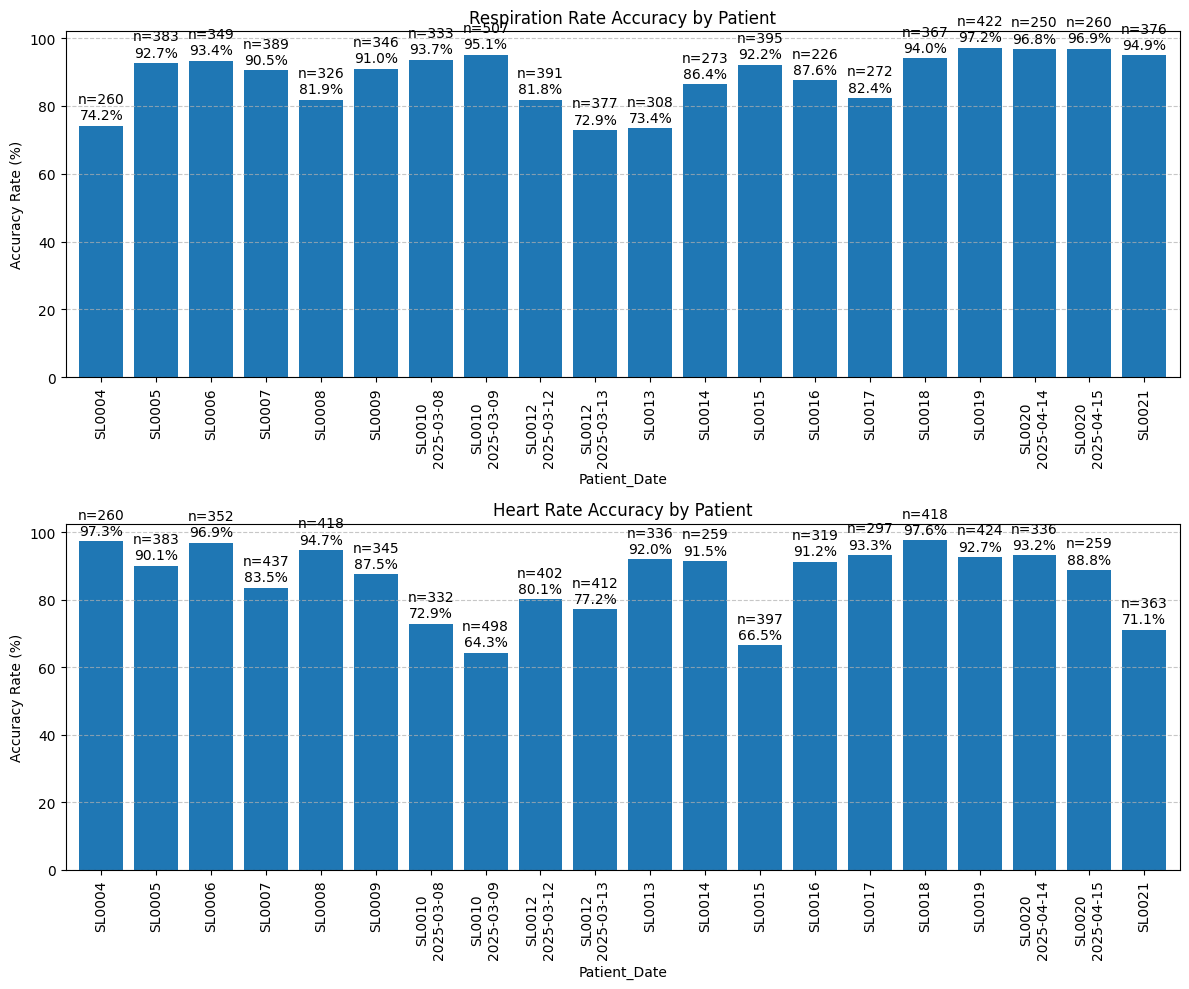

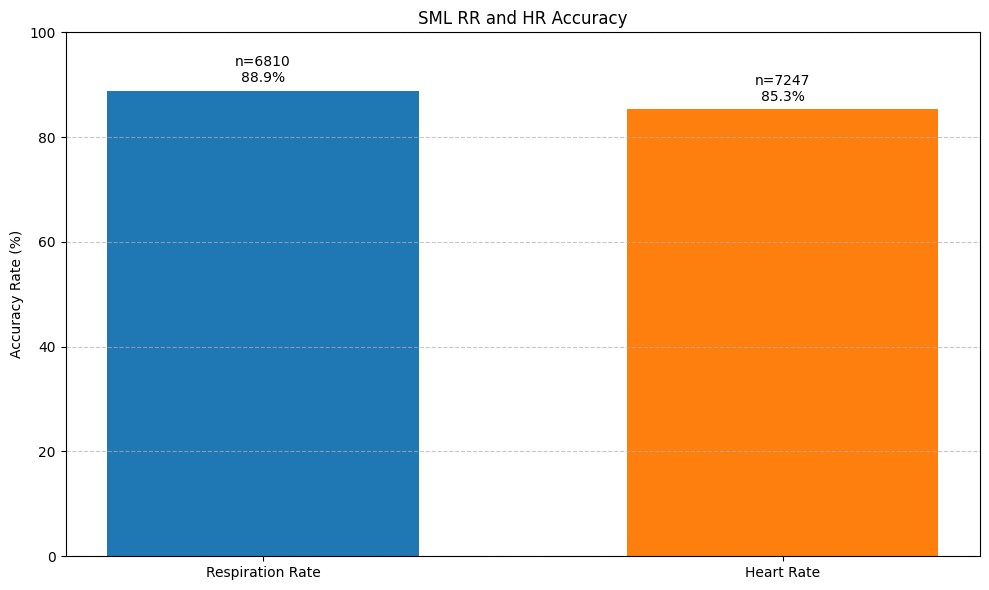

In [31]:

# Function to calculate accuracy rates
def calculate_accuracy_rates(results, measured_rr_col, measured_hr_col, version_suffix):
    accuracy_rates = []
    results[f'MeasuredRR_bpm_{version_suffix}'] = results[measured_rr_col] * 60
    results[f'MeasuredHR_bpm_{version_suffix}'] = results[measured_hr_col] * 60

    for (patient, date), group in results.groupby(['PatientStudyName', 'StartTime']):
        # Format date to show only the date part without timestamp
        date_only = pd.to_datetime(date).date()
        
        # Filter for detected signals
        rr_detected = group[(group['RespDetected_new'] == True) & (group['ReferenceRR_bpm'] != 0)]
        hr_detected = group[(group['HrDetected_new'] == True) & (group['ReferenceHR_bpm'] != 0)]
        
        # Calculate accuracy for detected signals using bpm values, ignoring NaN values
        rr_accurate = rr_detected.apply(lambda x: is_rr_accurate(x[f'MeasuredRR_bpm_{version_suffix}'], x['ReferenceRR_bpm']), axis=1).dropna()
        hr_accurate = hr_detected.apply(lambda x: is_hr_accurate(x[f'MeasuredHR_bpm_{version_suffix}'], x['ReferenceHR_bpm']), axis=1).dropna()
        
        # Calculate rates
        rates = {
            'Patient': patient,
            'Session Date': date_only,
            'Patient_Date': f"{patient}\n{date_only}" if len(results[results['PatientStudyName'] == patient]['StartTime'].unique()) > 1 else patient,
            f'RR Accuracy {version_suffix}': (rr_accurate.sum() / len(rr_accurate) * 100) if len(rr_accurate) > 0 else 0,
            f'HR Accuracy {version_suffix}': (hr_accurate.sum() / len(hr_accurate) * 100) if len(hr_accurate) > 0 else 0,
            f'RR Detected Count {version_suffix}': len(rr_accurate),  # Changed to count non-NA samples
            f'HR Detected Count {version_suffix}': len(hr_accurate)   # Changed to count non-NA samples
        }
        accuracy_rates.append(rates)

    return pd.DataFrame(accuracy_rates)

filter_artifacts = False
results_with_ref = results_with_ref[results_with_ref['HasArtifact'] == False] if filter_artifacts else results_with_ref

# Calculate accuracy for both versions
df_accuracy_new_version = calculate_accuracy_rates(results_with_ref, 'RespirationRate_new', 'HeartRate_new', 'new_version')
df_accuracy_old_version = calculate_accuracy_rates(results_with_ref, 'RespirationRate', 'HeartRate', 'old_version')

# Merge the dataframes for plotting
df_accuracy = pd.merge(df_accuracy_new_version, df_accuracy_old_version, on=['Patient', 'Session Date', 'Patient_Date'])

def plot_accuracy_comparison(df_accuracy, exclude_patients=None, show_only_new=False):
    # Filter out excluded patients if specified
    plot_df = df_accuracy.copy()
    if exclude_patients:
        plot_df = plot_df[~plot_df['Patient'].isin(exclude_patients)]
    
    # Remove samples with n=0
    original_count = len(plot_df)
    plot_df = plot_df[(plot_df['RR Detected Count new_version'] > 0) & 
                      (plot_df['HR Detected Count new_version'] > 0)]
    if not show_only_new:
        plot_df = plot_df[(plot_df['RR Detected Count old_version'] > 0) & 
                          (plot_df['HR Detected Count old_version'] > 0)]
    
    removed_count = original_count - len(plot_df)
    if removed_count > 0:
        print(f"Removed {removed_count} samples with zero counts")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Set up colors and columns based on versions shown
    if show_only_new:
        colors = ['#1f77b4']
        rr_cols = ['RR Accuracy new_version']
        hr_cols = ['HR Accuracy new_version']
    else:
        colors = ['#1f77b4', '#ff7f0e']
        rr_cols = ['RR Accuracy old_version', 'RR Accuracy new_version']
        hr_cols = ['HR Accuracy old_version', 'HR Accuracy new_version']
        legend_labels = ['old_version', 'new_version']

    # Plot Respiration Accuracy Rates
    plot_df.plot(x='Patient_Date', y=rr_cols, kind='bar', ax=ax1, width=0.8, color=colors, legend=not show_only_new)
    ax1.set_title('Respiration Rate Accuracy by Patient')
    ax1.set_ylabel('Accuracy Rate (%)')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xticklabels(plot_df['Patient_Date'], rotation=90)
    if not show_only_new:
        ax1.legend(legend_labels)

    # Add count labels and percentage on top of bars
    for i in range(len(plot_df)):
        if not show_only_new:
            v2 = plot_df['RR Accuracy old_version'].iloc[i]
            ax1.text(i - 0.15, v2 + 1, f'n={plot_df["RR Detected Count old_version"].iloc[i]}\n{v2:.1f}%', 
                     ha='center', va='bottom', color='black')
        v1 = plot_df['RR Accuracy new_version'].iloc[i]
        offset = 0 if show_only_new else 0.15
        ax1.text(i + offset, v1 + 1, f'n={plot_df["RR Detected Count new_version"].iloc[i]}\n{v1:.1f}%', 
                 ha='center', va='bottom', color='black')

    # Plot Heart Rate Accuracy Rates
    plot_df.plot(x='Patient_Date', y=hr_cols, kind='bar', ax=ax2, width=0.8, color=colors, legend=not show_only_new)
    ax2.set_title('Heart Rate Accuracy by Patient')
    ax2.set_ylabel('Accuracy Rate (%)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xticklabels(plot_df['Patient_Date'], rotation=90)
    if not show_only_new:
        ax2.legend(legend_labels)

    # Add count labels and percentage on top of bars
    for i in range(len(plot_df)):
        if not show_only_new:
            v2 = plot_df['HR Accuracy old_version'].iloc[i]
            ax2.text(i - 0.15, v2 + 1, f'n={plot_df["HR Detected Count old_version"].iloc[i]}\n{v2:.1f}%', 
                     ha='center', va='bottom', color='black')
        v1 = plot_df['HR Accuracy new_version'].iloc[i]
        offset = 0 if show_only_new else 0.15
        ax2.text(i + offset, v1 + 1, f'n={plot_df["HR Detected Count new_version"].iloc[i]}\n{v1:.1f}%', 
                 ha='center', va='bottom', color='black')

    plt.tight_layout()
    plt.show()

# Function to plot total accuracy for RR and HR
def plot_total_accuracy(df_accuracy, exclude_patients=None):
    # Filter out excluded patients if specified
    plot_df = df_accuracy.copy()
    if exclude_patients:
        plot_df = plot_df[~plot_df['Patient'].isin(exclude_patients)]
    
    # Remove samples with n=0
    original_df = plot_df.copy()
    original_count = len(plot_df)
    mask = (plot_df['RR Detected Count new_version'] > 0) & (plot_df['HR Detected Count new_version'] > 0)
    plot_df = plot_df[mask]
    
    removed_count = original_count - len(plot_df)
    if removed_count > 0:
        removed = original_df[~mask]
        print(f"Removed {removed_count} samples with zero counts from total accuracy calculation: {removed}")
    
    # Calculate total accuracy across all patients
    total_rr_accurate = sum(plot_df['RR Accuracy new_version'] * plot_df['RR Detected Count new_version'])
    total_rr_count = sum(plot_df['RR Detected Count new_version'])
    total_hr_accurate = sum(plot_df['HR Accuracy new_version'] * plot_df['HR Detected Count new_version'])
    total_hr_count = sum(plot_df['HR Detected Count new_version'])
    
    # Calculate overall accuracy percentages
    rr_accuracy = (total_rr_accurate / total_rr_count) if total_rr_count > 0 else 0
    hr_accuracy = (total_hr_accurate / total_hr_count) if total_hr_count > 0 else 0
    
    # Create a dataframe for plotting
    total_accuracy_df = pd.DataFrame({
        'Vital Sign': ['Respiration Rate', 'Heart Rate'],
        'Accuracy (%)': [rr_accuracy, hr_accuracy],
        'Count': [total_rr_count, total_hr_count]
    })
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(total_accuracy_df['Vital Sign'], total_accuracy_df['Accuracy (%)'], 
            color=['#1f77b4', '#ff7f0e'], width=0.6)
    
    # Add labels and title
    ax.set_ylabel('Accuracy Rate (%)')
    ax.set_title('SML RR and HR Accuracy')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count and percentage labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        count = total_accuracy_df['Count'].iloc[i]
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'n={count}\n{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_accuracy_comparison(df_accuracy, exclude_patients=['SL0011'], show_only_new=True)
plot_total_accuracy(df_accuracy, exclude_patients=['SL0011'])

# To exclude specific patients:
# plot_accuracy_comparison(df_accuracy, exclude_patients=['SL0011', 'SL0012'], show_only_new=True)
# plot_total_accuracy(df_accuracy, exclude_patients=['SL0011', 'SL0012'])


### Box plots comparing RR and HR ours vs refernce per session ###

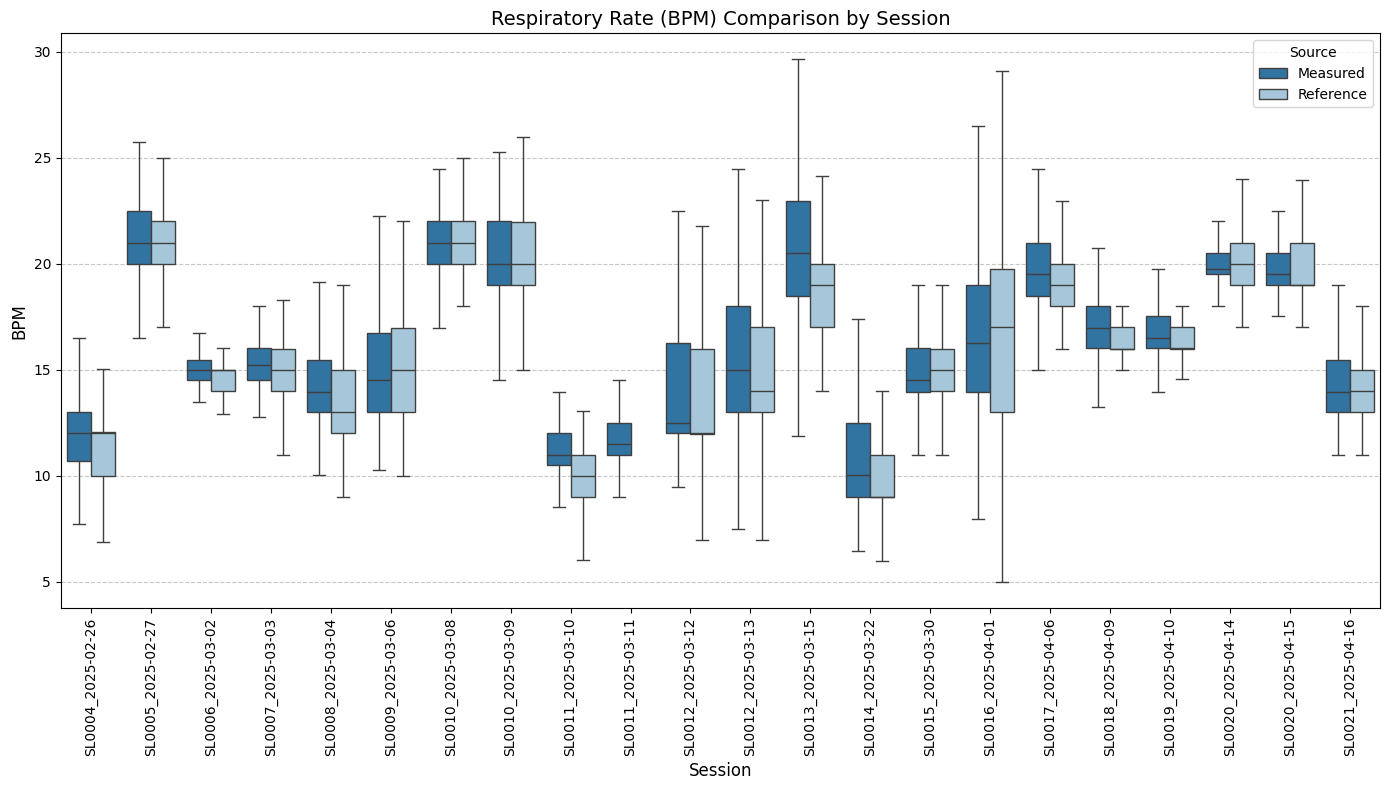

/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


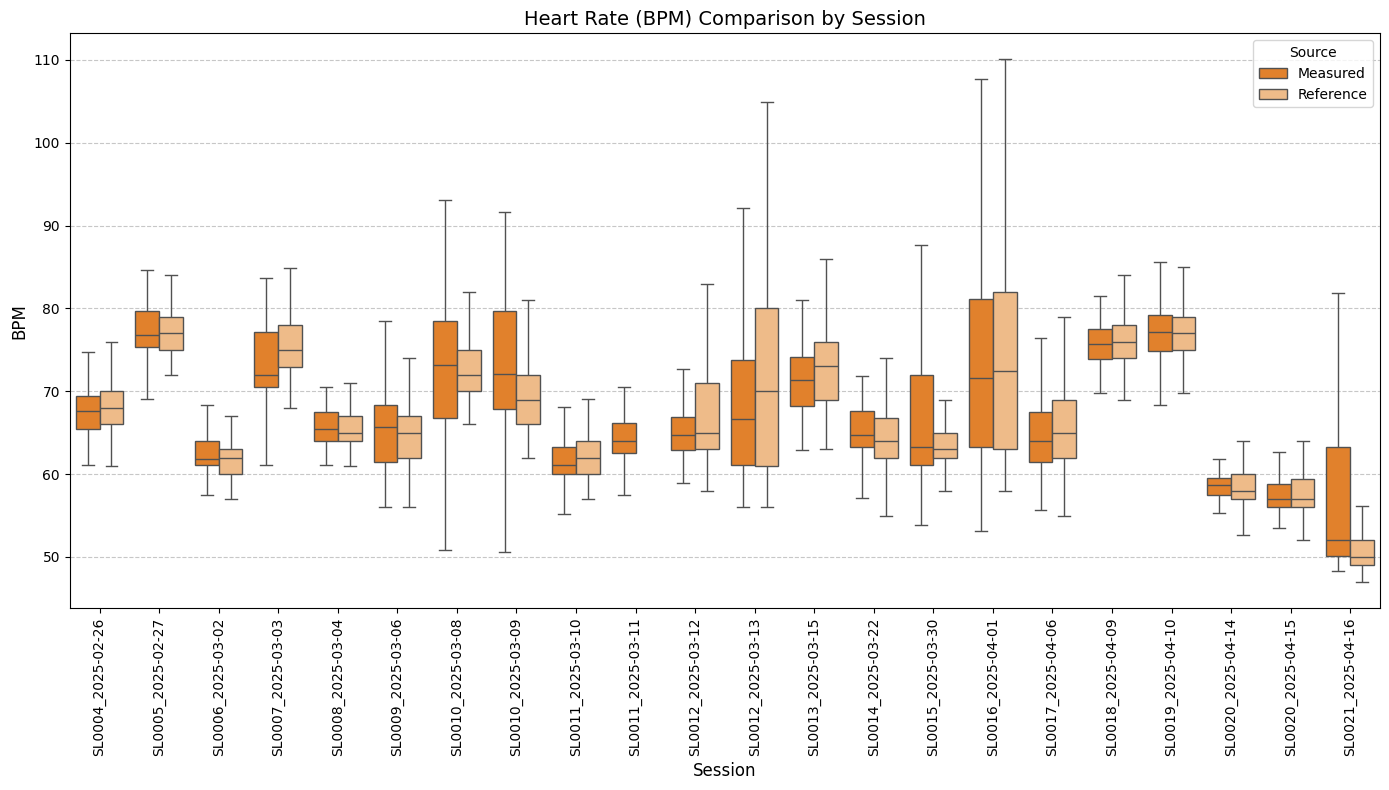


Respiratory Rate Summary Statistics:
       Measured_Mean  Reference_Mean  Measured_Median  Reference_Median  \
count      22.000000       21.000000        22.000000         21.000000   
mean       16.608991       16.130270        15.919091         15.810515   
std         2.981152        3.323445         3.453316          3.514637   
min        12.025746       10.301289        10.020000          9.008397   
25%        14.929153       14.789382        13.980000         14.000000   
50%        16.043250       15.204137        15.120000         14.999429   
75%        19.738650       19.161570        19.500000         19.001893   
max        21.090694       20.993278        21.000000         21.000000   

       Measured_Std  Reference_Std  
count     22.000000      21.000000  
mean       3.268341       2.488151  
std        1.111189       0.738262  
min        1.487848       1.459324  
25%        2.448931       2.136821  
50%        3.215000       2.260761  
75%        3.582434       3

/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
import seaborn as sns

# Create box plots comparing RR and HR measurements vs reference per session
def plot_vital_signs_boxplots(data, vital_sign='RR'):
    """
    Create box plots comparing our measurements vs reference for RR or HR per session.
    
    Parameters:
    - data: DataFrame containing the measurements
    - vital_sign: 'RR' or 'HR' to specify which vital sign to plot
    """
    # Make a copy to avoid modifying the original dataframe
    df = data.copy()
    
    # Define column names based on vital sign
    if vital_sign == 'RR':
        measured_col = 'MeasuredRR_bpm'
        reference_col = 'ReferenceRR_bpm'
        title = 'Respiratory Rate (BPM)'
        color1, color2 = '#1f77b4', '#9ecae1'  # Blue shades
    else:  # HR
        measured_col = 'MeasuredHR_bpm'
        reference_col = 'ReferenceHR_bpm'
        title = 'Heart Rate (BPM)'
        color1, color2 = '#ff7f0e', '#ffbb78'  # Orange shades
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for (patient, date), group in df.groupby(['PatientStudyName', 'StartTime']):
        # Extract just the date part from the timestamp
        session_date = pd.to_datetime(date).date() if isinstance(date, str) else date.date()
        session_id = f"{patient}_{session_date}"
        
        # Add measured values
        for value in group[measured_col]:
            if not pd.isna(value):
                plot_data.append({
                    'Session': session_id,
                    'Source': 'Measured',
                    'Value': value
                })
        
        # Add reference values
        for value in group[reference_col]:
            if not pd.isna(value):
                plot_data.append({
                    'Session': session_id,
                    'Source': 'Reference',
                    'Value': value
                })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Create the boxplot with sessions on x-axis and paired boxes for each session
    # Set showfliers=False to hide the outlier points (dots)
    ax = sns.boxplot(x='Session', y='Value', hue='Source', 
                     data=plot_df, palette=[color1, color2], showfliers=False)
    
    # Customize the plot
    plt.title(f'{title} Comparison by Session', fontsize=14)
    plt.ylabel('BPM', fontsize=12)
    plt.xlabel('Session', fontsize=12)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.legend(title='Source')
    
    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for return
    session_stats = []
    for (patient, date), group in df.groupby(['PatientStudyName', 'StartTime']):
        # Extract just the date part from the timestamp
        session_date = pd.to_datetime(date).date() if isinstance(date, str) else date.date()
        session_id = f"{patient}_{session_date}"
        
        # Calculate statistics for measured values
        measured_mean = group[measured_col].mean()
        measured_median = group[measured_col].median()
        measured_std = group[measured_col].std()
        
        # Calculate statistics for reference values
        reference_mean = group[reference_col].mean()
        reference_median = group[reference_col].median()
        reference_std = group[reference_col].std()
        
        # Store the statistics
        session_stats.append({
            'Session': session_id,
            'Measured_Mean': measured_mean,
            'Measured_Median': measured_median,
            'Measured_Std': measured_std,
            'Reference_Mean': reference_mean,
            'Reference_Median': reference_median,
            'Reference_Std': reference_std,
            'Count': len(group)
        })
    
    return pd.DataFrame(session_stats)

# Plot box plots for Respiratory Rate
rr_stats = plot_vital_signs_boxplots(results_with_ref, vital_sign='RR')

# Plot box plots for Heart Rate
hr_stats = plot_vital_signs_boxplots(results_with_ref, vital_sign='HR')

# Display summary statistics
print("\nRespiratory Rate Summary Statistics:")
print(rr_stats[['Measured_Mean', 'Reference_Mean', 'Measured_Median', 'Reference_Median', 'Measured_Std', 'Reference_Std']].describe())

print("\nHeart Rate Summary Statistics:")
print(hr_stats[['Measured_Mean', 'Reference_Mean', 'Measured_Median', 'Reference_Median', 'Measured_Std', 'Reference_Std']].describe())


### Compare median RR and HR ours vs refernce per session ###


Respiratory Rate Median Differences:


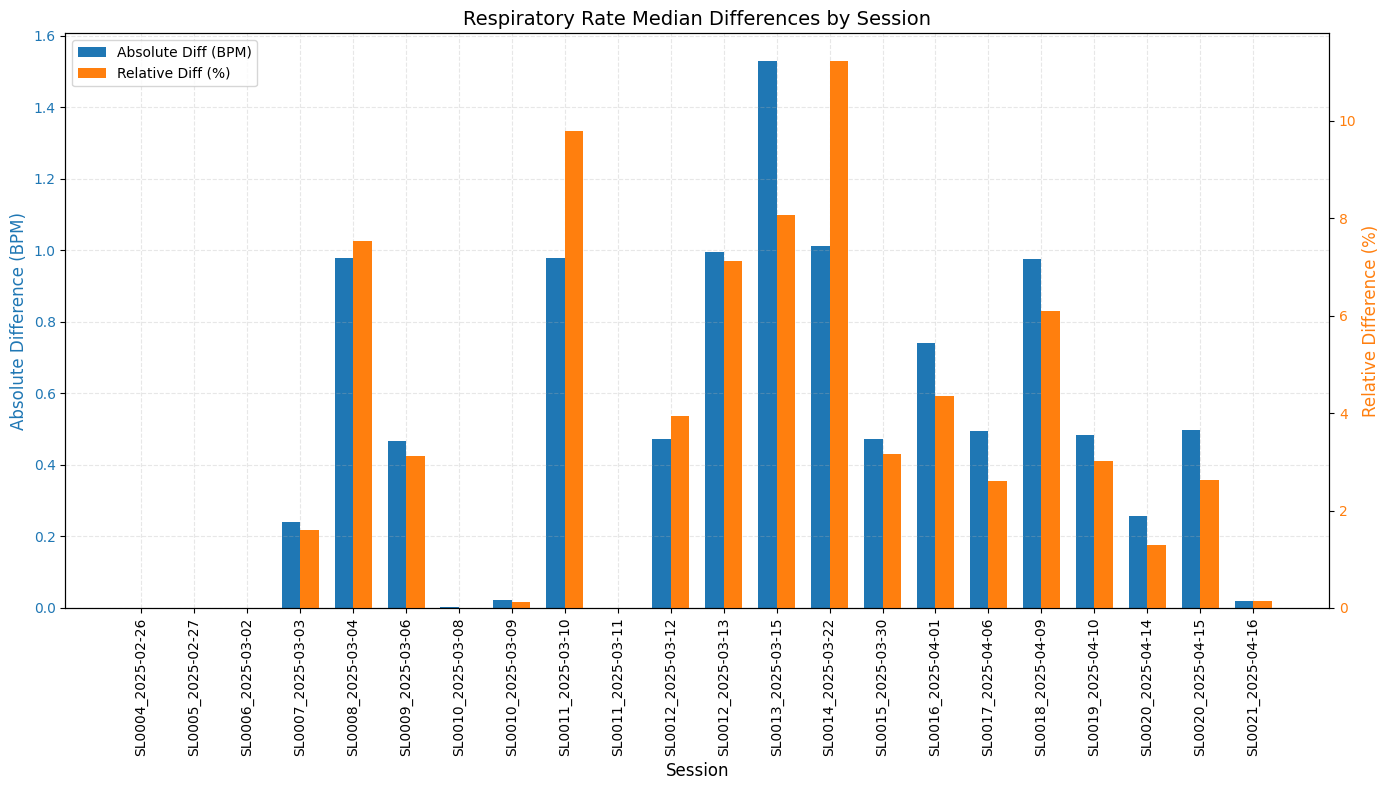


Heart Rate Median Differences:


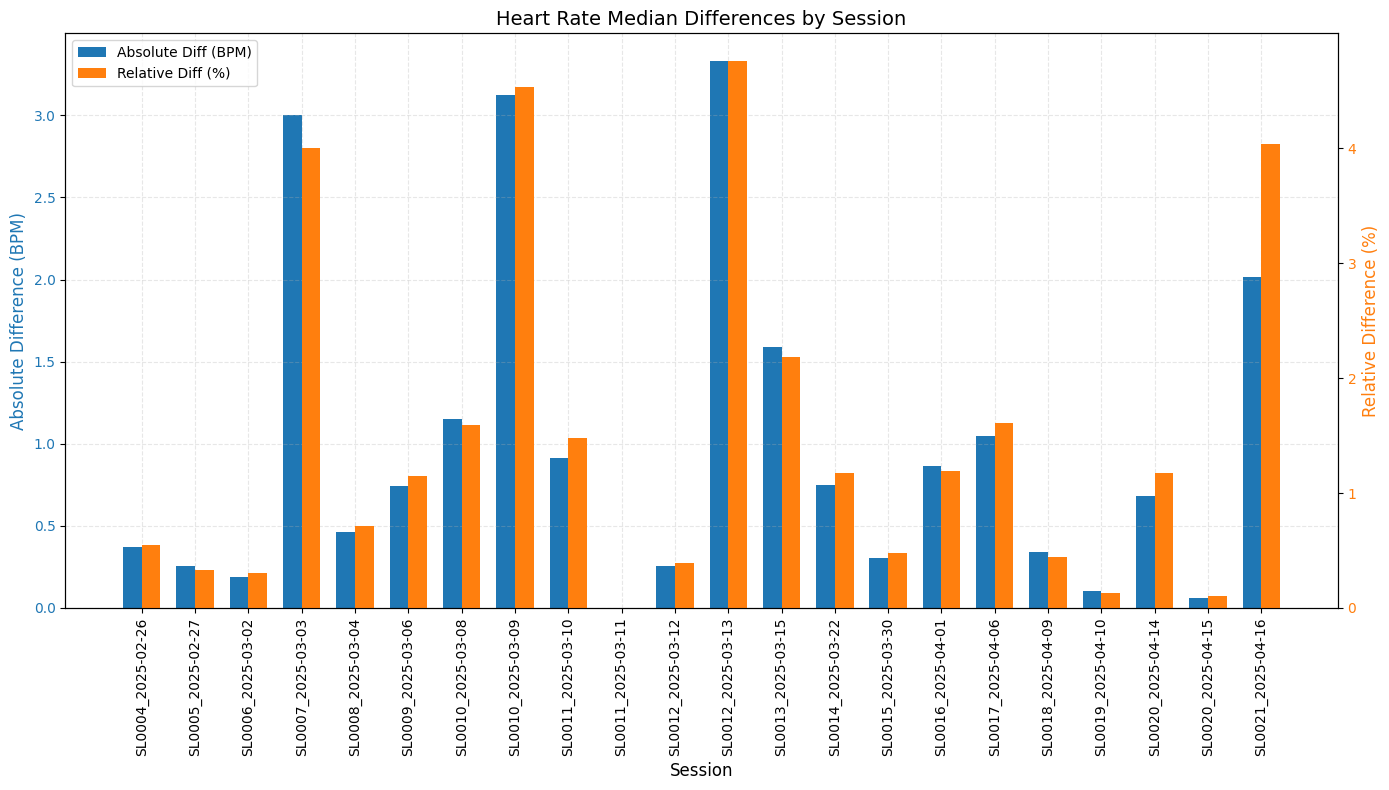

In [33]:
# Create a function to plot median differences (absolute and relative) for RR and HR
def plot_median_differences(stats_df, vital_sign='RR'):
    """
    Plot absolute and relative median differences between measured and reference values.
    
    Parameters:
    - stats_df: DataFrame containing the statistics
    - vital_sign: 'RR' or 'HR' to specify which vital sign to plot
    """
    import numpy as np
    
    # Make a copy to avoid modifying the original dataframe
    df = stats_df.copy()
    
    # Calculate absolute and relative differences
    df['Absolute_Diff'] = abs(df['Measured_Median'] - df['Reference_Median'])
    df['Relative_Diff_Percent'] = abs(df['Measured_Median'] - df['Reference_Median']) / df['Reference_Median'] * 100
    
    # Set up the figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Define colors based on vital sign
    if vital_sign == 'RR':
        color1, color2 = '#1f77b4', '#ff7f0e'  # Blue and orange
        title = 'Respiratory Rate'
    else:  # HR
        color1, color2 = '#1f77b4', '#ff7f0e'  # Blue and orange
        title = 'Heart Rate'
    
    # Set up bar positions
    x = np.arange(len(df))
    width = 0.35
    
    # Plot absolute difference bars
    ax1.set_xlabel('Session', fontsize=12)
    ax1.set_ylabel('Absolute Difference (BPM)', color=color1, fontsize=12)
    abs_bars = ax1.bar(x - width/2, df['Absolute_Diff'], width, color=color1, label='Absolute Diff (BPM)')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['Session'], rotation=90)
    
    # Create a second y-axis for relative difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Relative Difference (%)', color=color2, fontsize=12)
    rel_bars = ax2.bar(x + width/2, df['Relative_Diff_Percent'], width, color=color2, label='Relative Diff (%)')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add grid lines for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Add title
    plt.title(f'{title} Median Differences by Session', fontsize=14)
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    
    return df

# Plot median differences for Respiratory Rate
print("\nRespiratory Rate Median Differences:")
rr_diff_df = plot_median_differences(rr_stats, vital_sign='RR')

# Plot median differences for Heart Rate
print("\nHeart Rate Median Differences:")
hr_diff_df = plot_median_differences(hr_stats, vital_sign='HR')


## Awake occurance during the night ##

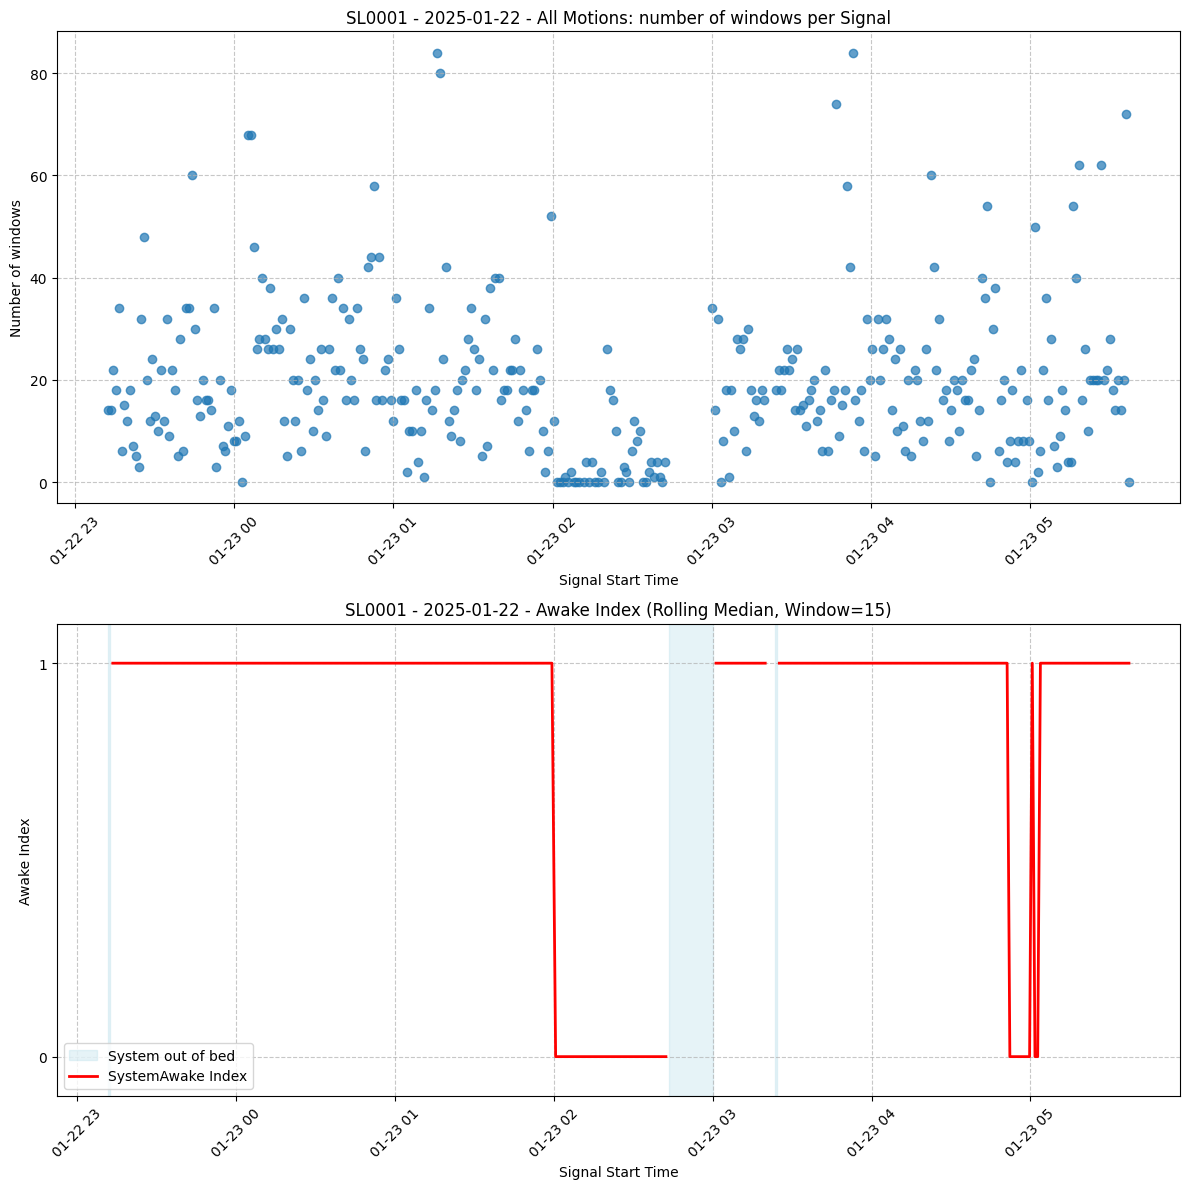

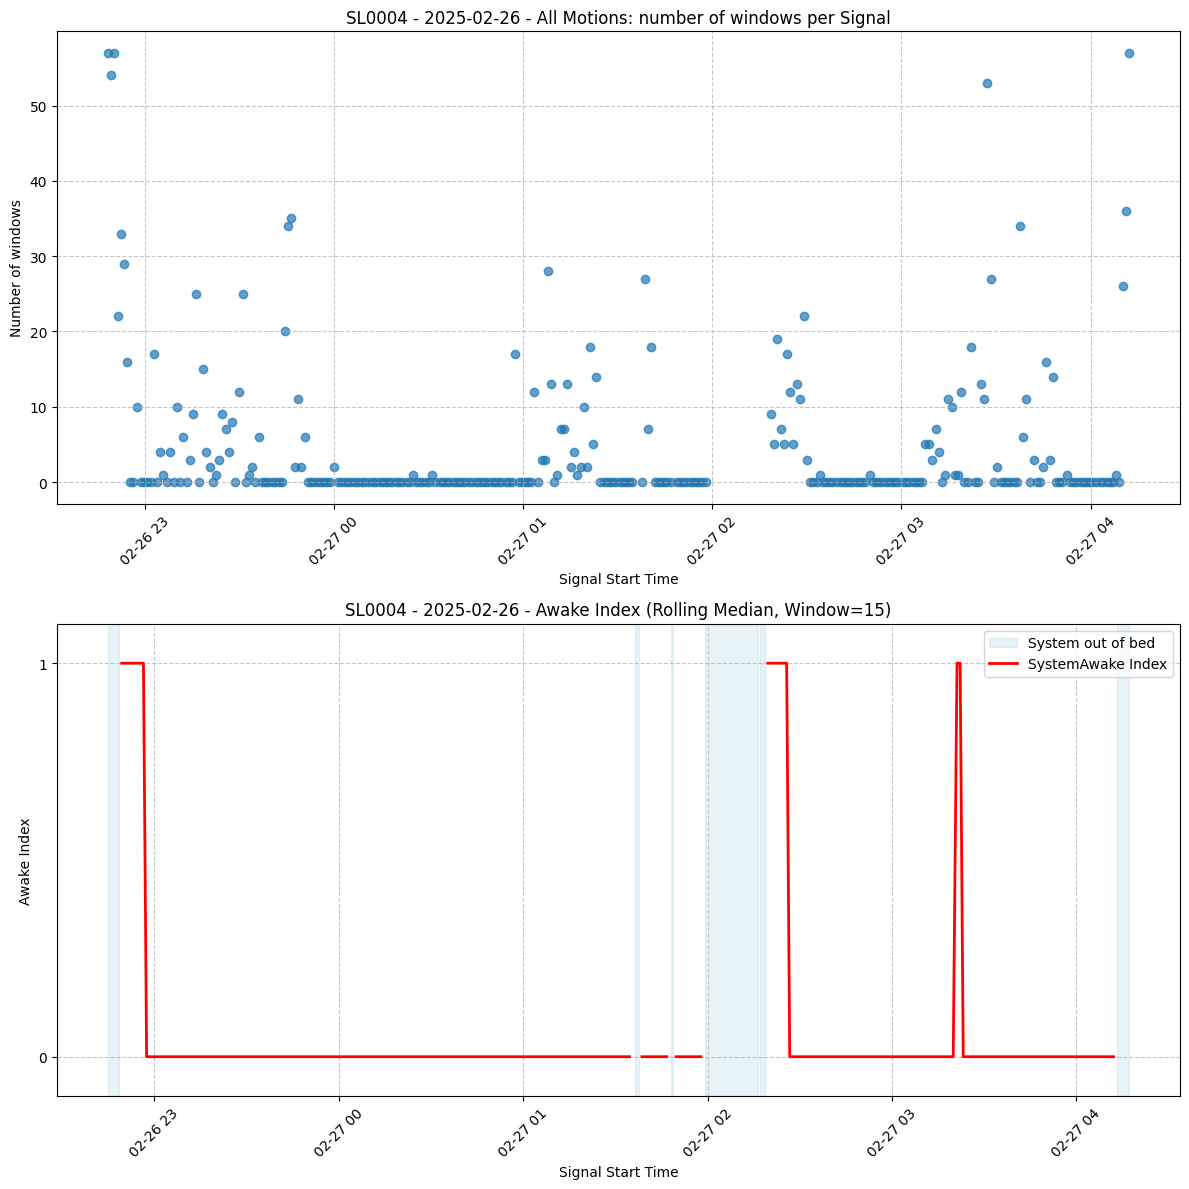

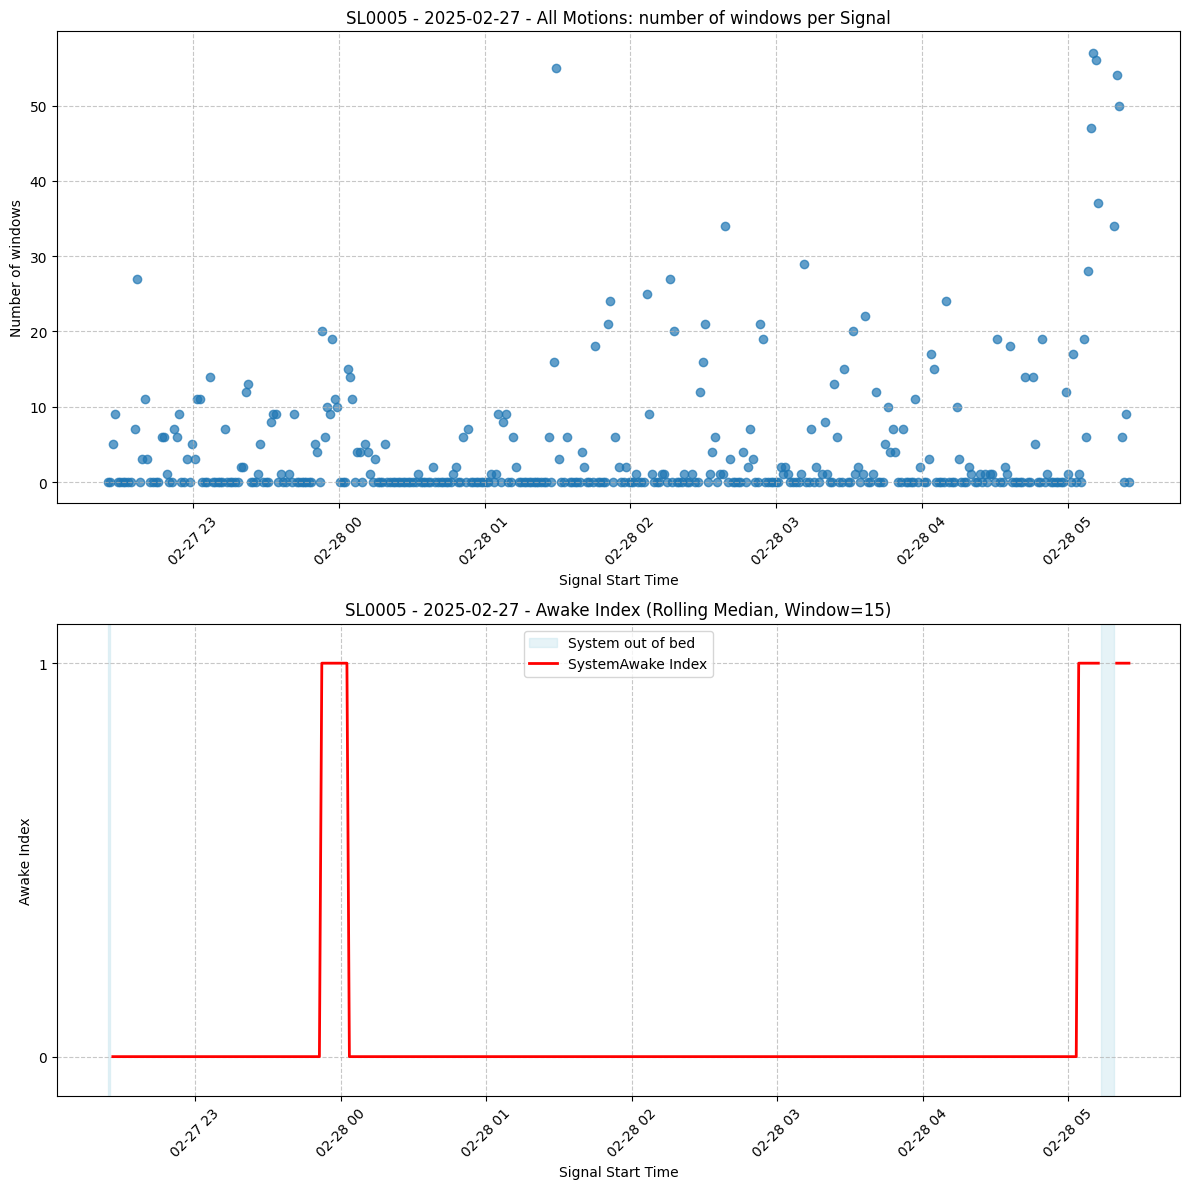

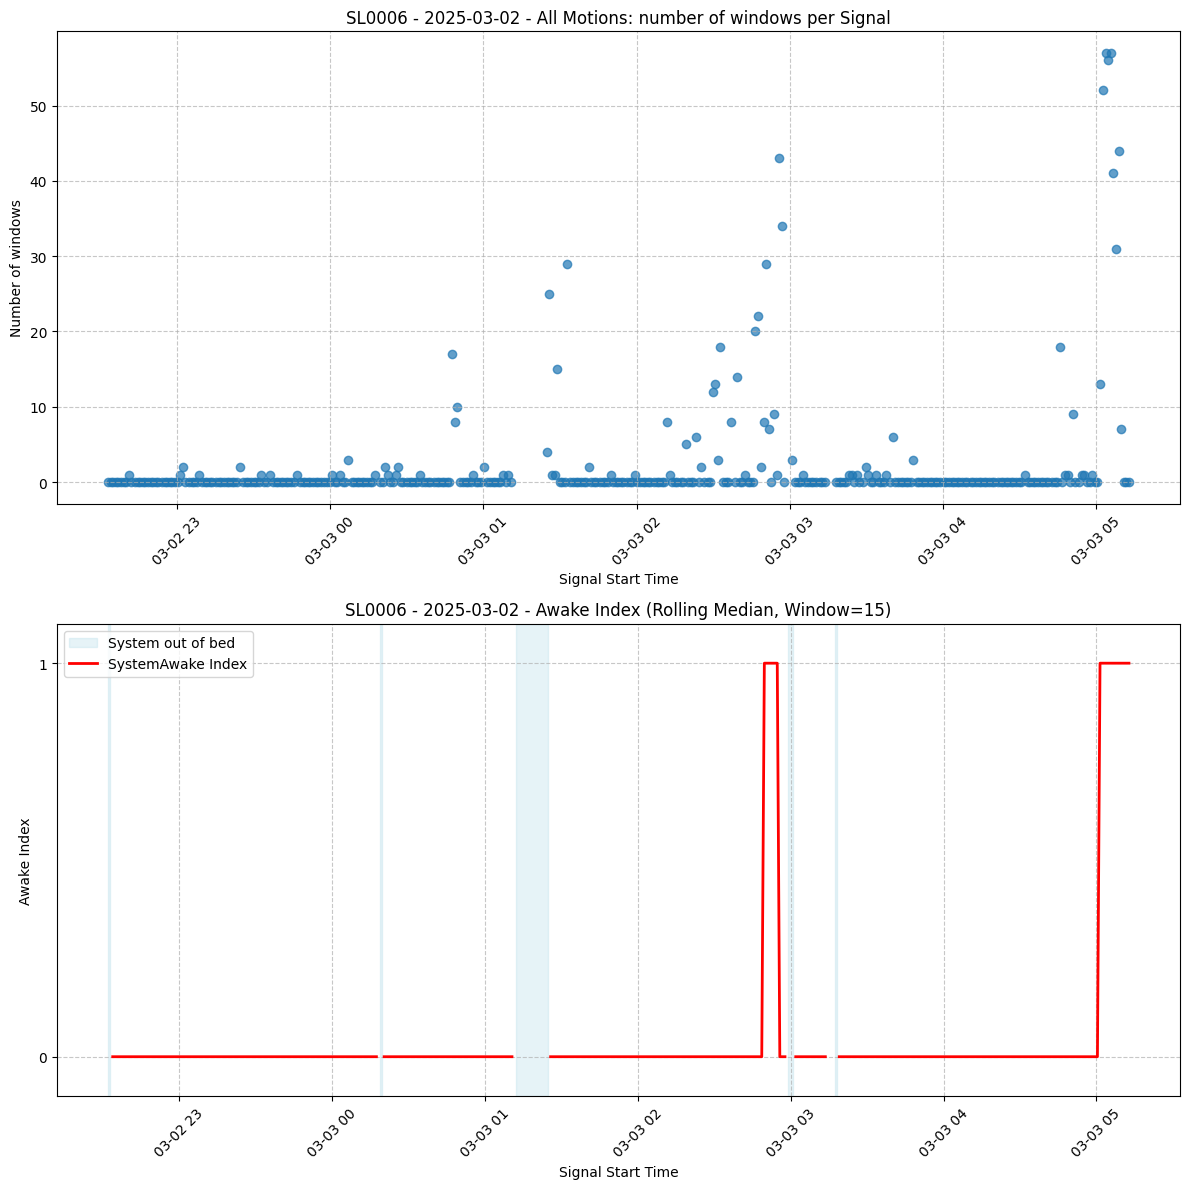

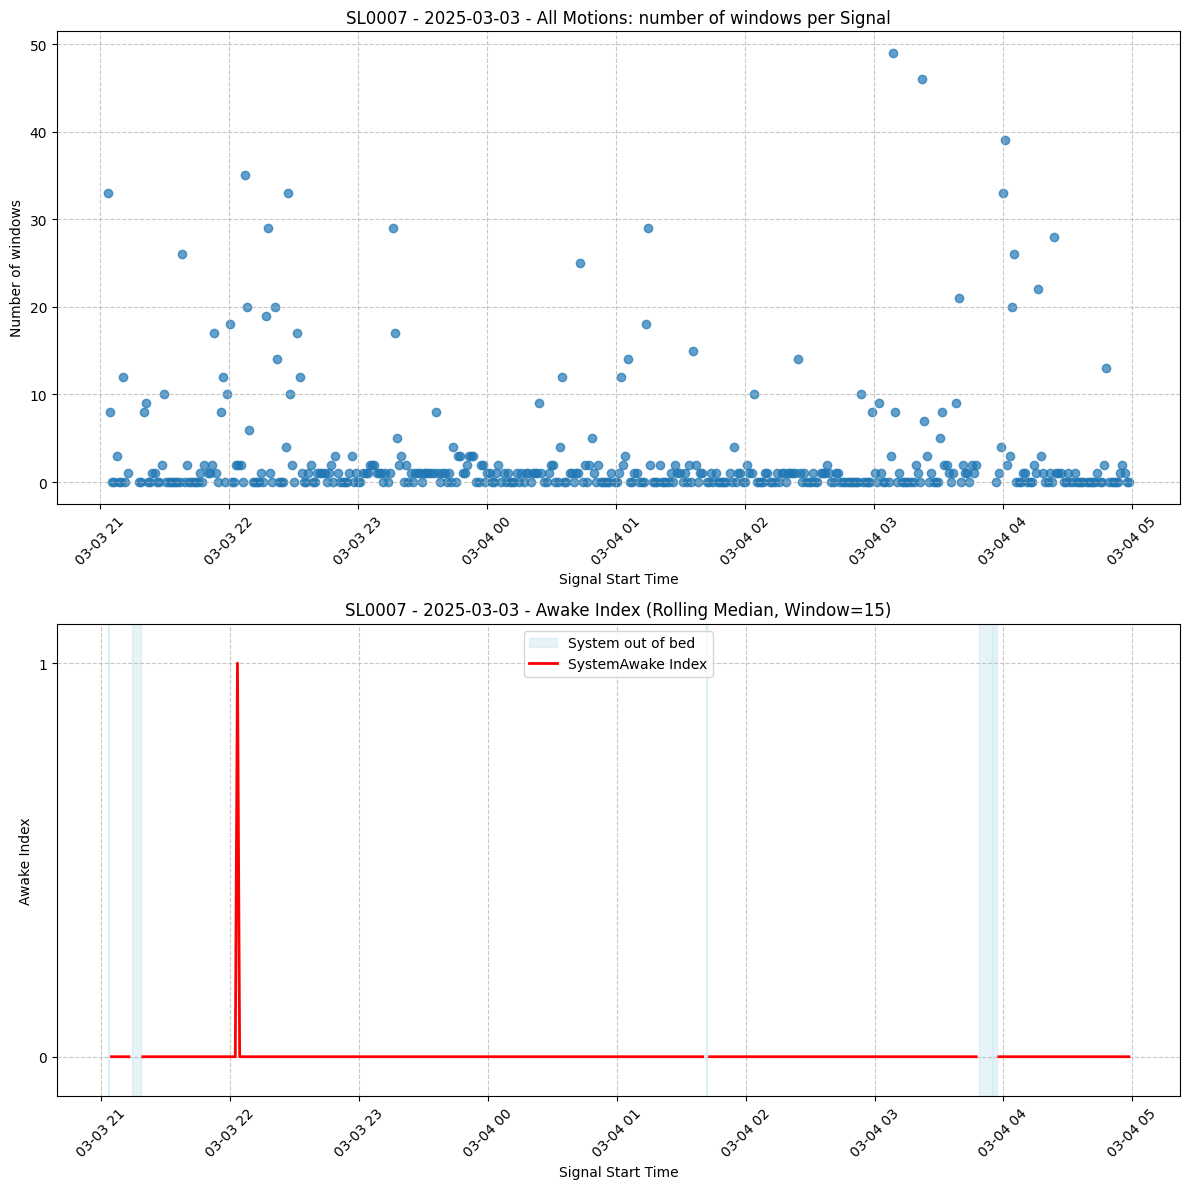

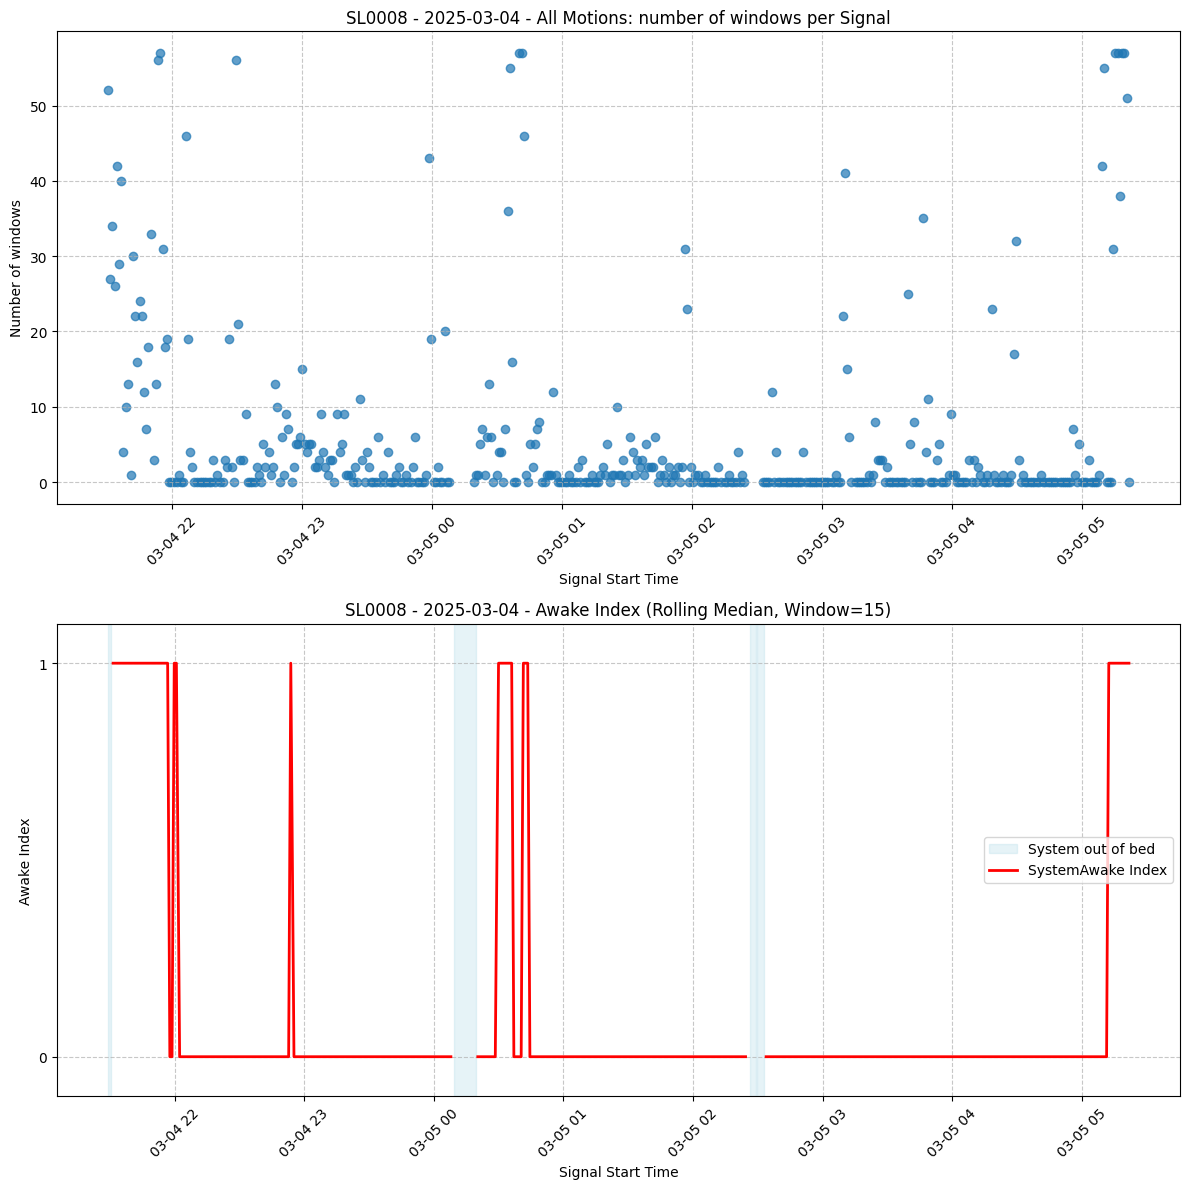

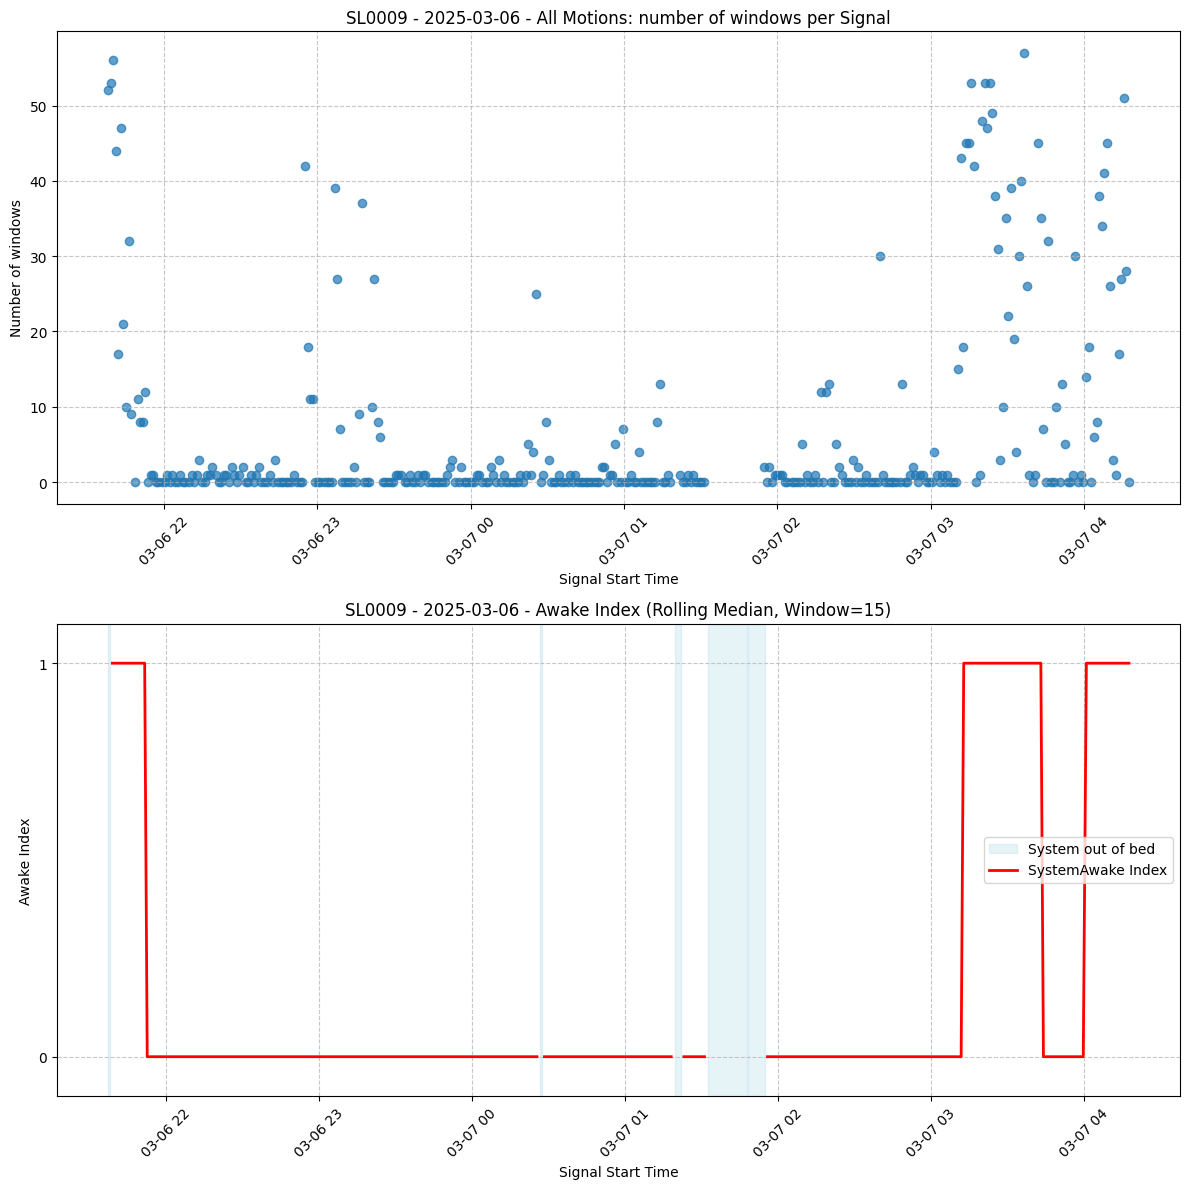

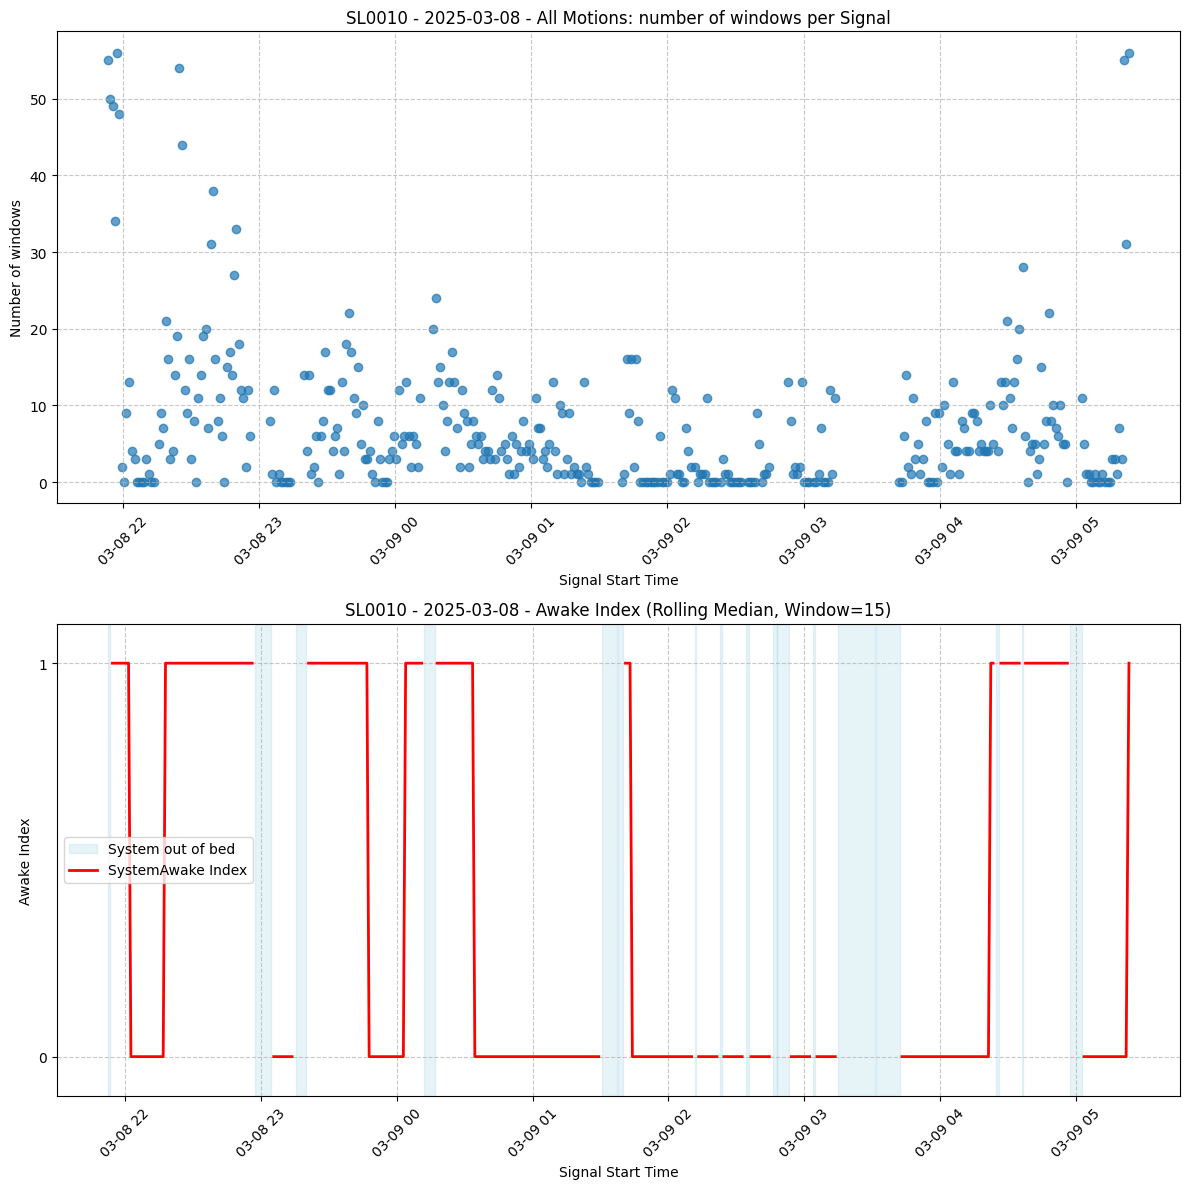

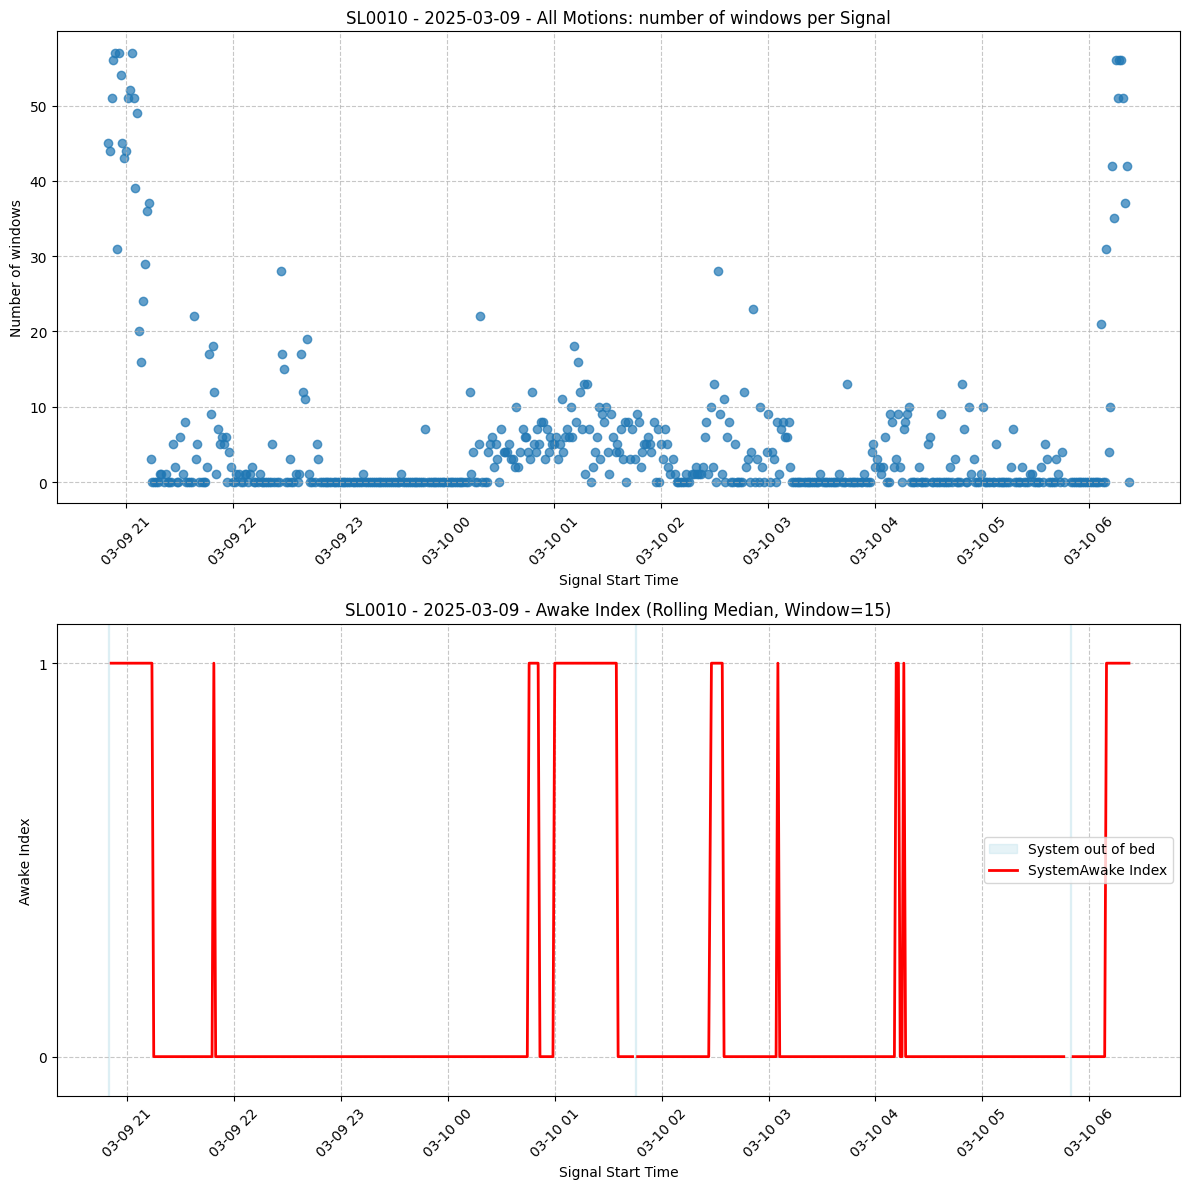

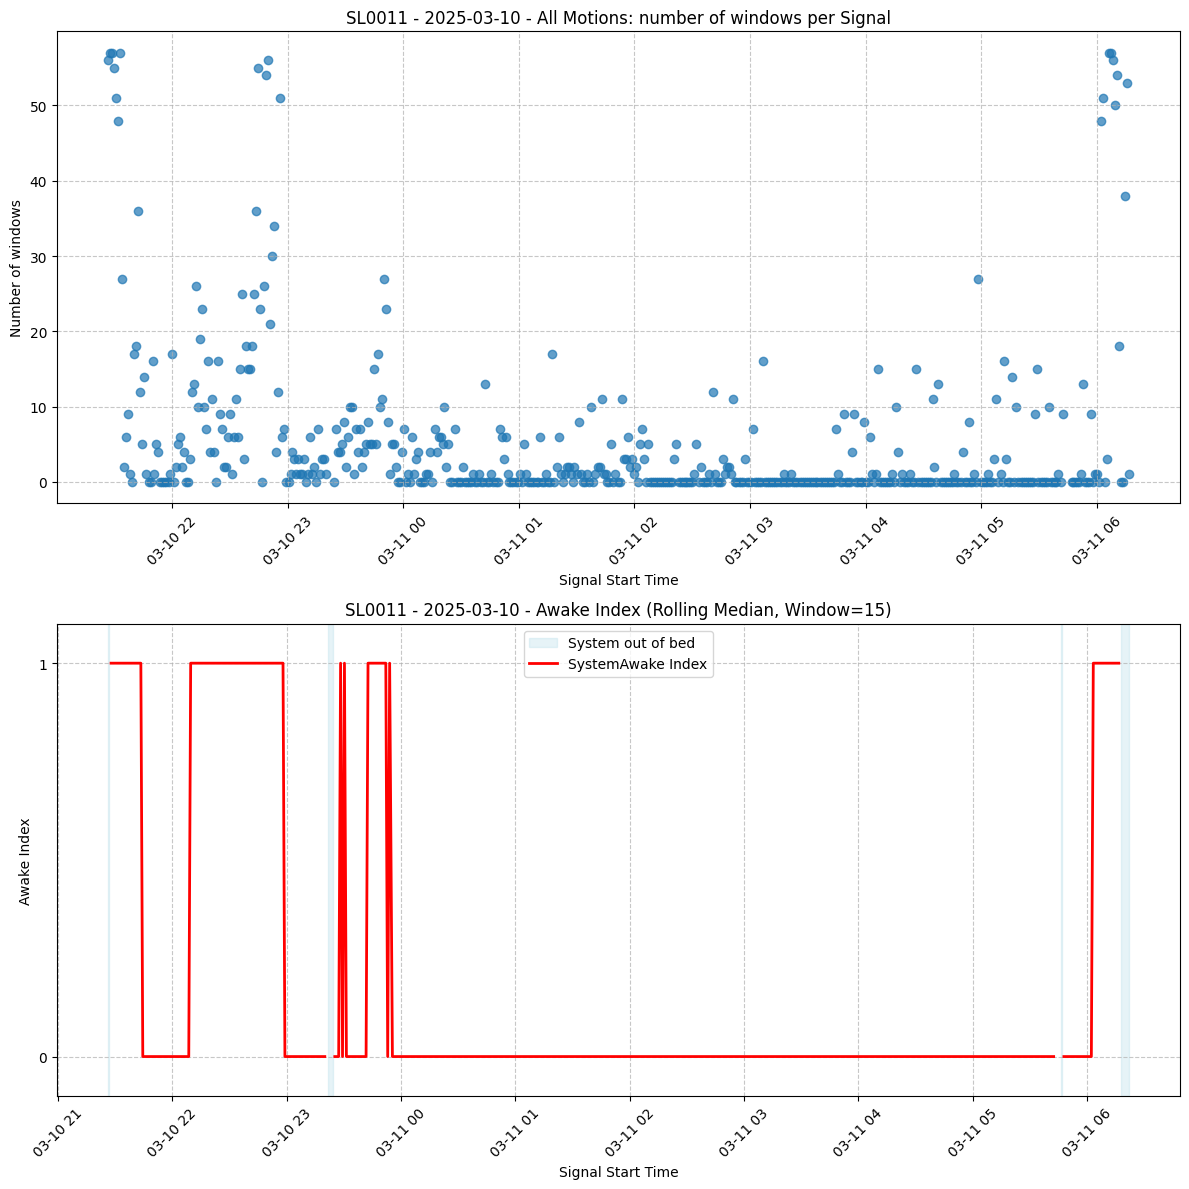

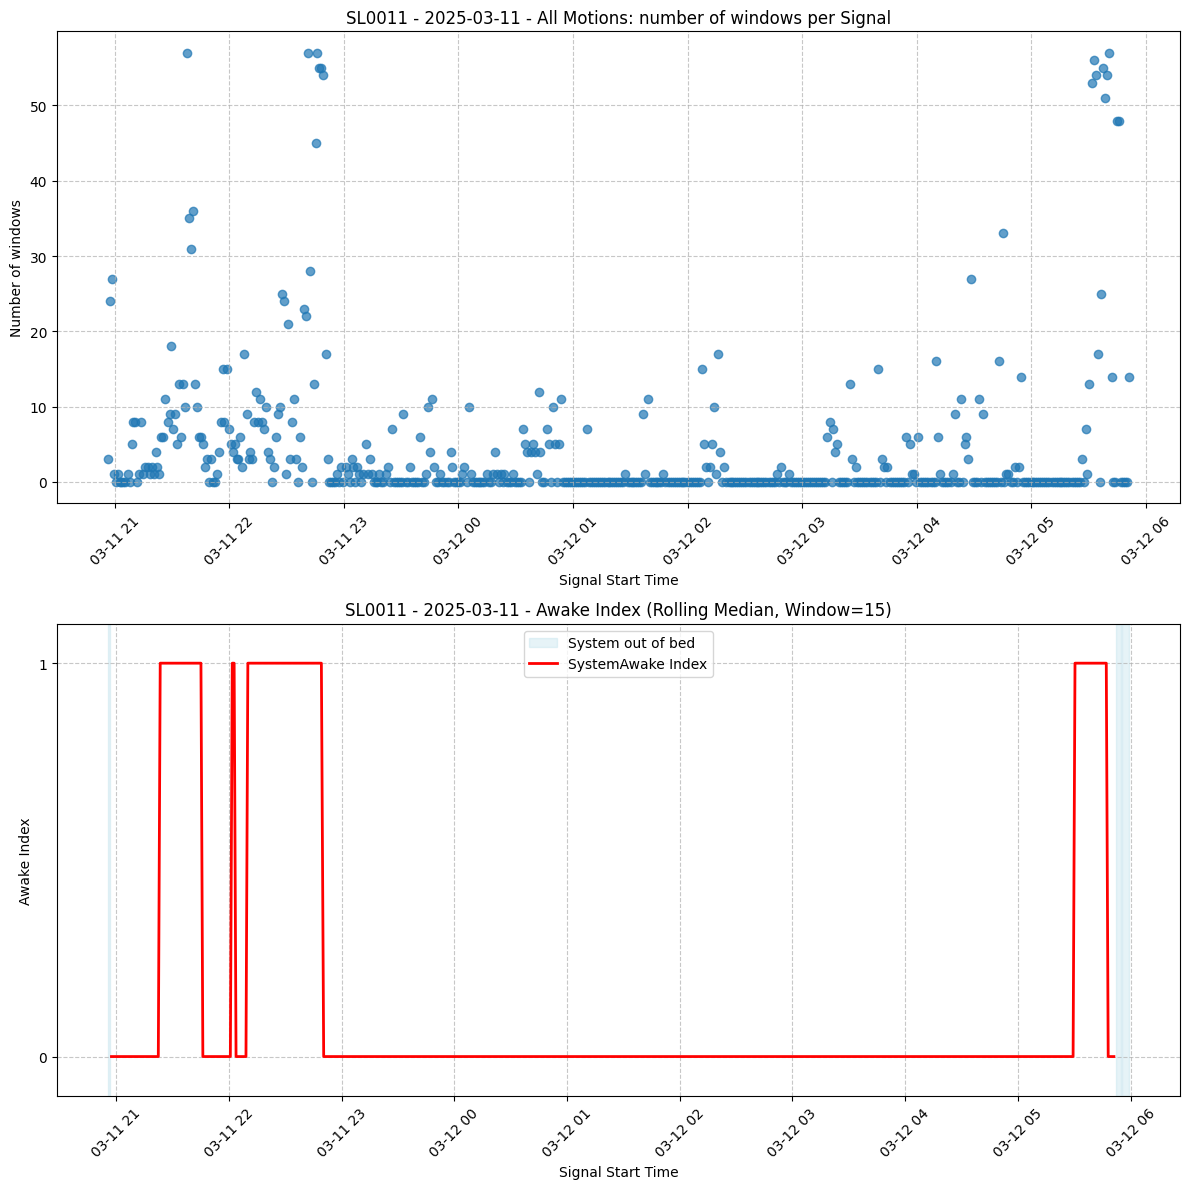

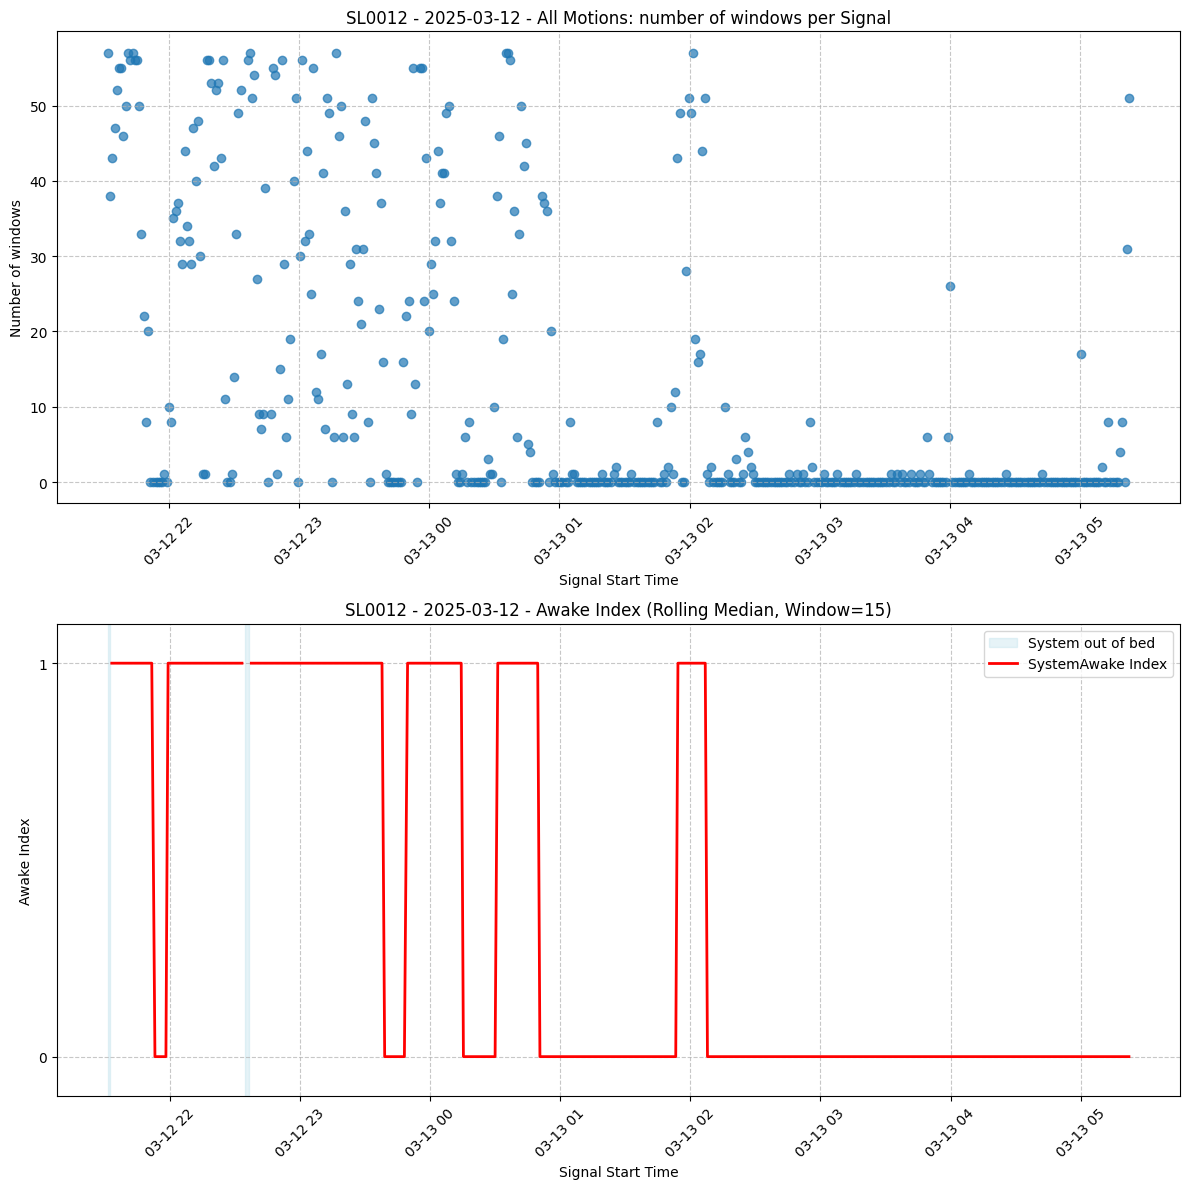

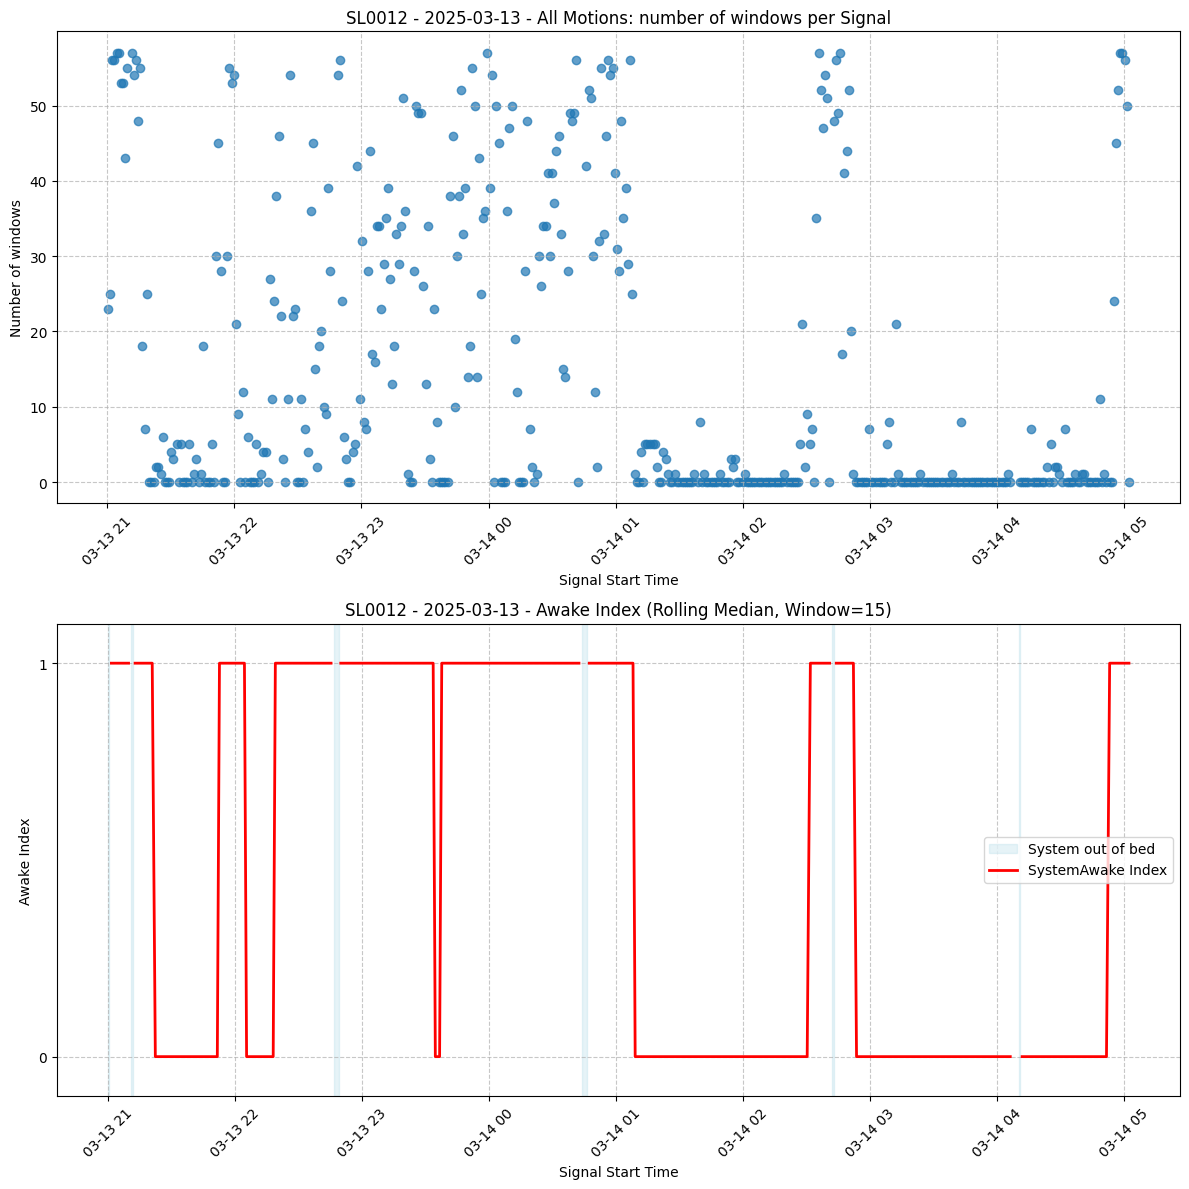

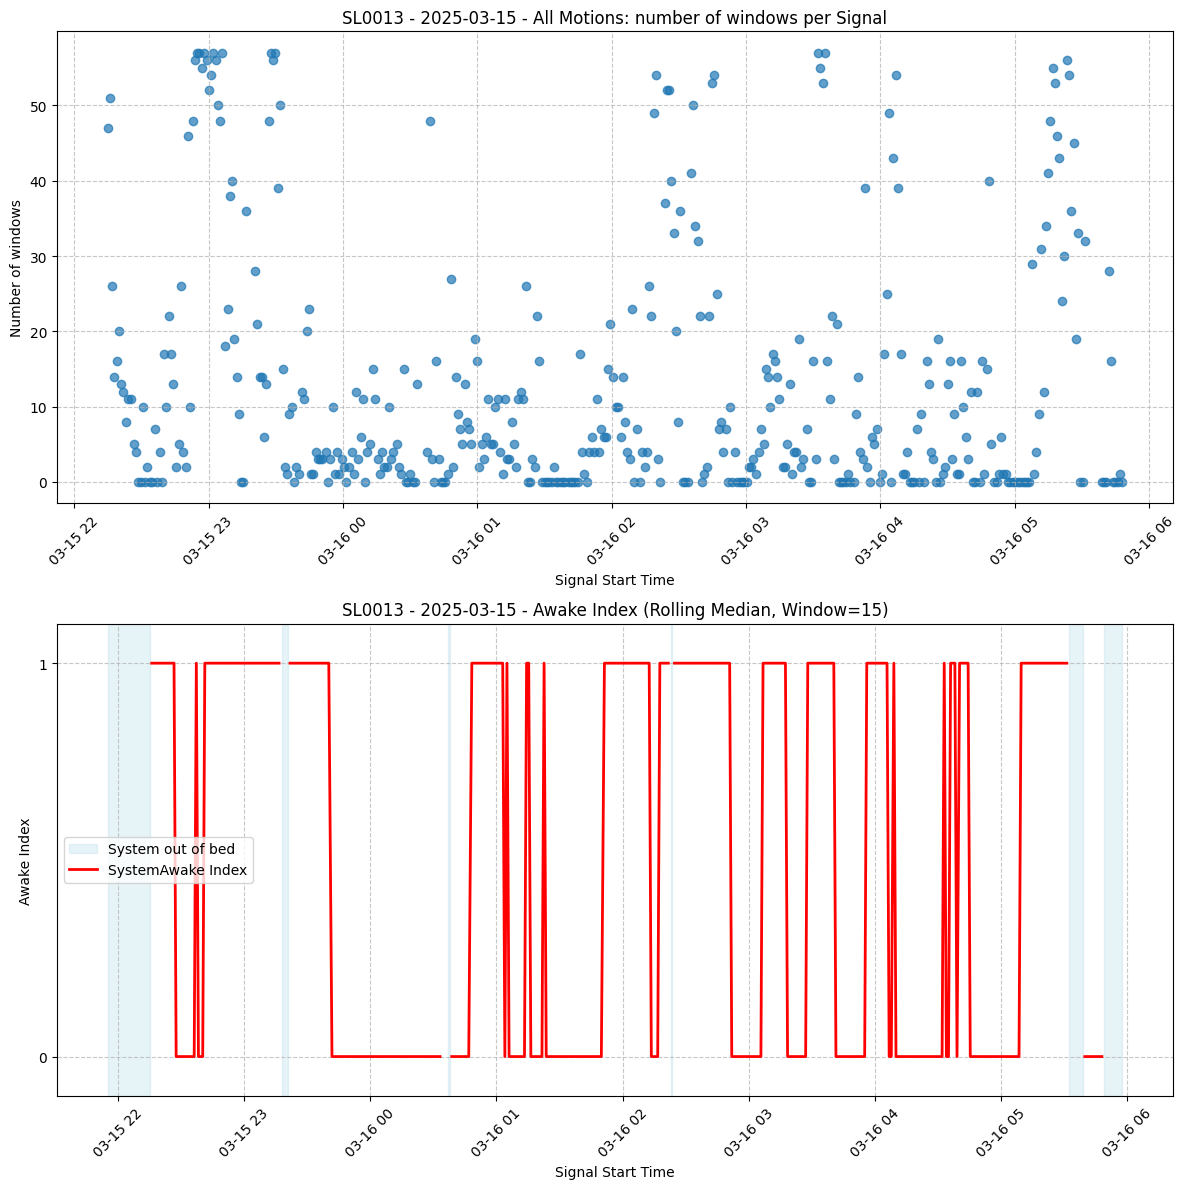

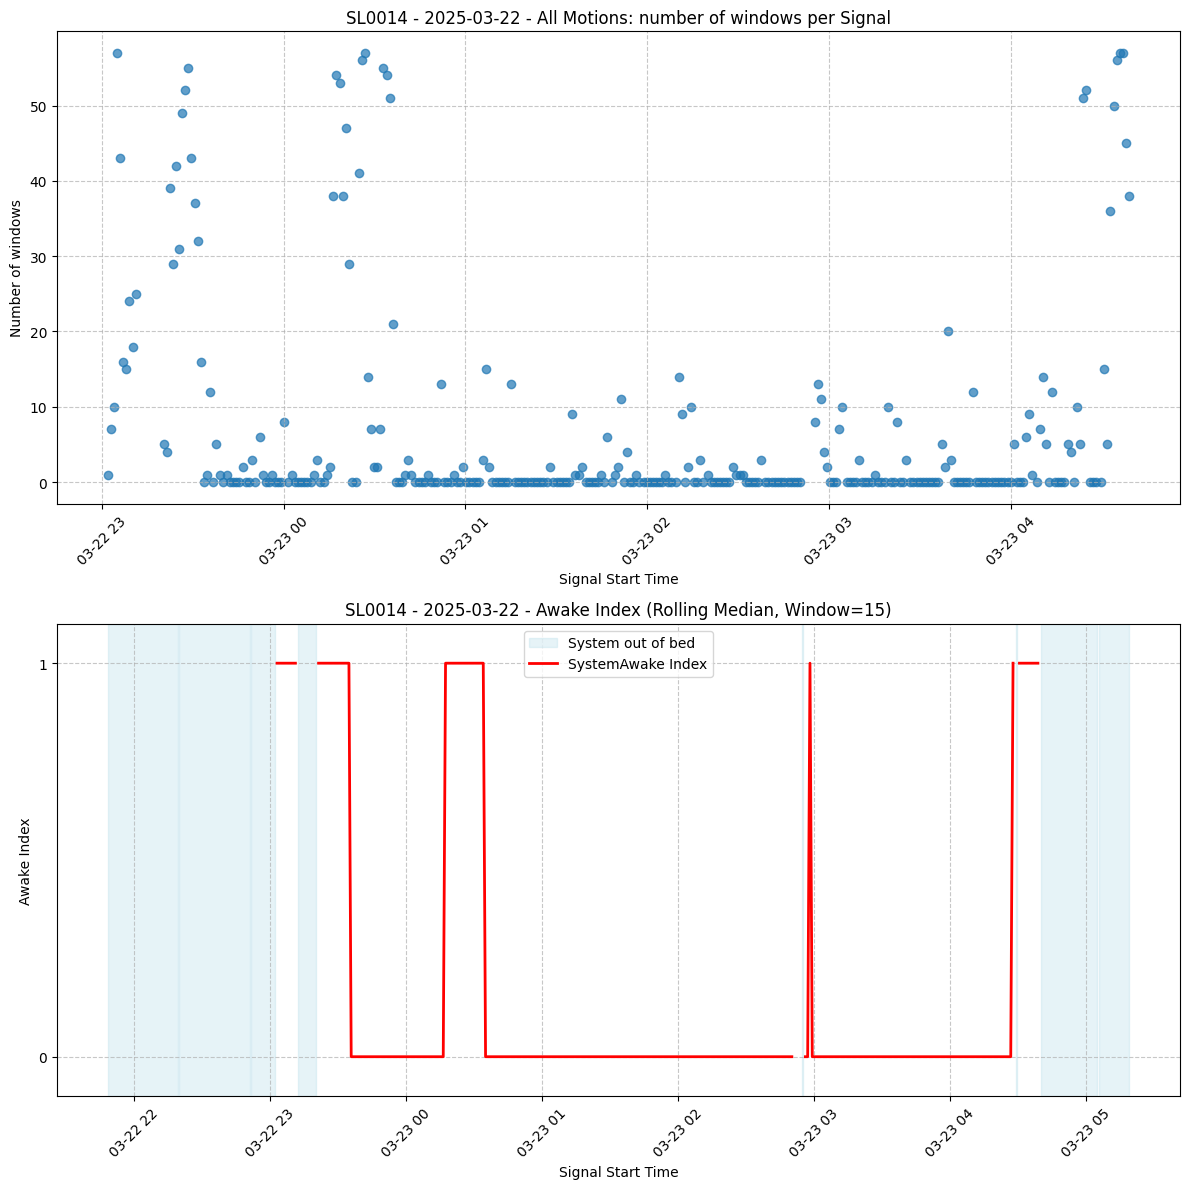

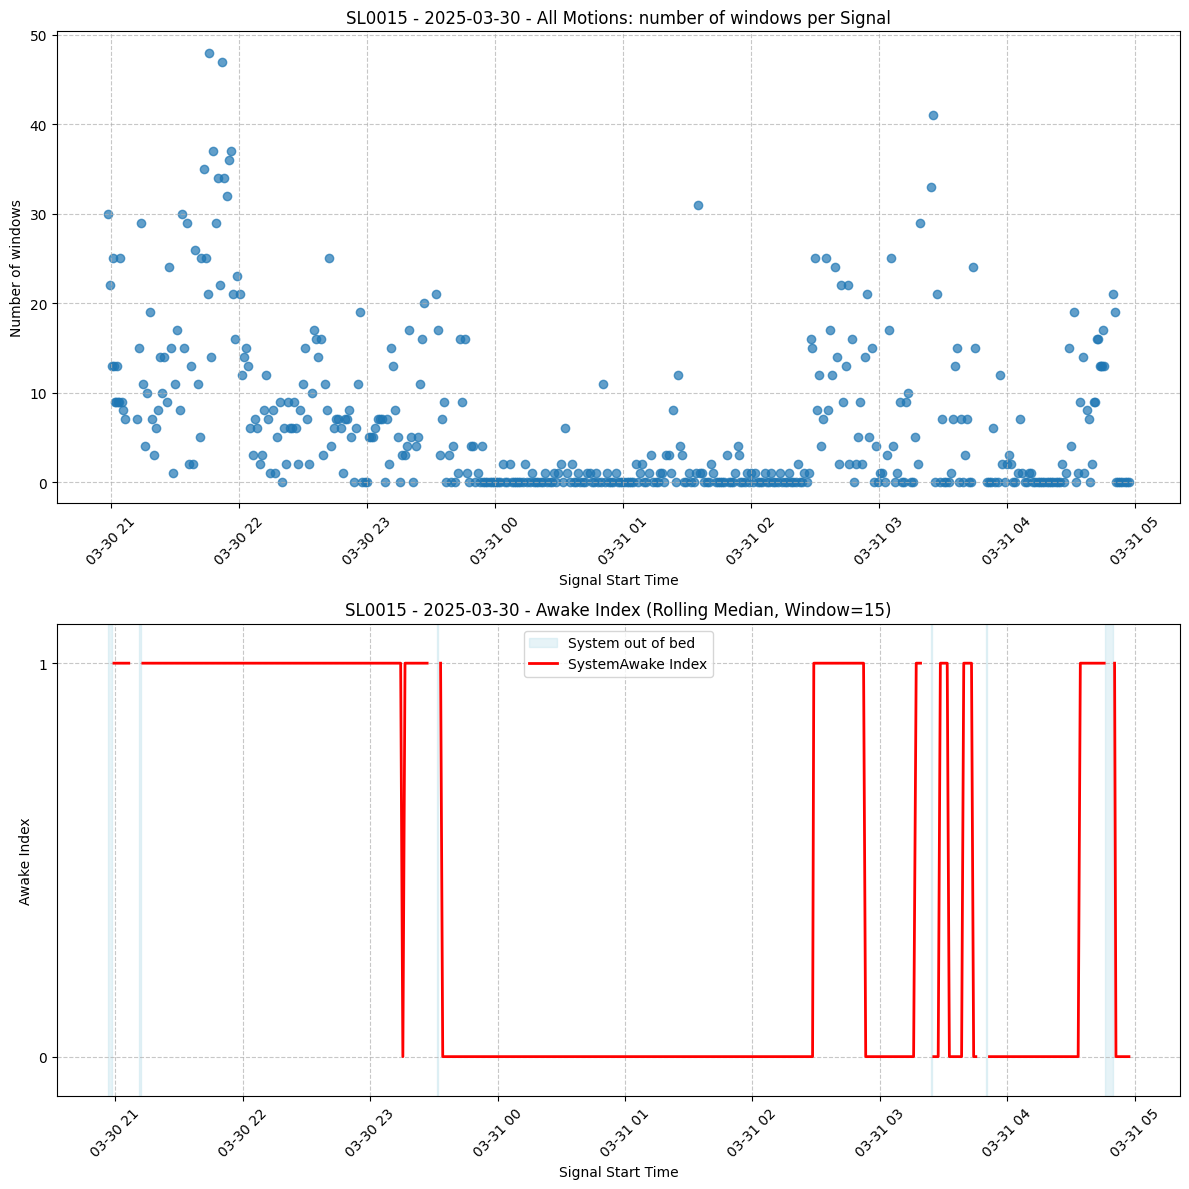

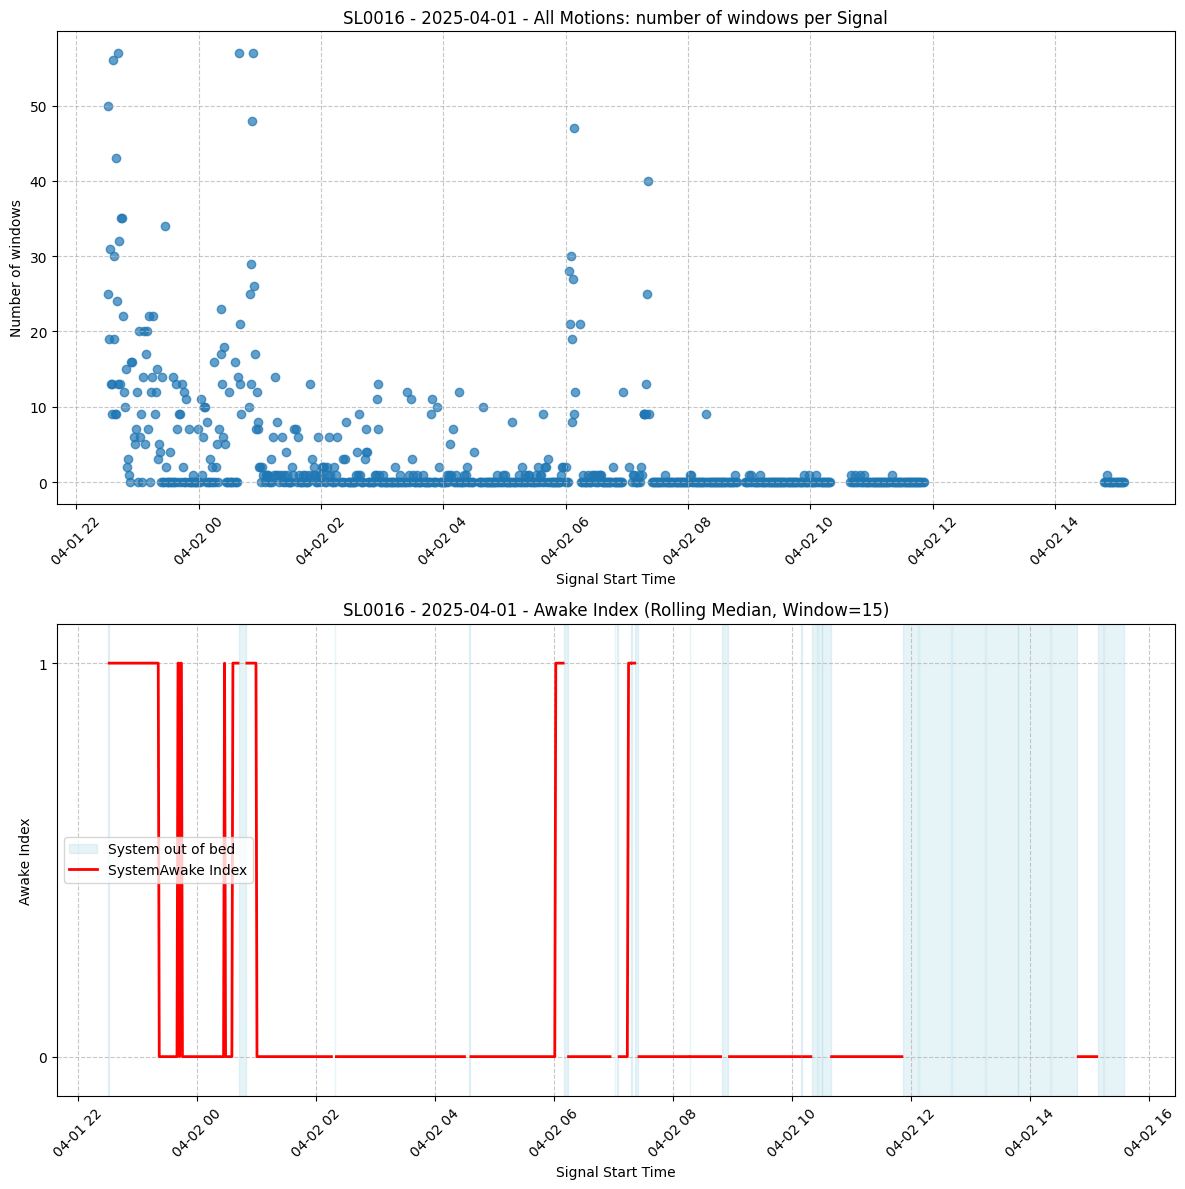

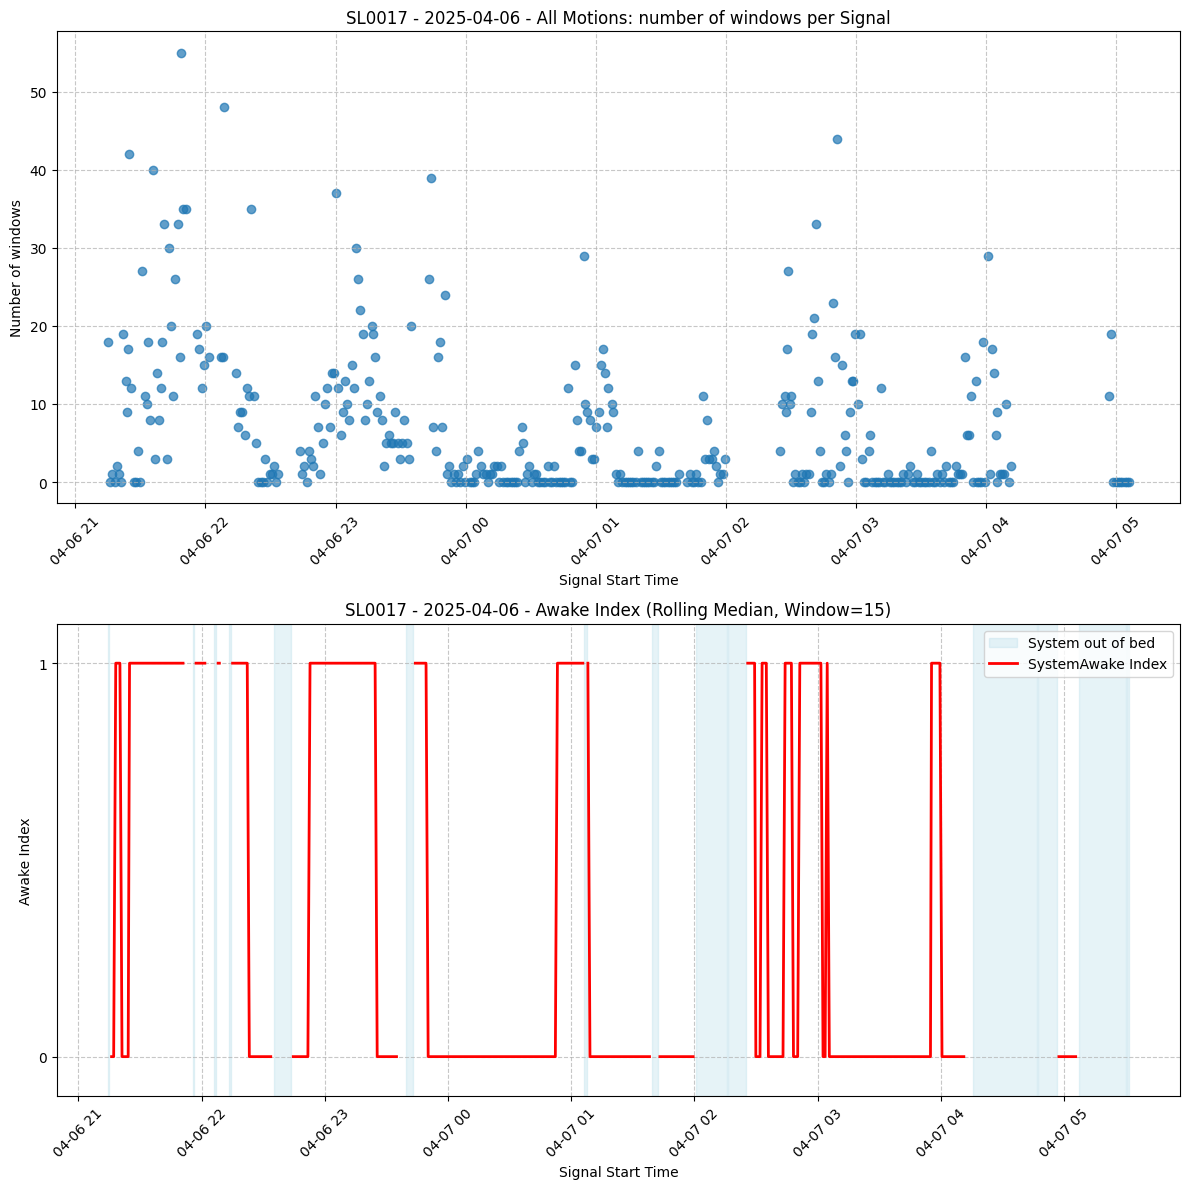

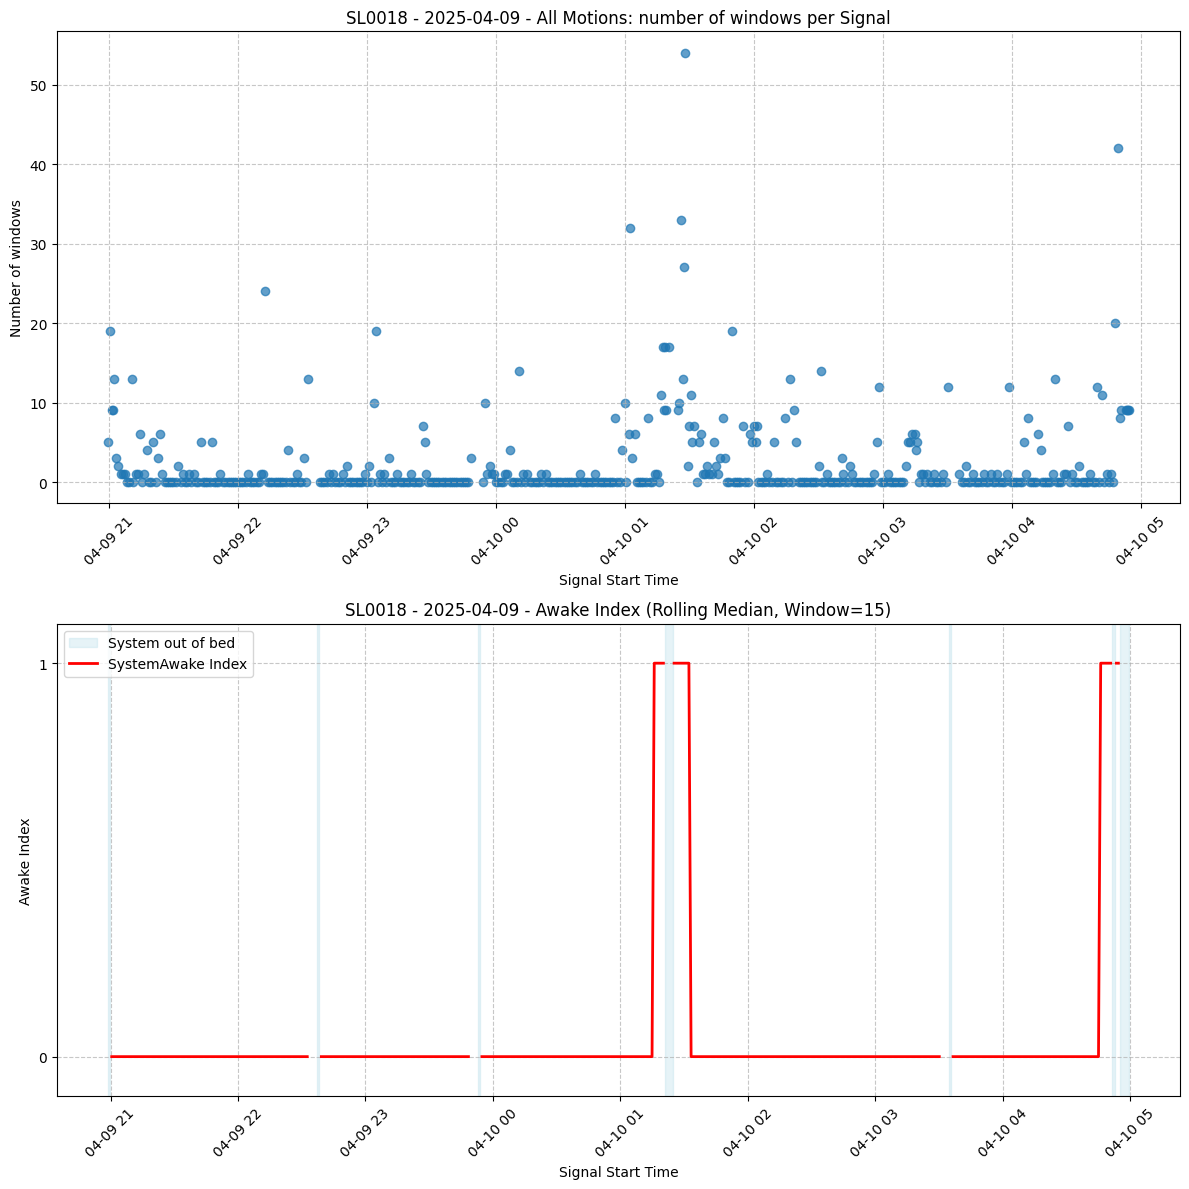

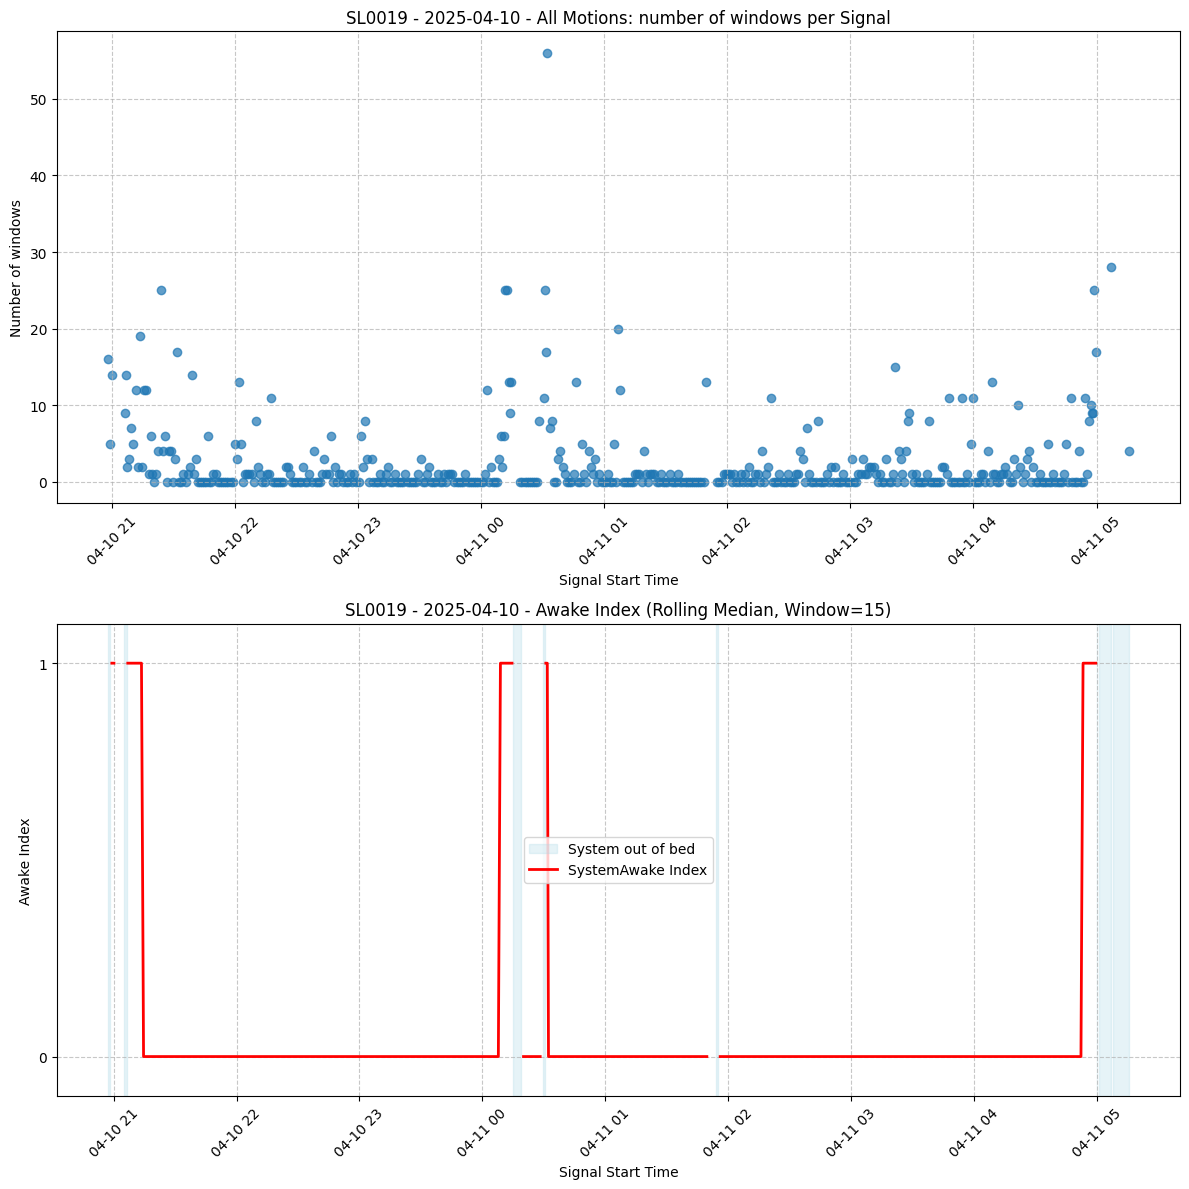

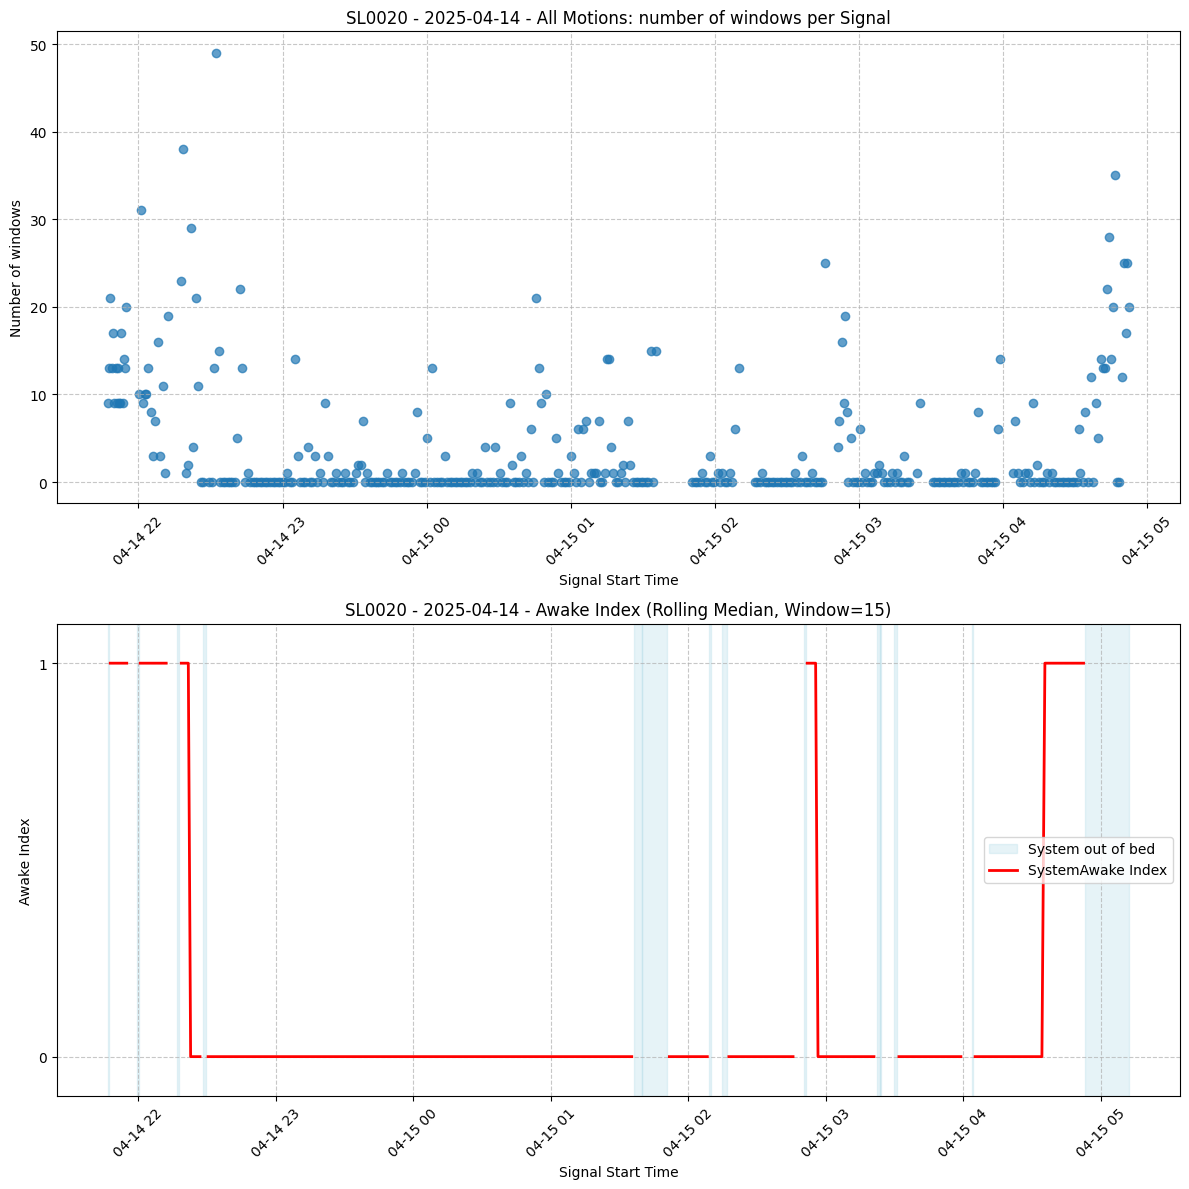

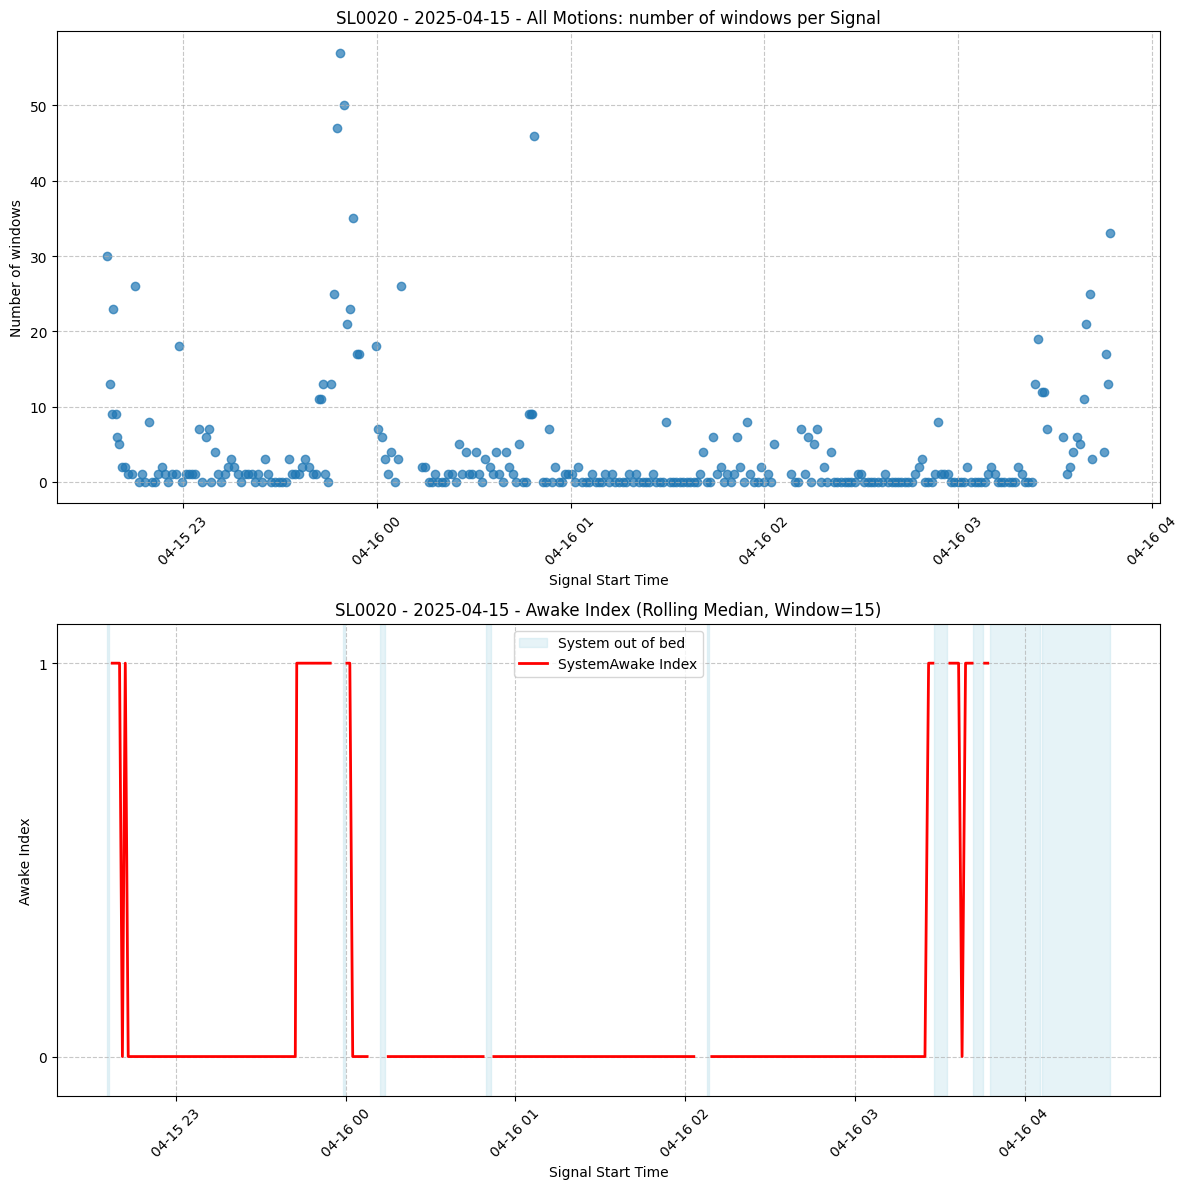

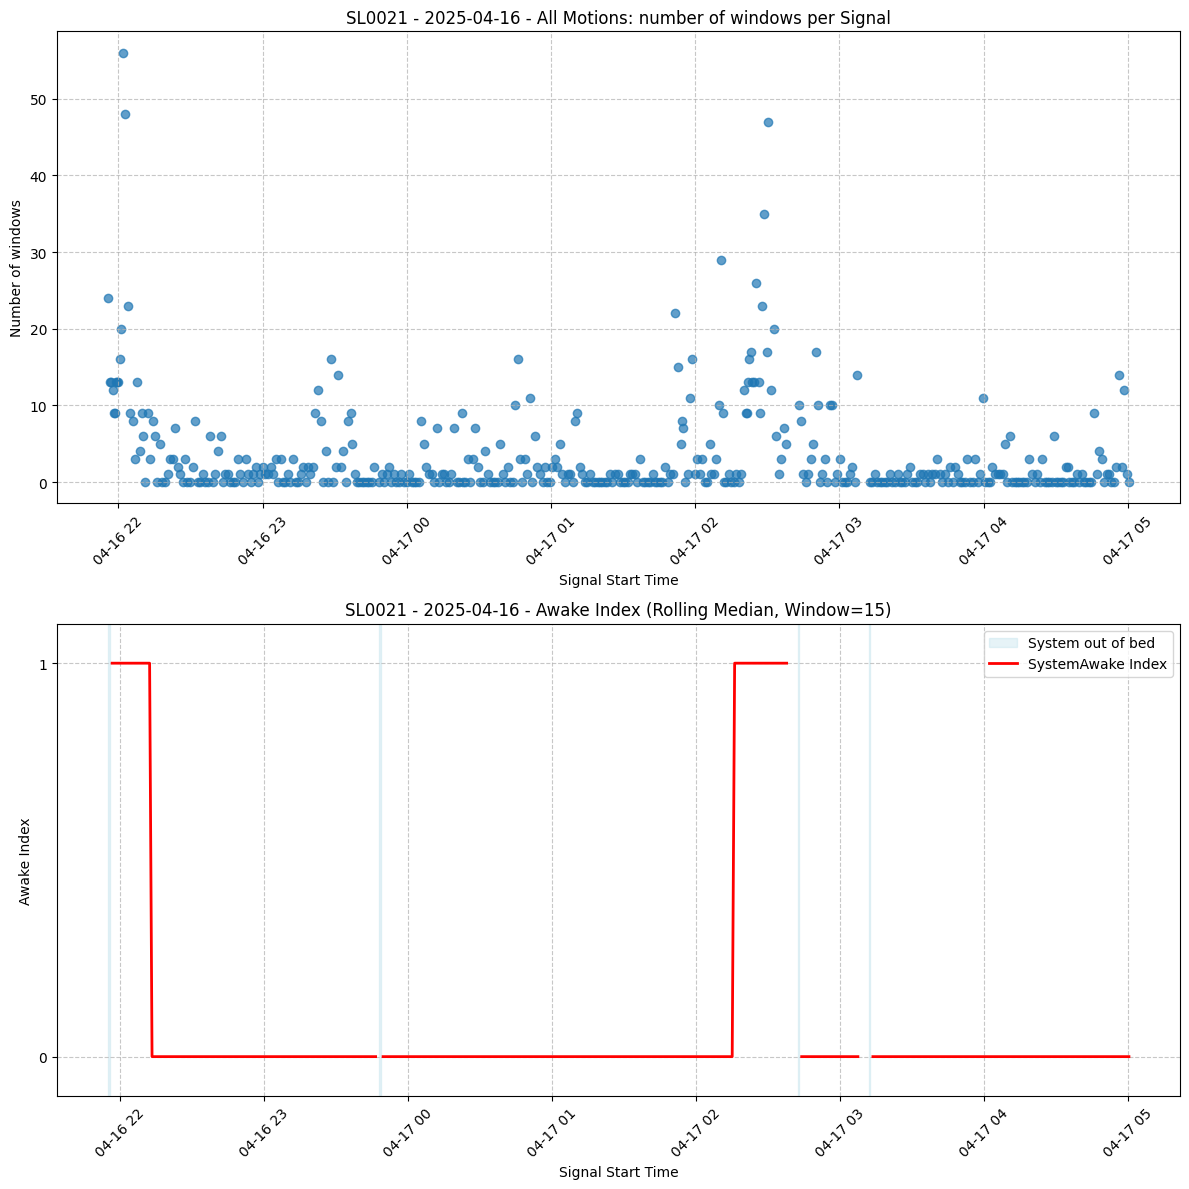

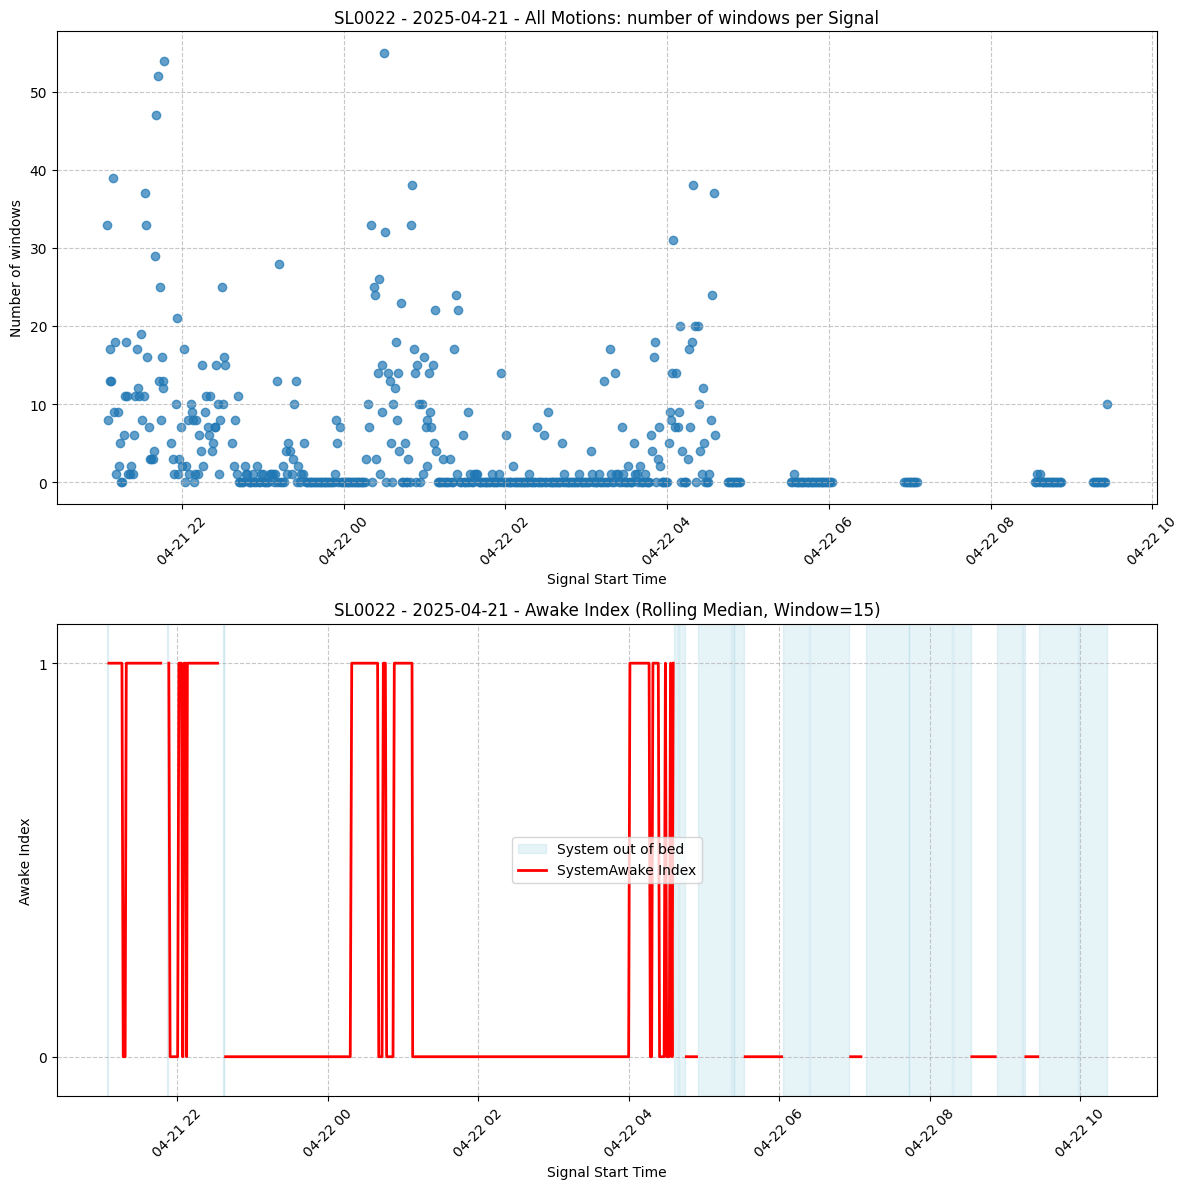

In [118]:
def fetch_motion_results(db_manager, session_id):
    """Fetch motion results for a specific session from the database."""
    q = f"""
    SELECT RadarSignal.SessionID, RadarSignal.SessionSignalID, RadarSignal.StartTime, 
    RadarSignal.EndTime, MotionResults.MotionClassifierLabelID
    FROM RadarSignal
    LEFT JOIN MotionResults ON RadarSignal.SessionID = MotionResults.SessionID
    AND RadarSignal.SessionSignalID = MotionResults.SessionSignalID
    WHERE RadarSignal.SessionID = {session_id}
    AND RadarSignal.RadarModeID = 3
    """
    df = pd.read_sql(q, db_manager.engine)
    return df

def fetch_session_states(db_manager, session_id):
    """Fetch session states for a specific session from the database."""
    q = f"""
    SELECT SessionID, StateIndex, StateName, StartTime, EndTime
    FROM StatesRecord
    WHERE SessionID = {session_id}
    """
    df = pd.read_sql(q, db_manager.engine)
    return df

def prepare_motion_data(df_motion, label_ids):
    """Prepare motion data for plotting by counting windows for each signal."""
    # Get all unique SessionSignalIDs from df_motion
    all_signal_ids = df_motion['SessionSignalID'].unique()
    
    # Filter data for the current motion type
    filtered_df = df_motion[df_motion['MotionClassifierLabelID'].isin(label_ids)]
    
    # Create a DataFrame with counts for each SessionSignalID
    signal_counts = pd.DataFrame({'SessionSignalID': all_signal_ids})
    
    # Count occurrences for each SessionSignalID in the filtered data
    if len(filtered_df) > 0:
        # Count windows for signals that have matching motion types
        motion_counts = filtered_df.groupby('SessionSignalID').size().reset_index(name='RowCount')
        # Merge with all signal IDs
        signal_counts = pd.merge(signal_counts, motion_counts, on='SessionSignalID', how='left')
    else:
        # If no matches found, add RowCount column with zeros
        signal_counts['RowCount'] = 0
    
    # Fill NaN values with 0 for signals that don't have matching motion types
    signal_counts['RowCount'] = signal_counts['RowCount'].fillna(0)
    
    # Merge with original dataframe to get StartTime for each SessionSignalID
    signal_times = df_motion[['SessionSignalID', 'StartTime']].drop_duplicates()
    signal_data = pd.merge(signal_counts, signal_times, on='SessionSignalID')
    
    # Convert StartTime to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(signal_data['StartTime']):
        signal_data['StartTime'] = pd.to_datetime(signal_data['StartTime'])
    
    # Sort by StartTime
    signal_data = signal_data.sort_values('StartTime')
    
    return signal_data

def plot_motion_windows(ax, signal_data, patient, date, label_name):
    """Plot motion windows data on the given axis."""
    ax.scatter(signal_data['StartTime'], signal_data['RowCount'], alpha=0.7)
    ax.set_xlabel('Signal Start Time')
    ax.set_ylabel('Number of windows')
    ax.set_title(f'{patient} - {date} - {label_name}: number of windows per Signal')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)

def prepare_awake_data(signal_data, percentage_threshold, awake_window, out_of_bed_states):
    """Prepare awake data by applying threshold and calculating rolling median."""
    # Calculate the threshold based on percentage of maximum value
    max_count = signal_data['RowCount'].max()
    if max_count > 0:
        threshold = max_count * (percentage_threshold / 100)
    else:
        threshold = 0
    
    # Apply threshold to determine if signal is above threshold (1) or not (0)
    signal_data['AboveThreshold'] = (signal_data['RowCount'] > threshold).astype(int)
    
    # Calculate awake index based on time window in minutes
    awake_indices = []
    
    for idx, row in signal_data.iterrows():
        current_time = row['StartTime']
        # Define time window (current time +/- awake_window/2 minutes)
        window_start = current_time - pd.Timedelta(minutes=awake_window/2)
        window_end = current_time + pd.Timedelta(minutes=awake_window/2)
        
        # Get signals that fall within the time window
        window_signals = signal_data[
            (signal_data['StartTime'] >= window_start) & 
            (signal_data['StartTime'] <= window_end)
        ]
        
        # Calculate median of AboveThreshold values within the time window
        if len(window_signals) > 0:
            awake_index = window_signals['AboveThreshold'].median()
            # If the median is 0.5, set it to 1
            if awake_index == 0.5:
                awake_index = 1
        else:
            awake_index = 0
            
        awake_indices.append(awake_index)
    
    signal_data['AwakeIndex'] = awake_indices
    
    return signal_data

def plot_awake_index(out_of_bed_states, ax, signal_data, patient, date):
    """Plot awake index data on the given axis with out of bed state overlays."""

    # Create a copy of the data to avoid modifying the original
    plot_data = signal_data.copy()
    
    # Add overlay for out of bed states and mask data during out of bed periods
    if not out_of_bed_states.empty:
        # Convert times to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(out_of_bed_states['StartTime']):
            out_of_bed_states['StartTime'] = pd.to_datetime(out_of_bed_states['StartTime'])
        if not pd.api.types.is_datetime64_any_dtype(out_of_bed_states['EndTime']):
            out_of_bed_states['EndTime'] = pd.to_datetime(out_of_bed_states['EndTime'])
        
        # Sort by start time
        out_of_bed_states = out_of_bed_states.sort_values('StartTime')
        
        # Merge overlapping time periods
        merged_periods = []
        current_start = out_of_bed_states.iloc[0]['StartTime']
        current_end = out_of_bed_states.iloc[0]['EndTime']
        
        for _, state in out_of_bed_states.iloc[1:].iterrows():
            if state['StartTime'] <= current_end:
                # Overlapping period, extend the current end if needed
                current_end = max(current_end, state['EndTime'])
            else:
                # Non-overlapping period, add the current period and start a new one
                merged_periods.append((current_start, current_end))
                current_start = state['StartTime']
                current_end = state['EndTime']
        
        # Add the last period
        merged_periods.append((current_start, current_end))
        
        # Mask data during out of bed periods to create gaps in the line plot
        for start_time, end_time in merged_periods:
            # Set AwakeIndex to NaN for points within out of bed periods
            mask = (plot_data['StartTime'] >= start_time) & (plot_data['StartTime'] <= end_time)
            plot_data.loc[mask, 'AwakeIndex'] = np.nan
            
        # Add shaded regions for merged out of bed periods
        for i, (start_time, end_time) in enumerate(merged_periods):
            # Only add label for the first instance to avoid duplicate legend entries
            label = 'System out of bed' if i == 0 else None
            ax.axvspan(start_time, end_time, alpha=0.3, color='lightblue', label=label)
    
    # Plot the awake index with gaps during out of bed periods
    ax.plot(plot_data['StartTime'], plot_data['AwakeIndex'], 'r-', linewidth=2, label='System Awake Index')
            
    # Add legend (always show it)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.set_xlabel('Signal Start Time')
    ax.set_ylabel('Awake Index')
    ax.set_title(f'{patient} - {date} - Awake Index (Rolling Median, Window={awake_window})')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(-0.1, 1.1)  # Set y-axis limits for better visualization
    ax.set_yticks([0, 1])  # Set y-ticks to only show 0 and 1
    ax.grid(True, linestyle='--', alpha=0.7)

# Main execution
relevant_labels = {'All Motions': [1, 2, 3]} # 'Significant Motion': [2, 3]}
exclude_patients = ['SL0003']

session_df = fetch_study_sessions(db_manager, study)
patients = session_df['PatientStudyName'].unique()
patients = [p for p in patients if p not in exclude_patients]
#patients = ['SL0005','SL0009', 'SL0012', 'SL0014', 'SL0016', 'SL0018']
motion_windows_th_percent = 10  # Percentage of maximum motion windows to consider awake per signal
awake_window = 15 # minutes

df = session_df[session_df['PatientStudyName'].isin(patients)]
sessions_ids = df['ID'].unique()
n_configs = len(relevant_labels)

for session_id in sessions_ids:
    session_motion_windows = {}
    session_data = df[df['ID'] == session_id].copy()
    
    """Analyze and plot motion data for a specific session."""
    patient = session_data['PatientStudyName'].unique()[0]
    date = pd.to_datetime(session_data['StartTime'].unique()[0]).date()
    df_motion = fetch_motion_results(db_manager, session_id)
    df_states = fetch_session_states(db_manager, session_id)
    
    # Define in-bed states and filter out-of-bed states
    in_bed_states = ['Respiration_in_bed', 'Posture_in_bed','Idle']
    out_of_bed_states = df_states[~df_states['StateName'].isin(in_bed_states)]
    
    # Create a figure with subplots for motion windows and awake index
    fig, axs = plt.subplots(n_configs * 2, 1, figsize=(12, 6*n_configs*2))
    axs = [axs] if n_configs * 2 == 1 else axs

    # Process each type of motion
    for i, (label_name, label_ids) in enumerate(relevant_labels.items()):
        # Prepare and plot motion windows data
        signal_data = prepare_motion_data(df_motion, label_ids)
        session_motion_windows[label_name] = signal_data
        plot_motion_windows(axs[i*3], signal_data, patient, date, label_name)
        
        # Prepare and plot awake index data
        awake_data = prepare_awake_data(signal_data, motion_windows_th_percent, awake_window,out_of_bed_states)
        plot_awake_index(out_of_bed_states, axs[i*2+1], awake_data, patient, date)

    
    plt.tight_layout()
    plt.show()

In [69]:
sessions_ids

array([391])

In [57]:
'SslL''ZDNI 'SShi`sfohs`zidf.columns


Index(['ID', 'SessionID', 'SessionSignalID', 'StateIndex', 'StartTime',
       'EndTime', 'RadarModeID', 'SignalS3Path', 'AntennaNumber', 'RStart',
       'Fps', 'Pps', 'Tags', 'VideoOffset', 'ID', 'SessionID',
       'SessionSignalID', 'SystemVersionID', 'MotionClassifierLabelID',
       'StartIndex', 'EndIndex', 'ClassifierScore', 'MotionStartIndex',
       'MotionEndIndex'],
      dtype='object')